# Description

It runs DBSCAN on the pca version of the data.

The notebook explores different values for min_samples and eps (the main parameters of DBSCAN).

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

from utils import generate_result_set_name
from clustering.ensemble import generate_ensemble

# Global settings

In [5]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

# Data version: pca

## Settings

In [6]:
INPUT_SUBSET = "pca"

In [7]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
# parameters of the dimentionality reduction steps
DR_OPTIONS = {
    "n_components": 50,
    "svd_solver": "full",
    "random_state": 0,
}

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/pca/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full.pkl')

'pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full'

In [10]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

## Load input file

In [11]:
data = pd.read_pickle(input_filepath)

In [12]:
data.shape

(3749, 50)

In [13]:
data.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50
100001_raw-Food_weight,-0.547515,-0.007250,0.245361,0.132424,1.201447,-0.113158,0.048859,1.031679,0.711208,0.126100,...,0.113685,-0.109753,0.178202,-0.487868,1.805920,-0.342611,-0.663712,-1.313987,-1.481707,0.396410
100002_raw-Energy,-1.570593,-0.618992,-1.223395,1.627321,-0.563860,0.224922,-1.500327,2.045633,-1.665998,-0.180432,...,0.697880,1.412676,2.103988,0.385625,2.386495,-2.939998,-0.978275,-1.893307,-0.259497,0.423264
100003_raw-Protein,-0.601212,-0.948824,-1.022209,2.438433,-2.062235,0.356202,-1.538038,2.314675,-1.108991,0.318034,...,0.171992,1.351979,0.054404,-0.725132,2.226520,-3.481674,-0.445294,-0.477452,0.237157,1.440867
100004_raw-Fat,-1.648214,-0.342042,-0.270189,1.683268,-1.222401,0.018349,-0.032824,1.671161,-0.908965,0.224100,...,-0.358812,0.696836,1.072624,0.627951,1.802000,0.174704,0.826319,-0.826992,0.596113,0.620050
100005_raw-Carbohydrate,-1.867586,-0.006412,-0.303220,0.770958,-0.116822,0.460946,-2.407732,1.534273,-1.930577,0.064621,...,1.332852,1.978032,2.158456,0.831123,1.093202,-3.539033,-0.831862,-0.842298,-0.723072,0.359438


In [14]:
assert not data.isna().any().any()

## Tests different k values (k-NN)

In [15]:
k_values = np.arange(2, 100 + 1, 1)
k_values_to_explore = (2, 5, 10, 15, 20, 30, 40, 50, 75, 100)

In [16]:
results = {}

for k in k_values_to_explore:
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=N_JOBS).fit(data)
    distances, indices = nbrs.kneighbors(data)
    results[k] = (distances, indices)

In [17]:
min_max_range = (15, 80)

eps_range_per_k = {k: min_max_range for k in k_values}
eps_range_per_k_to_explore = {k: min_max_range for k in k_values_to_explore}

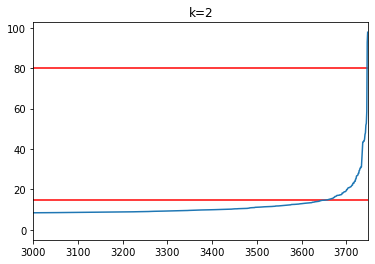

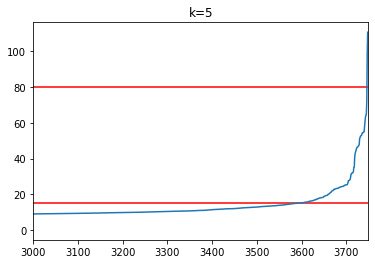

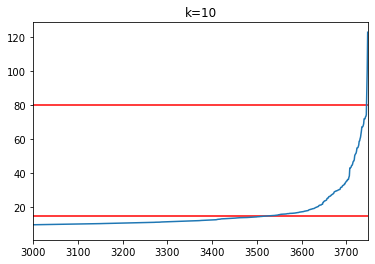

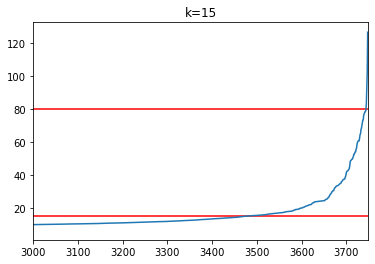

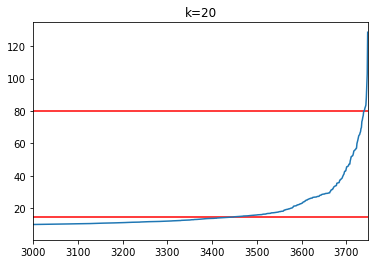

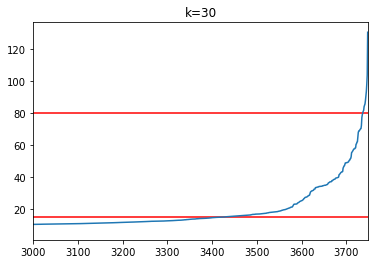

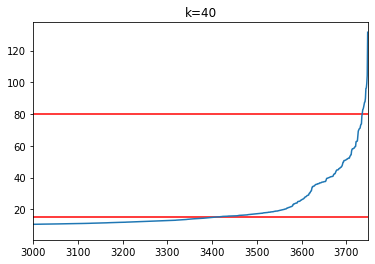

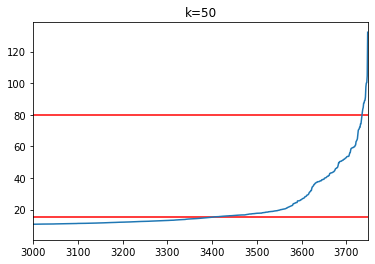

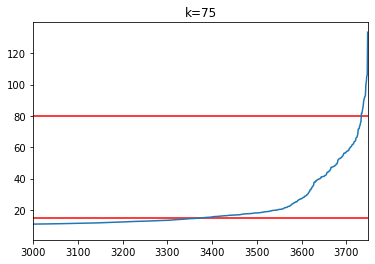

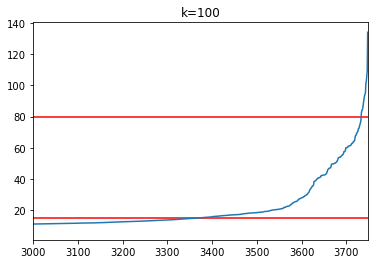

In [18]:
for k, (distances, indices) in results.items():
    d = distances[:, 1:].mean(axis=1)
    d = np.sort(d)

    fig, ax = plt.subplots()
    plt.plot(d)

    r = eps_range_per_k_to_explore[k]
    plt.hlines(r[0], 0, data.shape[0], color="red")
    plt.hlines(r[1], 0, data.shape[0], color="red")

    plt.xlim((3000, data.shape[0]))
    plt.title(f"k={k}")
    display(fig)

    plt.close(fig)

## Clustering

### Generate clusterers

In [19]:
CLUSTERING_OPTIONS = {}

# K_RANGE is the min_samples parameter in DBSCAN (sklearn)
CLUSTERING_OPTIONS["K_RANGE"] = k_values
CLUSTERING_OPTIONS["EPS_RANGE_PER_K"] = eps_range_per_k
CLUSTERING_OPTIONS["EPS_STEP"] = 33
CLUSTERING_OPTIONS["METRIC"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_RANGE': array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100]),
 'EPS_RANGE_PER_K': {2: (15, 80),
  3: (15, 80),
  4: (15, 80),
  5: (15, 80),
  6: (15, 80),
  7: (15, 80),
  8: (15, 80),
  9: (15, 80),
  10: (15, 80),
  11: (15, 80),
  12: (15, 80),
  13: (15, 80),
  14: (15, 80),
  15: (15, 80),
  16: (15, 80),
  17: (15, 80),
  18: (15, 80),
  19: (15, 80),
  20: (15, 80),
  21: (15, 80),
  22: (15, 80),
  23: (15, 80),
  24: (15, 80),
  25: (15, 80),
  26: (15, 80),
  27: (15, 80),
 

In [20]:
CLUSTERERS = {}

idx = 0

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    eps_range = CLUSTERING_OPTIONS["EPS_RANGE_PER_K"][k]
    eps_values = np.linspace(eps_range[0], eps_range[1], CLUSTERING_OPTIONS["EPS_STEP"])

    for eps in eps_values:
        clus = DBSCAN(min_samples=k, eps=eps, metric="precomputed", n_jobs=N_JOBS)

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [21]:
display(len(CLUSTERERS))

3267

In [22]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DBSCAN #0', DBSCAN(eps=15.0, metric='precomputed', min_samples=2, n_jobs=3))

('DBSCAN #1',
 DBSCAN(eps=17.03125, metric='precomputed', min_samples=2, n_jobs=3))

In [23]:
clustering_method_name = method_name
display(clustering_method_name)

'DBSCAN'

### Generate ensemble

In [24]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["METRIC"])

In [25]:
data_dist.shape

(3749, 3749)

In [26]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14055001.0
mean     17.536786666895573
std      14.914704903599608
min                     0.0
25%      11.028118338431472
50%      12.507491786104163
75%      16.607661053517283
max      160.45156459412453
dtype: object

In [27]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

  0%|          | 0/3267 [00:00<?, ?it/s]

  0%|          | 1/3267 [00:00<11:58,  4.55it/s]

  0%|          | 2/3267 [00:00<11:39,  4.67it/s]

  0%|          | 3/3267 [00:00<11:29,  4.73it/s]

  0%|          | 4/3267 [00:00<11:24,  4.77it/s]

  0%|          | 5/3267 [00:01<11:17,  4.81it/s]

  0%|          | 6/3267 [00:01<11:11,  4.86it/s]

  0%|          | 7/3267 [00:01<11:08,  4.88it/s]

  0%|          | 8/3267 [00:01<11:06,  4.89it/s]

  0%|          | 9/3267 [00:01<11:05,  4.89it/s]

  0%|          | 10/3267 [00:02<11:04,  4.90it/s]

  0%|          | 11/3267 [00:02<11:03,  4.91it/s]

  0%|          | 12/3267 [00:02<11:00,  4.93it/s]

  0%|          | 13/3267 [00:02<11:02,  4.91it/s]

  0%|          | 14/3267 [00:02<11:01,  4.92it/s]

  0%|          | 15/3267 [00:03<11:01,  4.92it/s]

  0%|          | 16/3267 [00:03<11:02,  4.90it/s]

  1%|          | 17/3267 [00:03<11:04,  4.89it/s]

  1%|          | 18/3267 [00:03<11:05,  4.88it/s]

  1%|          | 19/3267 [00:03<11:07,  4.87it/s]

  1%|          | 20/3267 [00:04<11:07,  4.86it/s]

  1%|          | 21/3267 [00:04<11:07,  4.86it/s]

  1%|          | 22/3267 [00:04<11:05,  4.88it/s]

  1%|          | 23/3267 [00:04<11:04,  4.88it/s]

  1%|          | 24/3267 [00:04<11:05,  4.87it/s]

  1%|          | 25/3267 [00:05<11:05,  4.87it/s]

  1%|          | 26/3267 [00:05<11:05,  4.87it/s]

  1%|          | 27/3267 [00:05<11:03,  4.88it/s]

  1%|          | 28/3267 [00:05<11:05,  4.87it/s]

  1%|          | 29/3267 [00:05<11:05,  4.86it/s]

  1%|          | 30/3267 [00:06<11:04,  4.87it/s]

  1%|          | 31/3267 [00:06<11:04,  4.87it/s]

  1%|          | 32/3267 [00:06<11:04,  4.87it/s]

  1%|          | 33/3267 [00:06<11:02,  4.88it/s]

  1%|          | 34/3267 [00:06<10:54,  4.94it/s]

  1%|          | 35/3267 [00:07<11:40,  4.61it/s]

  1%|          | 36/3267 [00:07<11:16,  4.78it/s]

  1%|          | 37/3267 [00:07<10:58,  4.90it/s]

  1%|          | 38/3267 [00:07<10:46,  4.99it/s]

  1%|          | 39/3267 [00:07<10:37,  5.06it/s]

  1%|          | 40/3267 [00:08<10:35,  5.08it/s]

  1%|▏         | 41/3267 [00:08<10:30,  5.12it/s]

  1%|▏         | 42/3267 [00:08<10:32,  5.10it/s]

  1%|▏         | 43/3267 [00:08<10:32,  5.10it/s]

  1%|▏         | 44/3267 [00:08<10:31,  5.10it/s]

  1%|▏         | 45/3267 [00:09<10:29,  5.12it/s]

  1%|▏         | 46/3267 [00:09<10:29,  5.12it/s]

  1%|▏         | 47/3267 [00:09<10:27,  5.13it/s]

  1%|▏         | 48/3267 [00:09<10:25,  5.15it/s]

  1%|▏         | 49/3267 [00:09<10:26,  5.14it/s]

  2%|▏         | 50/3267 [00:10<10:25,  5.14it/s]

  2%|▏         | 51/3267 [00:10<10:25,  5.14it/s]

  2%|▏         | 52/3267 [00:10<10:25,  5.14it/s]

  2%|▏         | 53/3267 [00:10<10:25,  5.14it/s]

  2%|▏         | 54/3267 [00:10<10:28,  5.11it/s]

  2%|▏         | 55/3267 [00:11<10:30,  5.10it/s]

  2%|▏         | 56/3267 [00:11<10:31,  5.08it/s]

  2%|▏         | 57/3267 [00:11<10:32,  5.08it/s]

  2%|▏         | 58/3267 [00:11<10:33,  5.07it/s]

  2%|▏         | 59/3267 [00:11<10:35,  5.05it/s]

  2%|▏         | 60/3267 [00:12<10:32,  5.07it/s]

  2%|▏         | 61/3267 [00:12<10:30,  5.08it/s]

  2%|▏         | 62/3267 [00:12<10:30,  5.08it/s]

  2%|▏         | 63/3267 [00:12<10:29,  5.09it/s]

  2%|▏         | 64/3267 [00:12<10:28,  5.09it/s]

  2%|▏         | 65/3267 [00:13<10:27,  5.11it/s]

  2%|▏         | 66/3267 [00:13<10:27,  5.10it/s]

  2%|▏         | 67/3267 [00:13<10:21,  5.15it/s]

  2%|▏         | 68/3267 [00:13<10:18,  5.18it/s]

  2%|▏         | 69/3267 [00:13<10:17,  5.18it/s]

  2%|▏         | 70/3267 [00:14<10:15,  5.19it/s]

  2%|▏         | 71/3267 [00:14<10:14,  5.20it/s]

  2%|▏         | 72/3267 [00:14<10:13,  5.20it/s]

  2%|▏         | 73/3267 [00:14<10:14,  5.20it/s]

  2%|▏         | 74/3267 [00:14<10:15,  5.19it/s]

  2%|▏         | 75/3267 [00:14<10:17,  5.17it/s]

  2%|▏         | 76/3267 [00:15<10:16,  5.18it/s]

  2%|▏         | 77/3267 [00:15<10:16,  5.17it/s]

  2%|▏         | 78/3267 [00:15<11:01,  4.82it/s]

  2%|▏         | 79/3267 [00:15<10:52,  4.89it/s]

  2%|▏         | 80/3267 [00:16<10:41,  4.97it/s]

  2%|▏         | 81/3267 [00:16<10:33,  5.03it/s]

  3%|▎         | 82/3267 [00:16<10:27,  5.08it/s]

  3%|▎         | 83/3267 [00:16<10:23,  5.11it/s]

  3%|▎         | 84/3267 [00:16<10:21,  5.12it/s]

  3%|▎         | 85/3267 [00:16<10:23,  5.10it/s]

  3%|▎         | 86/3267 [00:17<10:21,  5.12it/s]

  3%|▎         | 87/3267 [00:17<10:19,  5.13it/s]

  3%|▎         | 88/3267 [00:17<10:18,  5.14it/s]

  3%|▎         | 89/3267 [00:17<10:17,  5.15it/s]

  3%|▎         | 90/3267 [00:17<10:19,  5.13it/s]

  3%|▎         | 91/3267 [00:18<10:20,  5.12it/s]

  3%|▎         | 92/3267 [00:18<10:20,  5.11it/s]

  3%|▎         | 93/3267 [00:18<10:21,  5.11it/s]

  3%|▎         | 94/3267 [00:18<10:23,  5.09it/s]

  3%|▎         | 95/3267 [00:18<10:24,  5.08it/s]

  3%|▎         | 96/3267 [00:19<10:24,  5.08it/s]

  3%|▎         | 97/3267 [00:19<10:23,  5.08it/s]

  3%|▎         | 98/3267 [00:19<10:21,  5.10it/s]

  3%|▎         | 99/3267 [00:19<10:22,  5.09it/s]

  3%|▎         | 100/3267 [00:19<10:18,  5.12it/s]

  3%|▎         | 101/3267 [00:20<10:14,  5.15it/s]

  3%|▎         | 102/3267 [00:20<10:13,  5.16it/s]

  3%|▎         | 103/3267 [00:20<10:11,  5.17it/s]

  3%|▎         | 104/3267 [00:20<10:10,  5.18it/s]

  3%|▎         | 105/3267 [00:20<10:10,  5.18it/s]

  3%|▎         | 106/3267 [00:21<10:10,  5.18it/s]

  3%|▎         | 107/3267 [00:21<10:10,  5.17it/s]

  3%|▎         | 108/3267 [00:21<10:11,  5.17it/s]

  3%|▎         | 109/3267 [00:21<10:11,  5.16it/s]

  3%|▎         | 110/3267 [00:21<10:12,  5.15it/s]

  3%|▎         | 111/3267 [00:22<10:12,  5.15it/s]

  3%|▎         | 112/3267 [00:22<10:13,  5.15it/s]

  3%|▎         | 113/3267 [00:22<10:12,  5.15it/s]

  3%|▎         | 114/3267 [00:22<10:11,  5.16it/s]

  4%|▎         | 115/3267 [00:22<10:11,  5.15it/s]

  4%|▎         | 116/3267 [00:23<10:13,  5.14it/s]

  4%|▎         | 117/3267 [00:23<10:13,  5.14it/s]

  4%|▎         | 118/3267 [00:23<10:13,  5.14it/s]

  4%|▎         | 119/3267 [00:23<10:12,  5.14it/s]

  4%|▎         | 120/3267 [00:23<10:10,  5.15it/s]

  4%|▎         | 121/3267 [00:23<10:11,  5.14it/s]

  4%|▎         | 122/3267 [00:24<10:11,  5.14it/s]

  4%|▍         | 123/3267 [00:24<10:12,  5.14it/s]

  4%|▍         | 124/3267 [00:24<10:55,  4.79it/s]

  4%|▍         | 125/3267 [00:24<10:44,  4.88it/s]

  4%|▍         | 126/3267 [00:25<10:36,  4.94it/s]

  4%|▍         | 127/3267 [00:25<10:29,  4.99it/s]

  4%|▍         | 128/3267 [00:25<10:24,  5.02it/s]

  4%|▍         | 129/3267 [00:25<10:20,  5.06it/s]

  4%|▍         | 130/3267 [00:25<10:18,  5.08it/s]

  4%|▍         | 131/3267 [00:25<10:17,  5.08it/s]

  4%|▍         | 132/3267 [00:26<10:15,  5.09it/s]

  4%|▍         | 133/3267 [00:26<10:10,  5.13it/s]

  4%|▍         | 134/3267 [00:26<10:06,  5.16it/s]

  4%|▍         | 135/3267 [00:26<10:02,  5.20it/s]

  4%|▍         | 136/3267 [00:26<10:04,  5.18it/s]

  4%|▍         | 137/3267 [00:27<10:04,  5.18it/s]

  4%|▍         | 138/3267 [00:27<10:02,  5.19it/s]

  4%|▍         | 139/3267 [00:27<10:02,  5.19it/s]

  4%|▍         | 140/3267 [00:27<10:02,  5.19it/s]

  4%|▍         | 141/3267 [00:27<10:04,  5.17it/s]

  4%|▍         | 142/3267 [00:28<10:04,  5.17it/s]

  4%|▍         | 143/3267 [00:28<10:03,  5.17it/s]

  4%|▍         | 144/3267 [00:28<10:04,  5.17it/s]

  4%|▍         | 145/3267 [00:28<10:04,  5.17it/s]

  4%|▍         | 146/3267 [00:28<10:05,  5.16it/s]

  4%|▍         | 147/3267 [00:29<10:04,  5.16it/s]

  5%|▍         | 148/3267 [00:29<10:05,  5.16it/s]

  5%|▍         | 149/3267 [00:29<10:05,  5.15it/s]

  5%|▍         | 150/3267 [00:29<10:05,  5.14it/s]

  5%|▍         | 151/3267 [00:29<10:04,  5.15it/s]

  5%|▍         | 152/3267 [00:30<10:04,  5.16it/s]

  5%|▍         | 153/3267 [00:30<10:01,  5.18it/s]

  5%|▍         | 154/3267 [00:30<10:01,  5.17it/s]

  5%|▍         | 155/3267 [00:30<10:02,  5.17it/s]

  5%|▍         | 156/3267 [00:30<10:02,  5.17it/s]

  5%|▍         | 157/3267 [00:31<10:05,  5.14it/s]

  5%|▍         | 158/3267 [00:31<10:05,  5.14it/s]

  5%|▍         | 159/3267 [00:31<10:06,  5.12it/s]

  5%|▍         | 160/3267 [00:31<10:06,  5.13it/s]

  5%|▍         | 161/3267 [00:31<10:05,  5.13it/s]

  5%|▍         | 162/3267 [00:31<10:06,  5.12it/s]

  5%|▍         | 163/3267 [00:32<10:05,  5.13it/s]

  5%|▌         | 164/3267 [00:32<10:07,  5.11it/s]

  5%|▌         | 165/3267 [00:32<10:08,  5.10it/s]

  5%|▌         | 166/3267 [00:32<10:02,  5.14it/s]

  5%|▌         | 167/3267 [00:32<10:01,  5.15it/s]

  5%|▌         | 168/3267 [00:33<10:42,  4.82it/s]

  5%|▌         | 169/3267 [00:33<10:29,  4.92it/s]

  5%|▌         | 170/3267 [00:33<10:19,  5.00it/s]

  5%|▌         | 171/3267 [00:33<10:12,  5.05it/s]

  5%|▌         | 172/3267 [00:33<10:10,  5.07it/s]

  5%|▌         | 173/3267 [00:34<10:06,  5.10it/s]

  5%|▌         | 174/3267 [00:34<10:04,  5.12it/s]

  5%|▌         | 175/3267 [00:34<10:02,  5.13it/s]

  5%|▌         | 176/3267 [00:34<10:01,  5.14it/s]

  5%|▌         | 177/3267 [00:34<10:01,  5.14it/s]

  5%|▌         | 178/3267 [00:35<10:02,  5.13it/s]

  5%|▌         | 179/3267 [00:35<10:00,  5.15it/s]

  6%|▌         | 180/3267 [00:35<09:59,  5.15it/s]

  6%|▌         | 181/3267 [00:35<09:58,  5.16it/s]

  6%|▌         | 182/3267 [00:35<09:59,  5.14it/s]

  6%|▌         | 183/3267 [00:36<09:59,  5.14it/s]

  6%|▌         | 184/3267 [00:36<09:59,  5.14it/s]

  6%|▌         | 185/3267 [00:36<10:00,  5.13it/s]

  6%|▌         | 186/3267 [00:36<09:59,  5.14it/s]

  6%|▌         | 187/3267 [00:36<10:00,  5.13it/s]

  6%|▌         | 188/3267 [00:37<10:01,  5.12it/s]

  6%|▌         | 189/3267 [00:37<10:00,  5.12it/s]

  6%|▌         | 190/3267 [00:37<10:00,  5.12it/s]

  6%|▌         | 191/3267 [00:37<10:00,  5.12it/s]

  6%|▌         | 192/3267 [00:37<10:01,  5.12it/s]

  6%|▌         | 193/3267 [00:38<10:02,  5.10it/s]

  6%|▌         | 194/3267 [00:38<10:01,  5.11it/s]

  6%|▌         | 195/3267 [00:38<10:00,  5.11it/s]

  6%|▌         | 196/3267 [00:38<10:00,  5.11it/s]

  6%|▌         | 197/3267 [00:38<10:01,  5.11it/s]

  6%|▌         | 198/3267 [00:39<10:03,  5.09it/s]

  6%|▌         | 199/3267 [00:39<09:57,  5.13it/s]

  6%|▌         | 200/3267 [00:39<09:55,  5.15it/s]

  6%|▌         | 201/3267 [00:39<09:53,  5.17it/s]

  6%|▌         | 202/3267 [00:39<09:52,  5.18it/s]

  6%|▌         | 203/3267 [00:40<09:52,  5.17it/s]

  6%|▌         | 204/3267 [00:40<09:51,  5.18it/s]

  6%|▋         | 205/3267 [00:40<09:52,  5.17it/s]

  6%|▋         | 206/3267 [00:40<09:53,  5.16it/s]

  6%|▋         | 207/3267 [00:40<09:53,  5.15it/s]

  6%|▋         | 208/3267 [00:40<09:55,  5.14it/s]

  6%|▋         | 209/3267 [00:41<09:54,  5.14it/s]

  6%|▋         | 210/3267 [00:41<09:53,  5.15it/s]

  6%|▋         | 211/3267 [00:41<09:54,  5.14it/s]

  6%|▋         | 212/3267 [00:41<09:53,  5.15it/s]

  7%|▋         | 213/3267 [00:41<09:52,  5.15it/s]

  7%|▋         | 214/3267 [00:42<10:34,  4.81it/s]

  7%|▋         | 215/3267 [00:42<10:23,  4.89it/s]

  7%|▋         | 216/3267 [00:42<10:14,  4.97it/s]

  7%|▋         | 217/3267 [00:42<10:08,  5.02it/s]

  7%|▋         | 218/3267 [00:42<10:04,  5.05it/s]

  7%|▋         | 219/3267 [00:43<10:01,  5.07it/s]

  7%|▋         | 220/3267 [00:43<09:58,  5.09it/s]

  7%|▋         | 221/3267 [00:43<09:56,  5.11it/s]

  7%|▋         | 222/3267 [00:43<09:55,  5.11it/s]

  7%|▋         | 223/3267 [00:43<09:55,  5.11it/s]

  7%|▋         | 224/3267 [00:44<09:54,  5.12it/s]

  7%|▋         | 225/3267 [00:44<09:54,  5.12it/s]

  7%|▋         | 226/3267 [00:44<09:53,  5.12it/s]

  7%|▋         | 227/3267 [00:44<09:53,  5.12it/s]

  7%|▋         | 228/3267 [00:44<09:55,  5.11it/s]

  7%|▋         | 229/3267 [00:45<09:56,  5.10it/s]

  7%|▋         | 230/3267 [00:45<10:05,  5.02it/s]

  7%|▋         | 231/3267 [00:45<10:12,  4.96it/s]

  7%|▋         | 232/3267 [00:45<10:09,  4.98it/s]

  7%|▋         | 233/3267 [00:45<10:00,  5.06it/s]

  7%|▋         | 234/3267 [00:46<09:54,  5.10it/s]

  7%|▋         | 235/3267 [00:46<09:51,  5.12it/s]

  7%|▋         | 236/3267 [00:46<09:48,  5.15it/s]

  7%|▋         | 237/3267 [00:46<09:47,  5.16it/s]

  7%|▋         | 238/3267 [00:46<09:45,  5.18it/s]

  7%|▋         | 239/3267 [00:47<09:46,  5.16it/s]

  7%|▋         | 240/3267 [00:47<09:45,  5.17it/s]

  7%|▋         | 241/3267 [00:47<09:44,  5.18it/s]

  7%|▋         | 242/3267 [00:47<09:44,  5.17it/s]

  7%|▋         | 243/3267 [00:47<09:44,  5.18it/s]

  7%|▋         | 244/3267 [00:48<09:45,  5.17it/s]

  7%|▋         | 245/3267 [00:48<09:43,  5.18it/s]

  8%|▊         | 246/3267 [00:48<09:43,  5.17it/s]

  8%|▊         | 247/3267 [00:48<09:42,  5.18it/s]

  8%|▊         | 248/3267 [00:48<09:43,  5.17it/s]

  8%|▊         | 249/3267 [00:49<09:45,  5.16it/s]

  8%|▊         | 250/3267 [00:49<09:45,  5.15it/s]

  8%|▊         | 251/3267 [00:49<09:45,  5.15it/s]

  8%|▊         | 252/3267 [00:49<09:45,  5.15it/s]

  8%|▊         | 253/3267 [00:49<09:45,  5.14it/s]

  8%|▊         | 254/3267 [00:49<09:47,  5.13it/s]

  8%|▊         | 255/3267 [00:50<09:47,  5.12it/s]

  8%|▊         | 256/3267 [00:50<09:47,  5.13it/s]

  8%|▊         | 257/3267 [00:50<09:47,  5.13it/s]

  8%|▊         | 258/3267 [00:50<09:47,  5.13it/s]

  8%|▊         | 259/3267 [00:50<09:50,  5.10it/s]

  8%|▊         | 260/3267 [00:51<09:59,  5.01it/s]

  8%|▊         | 261/3267 [00:51<10:51,  4.62it/s]

  8%|▊         | 262/3267 [00:51<10:41,  4.69it/s]

  8%|▊         | 263/3267 [00:51<10:34,  4.73it/s]

  8%|▊         | 264/3267 [00:52<10:31,  4.76it/s]

  8%|▊         | 265/3267 [00:52<10:20,  4.84it/s]

  8%|▊         | 266/3267 [00:52<10:04,  4.96it/s]

  8%|▊         | 267/3267 [00:52<09:55,  5.04it/s]

  8%|▊         | 268/3267 [00:52<09:49,  5.09it/s]

  8%|▊         | 269/3267 [00:53<09:46,  5.12it/s]

  8%|▊         | 270/3267 [00:53<09:43,  5.14it/s]

  8%|▊         | 271/3267 [00:53<09:41,  5.15it/s]

  8%|▊         | 272/3267 [00:53<09:39,  5.17it/s]

  8%|▊         | 273/3267 [00:53<09:38,  5.18it/s]

  8%|▊         | 274/3267 [00:53<09:39,  5.17it/s]

  8%|▊         | 275/3267 [00:54<09:39,  5.16it/s]

  8%|▊         | 276/3267 [00:54<09:37,  5.18it/s]

  8%|▊         | 277/3267 [00:54<09:37,  5.18it/s]

  9%|▊         | 278/3267 [00:54<09:37,  5.18it/s]

  9%|▊         | 279/3267 [00:54<09:36,  5.18it/s]

  9%|▊         | 280/3267 [00:55<09:37,  5.17it/s]

  9%|▊         | 281/3267 [00:55<09:37,  5.17it/s]

  9%|▊         | 282/3267 [00:55<09:36,  5.17it/s]

  9%|▊         | 283/3267 [00:55<09:36,  5.18it/s]

  9%|▊         | 284/3267 [00:55<09:37,  5.16it/s]

  9%|▊         | 285/3267 [00:56<09:40,  5.13it/s]

  9%|▉         | 286/3267 [00:56<09:41,  5.13it/s]

  9%|▉         | 287/3267 [00:56<09:40,  5.14it/s]

  9%|▉         | 288/3267 [00:56<09:39,  5.14it/s]

  9%|▉         | 289/3267 [00:56<09:39,  5.14it/s]

  9%|▉         | 290/3267 [00:57<09:42,  5.11it/s]

  9%|▉         | 291/3267 [00:57<09:52,  5.03it/s]

  9%|▉         | 292/3267 [00:57<09:57,  4.98it/s]

  9%|▉         | 293/3267 [00:57<10:02,  4.93it/s]

  9%|▉         | 294/3267 [00:57<10:05,  4.91it/s]

  9%|▉         | 295/3267 [00:58<10:09,  4.87it/s]

  9%|▉         | 296/3267 [00:58<10:12,  4.85it/s]

  9%|▉         | 297/3267 [00:58<10:13,  4.84it/s]

  9%|▉         | 298/3267 [00:58<10:04,  4.91it/s]

  9%|▉         | 299/3267 [00:58<09:53,  5.00it/s]

  9%|▉         | 300/3267 [00:59<09:47,  5.05it/s]

  9%|▉         | 301/3267 [00:59<09:42,  5.09it/s]

  9%|▉         | 302/3267 [00:59<09:38,  5.12it/s]

  9%|▉         | 303/3267 [00:59<09:35,  5.15it/s]

  9%|▉         | 304/3267 [00:59<09:34,  5.15it/s]

  9%|▉         | 305/3267 [01:00<09:35,  5.14it/s]

  9%|▉         | 306/3267 [01:00<09:34,  5.15it/s]

  9%|▉         | 307/3267 [01:00<09:31,  5.18it/s]

  9%|▉         | 308/3267 [01:00<09:33,  5.16it/s]

  9%|▉         | 309/3267 [01:00<09:33,  5.16it/s]

  9%|▉         | 310/3267 [01:01<10:18,  4.78it/s]

 10%|▉         | 311/3267 [01:01<10:04,  4.89it/s]

 10%|▉         | 312/3267 [01:01<09:54,  4.97it/s]

 10%|▉         | 313/3267 [01:01<09:47,  5.03it/s]

 10%|▉         | 314/3267 [01:01<09:42,  5.07it/s]

 10%|▉         | 315/3267 [01:02<09:42,  5.07it/s]

 10%|▉         | 316/3267 [01:02<09:39,  5.09it/s]

 10%|▉         | 317/3267 [01:02<09:37,  5.11it/s]

 10%|▉         | 318/3267 [01:02<09:35,  5.13it/s]

 10%|▉         | 319/3267 [01:02<09:34,  5.13it/s]

 10%|▉         | 320/3267 [01:03<09:34,  5.13it/s]

 10%|▉         | 321/3267 [01:03<09:33,  5.14it/s]

 10%|▉         | 322/3267 [01:03<09:34,  5.13it/s]

 10%|▉         | 323/3267 [01:03<09:43,  5.04it/s]

 10%|▉         | 324/3267 [01:03<09:50,  4.98it/s]

 10%|▉         | 325/3267 [01:04<09:55,  4.94it/s]

 10%|▉         | 326/3267 [01:04<09:57,  4.92it/s]

 10%|█         | 327/3267 [01:04<09:59,  4.90it/s]

 10%|█         | 328/3267 [01:04<10:00,  4.89it/s]

 10%|█         | 329/3267 [01:04<10:01,  4.88it/s]

 10%|█         | 330/3267 [01:05<10:04,  4.86it/s]

 10%|█         | 331/3267 [01:05<09:56,  4.92it/s]

 10%|█         | 332/3267 [01:05<09:44,  5.03it/s]

 10%|█         | 333/3267 [01:05<09:36,  5.09it/s]

 10%|█         | 334/3267 [01:05<09:32,  5.12it/s]

 10%|█         | 335/3267 [01:06<09:30,  5.14it/s]

 10%|█         | 336/3267 [01:06<09:28,  5.15it/s]

 10%|█         | 337/3267 [01:06<09:27,  5.16it/s]

 10%|█         | 338/3267 [01:06<09:26,  5.17it/s]

 10%|█         | 339/3267 [01:06<09:26,  5.17it/s]

 10%|█         | 340/3267 [01:07<09:25,  5.17it/s]

 10%|█         | 341/3267 [01:07<09:26,  5.17it/s]

 10%|█         | 342/3267 [01:07<09:26,  5.17it/s]

 10%|█         | 343/3267 [01:07<09:27,  5.16it/s]

 11%|█         | 344/3267 [01:07<09:28,  5.14it/s]

 11%|█         | 345/3267 [01:07<09:28,  5.14it/s]

 11%|█         | 346/3267 [01:08<09:28,  5.13it/s]

 11%|█         | 347/3267 [01:08<09:29,  5.13it/s]

 11%|█         | 348/3267 [01:08<09:30,  5.12it/s]

 11%|█         | 349/3267 [01:08<09:30,  5.12it/s]

 11%|█         | 350/3267 [01:08<09:29,  5.13it/s]

 11%|█         | 351/3267 [01:09<09:31,  5.10it/s]

 11%|█         | 352/3267 [01:09<09:30,  5.11it/s]

 11%|█         | 353/3267 [01:09<09:30,  5.11it/s]

 11%|█         | 354/3267 [01:09<10:14,  4.74it/s]

 11%|█         | 355/3267 [01:10<10:08,  4.78it/s]

 11%|█         | 356/3267 [01:10<10:06,  4.80it/s]

 11%|█         | 357/3267 [01:10<10:02,  4.83it/s]

 11%|█         | 358/3267 [01:10<10:02,  4.83it/s]

 11%|█         | 359/3267 [01:10<10:00,  4.84it/s]

 11%|█         | 360/3267 [01:11<10:01,  4.83it/s]

 11%|█         | 361/3267 [01:11<10:00,  4.84it/s]

 11%|█         | 362/3267 [01:11<09:59,  4.85it/s]

 11%|█         | 363/3267 [01:11<10:00,  4.84it/s]

 11%|█         | 364/3267 [01:11<09:51,  4.91it/s]

 11%|█         | 365/3267 [01:12<09:39,  5.00it/s]

 11%|█         | 366/3267 [01:12<09:32,  5.07it/s]

 11%|█         | 367/3267 [01:12<09:26,  5.12it/s]

 11%|█▏        | 368/3267 [01:12<09:23,  5.14it/s]

 11%|█▏        | 369/3267 [01:12<09:21,  5.16it/s]

 11%|█▏        | 370/3267 [01:13<09:19,  5.17it/s]

 11%|█▏        | 371/3267 [01:13<09:21,  5.16it/s]

 11%|█▏        | 372/3267 [01:13<09:19,  5.17it/s]

 11%|█▏        | 373/3267 [01:13<09:18,  5.18it/s]

 11%|█▏        | 374/3267 [01:13<09:17,  5.19it/s]

 11%|█▏        | 375/3267 [01:13<09:17,  5.18it/s]

 12%|█▏        | 376/3267 [01:14<09:19,  5.16it/s]

 12%|█▏        | 377/3267 [01:14<09:19,  5.17it/s]

 12%|█▏        | 378/3267 [01:14<09:18,  5.18it/s]

 12%|█▏        | 379/3267 [01:14<09:17,  5.18it/s]

 12%|█▏        | 380/3267 [01:14<09:18,  5.17it/s]

 12%|█▏        | 381/3267 [01:15<09:18,  5.16it/s]

 12%|█▏        | 382/3267 [01:15<09:19,  5.16it/s]

 12%|█▏        | 383/3267 [01:15<09:19,  5.15it/s]

 12%|█▏        | 384/3267 [01:15<09:19,  5.15it/s]

 12%|█▏        | 385/3267 [01:15<09:19,  5.15it/s]

 12%|█▏        | 386/3267 [01:16<09:22,  5.12it/s]

 12%|█▏        | 387/3267 [01:16<09:30,  5.05it/s]

 12%|█▏        | 388/3267 [01:16<09:36,  4.99it/s]

 12%|█▏        | 389/3267 [01:16<09:39,  4.97it/s]

 12%|█▏        | 390/3267 [01:16<09:41,  4.94it/s]

 12%|█▏        | 391/3267 [01:17<09:45,  4.91it/s]

 12%|█▏        | 392/3267 [01:17<09:47,  4.89it/s]

 12%|█▏        | 393/3267 [01:17<09:48,  4.89it/s]

 12%|█▏        | 394/3267 [01:17<09:49,  4.87it/s]

 12%|█▏        | 395/3267 [01:17<09:50,  4.86it/s]

 12%|█▏        | 396/3267 [01:18<09:53,  4.84it/s]

 12%|█▏        | 397/3267 [01:18<09:43,  4.92it/s]

 12%|█▏        | 398/3267 [01:18<09:31,  5.02it/s]

 12%|█▏        | 399/3267 [01:18<09:23,  5.09it/s]

 12%|█▏        | 400/3267 [01:18<09:17,  5.14it/s]

 12%|█▏        | 401/3267 [01:19<09:16,  5.15it/s]

 12%|█▏        | 402/3267 [01:19<09:16,  5.15it/s]

 12%|█▏        | 403/3267 [01:19<09:54,  4.81it/s]

 12%|█▏        | 404/3267 [01:19<09:43,  4.91it/s]

 12%|█▏        | 405/3267 [01:19<09:32,  5.00it/s]

 12%|█▏        | 406/3267 [01:20<09:28,  5.04it/s]

 12%|█▏        | 407/3267 [01:20<09:25,  5.06it/s]

 12%|█▏        | 408/3267 [01:20<09:22,  5.09it/s]

 13%|█▎        | 409/3267 [01:20<09:19,  5.10it/s]

 13%|█▎        | 410/3267 [01:20<09:17,  5.12it/s]

 13%|█▎        | 411/3267 [01:21<09:17,  5.12it/s]

 13%|█▎        | 412/3267 [01:21<09:15,  5.14it/s]

 13%|█▎        | 413/3267 [01:21<09:13,  5.15it/s]

 13%|█▎        | 414/3267 [01:21<09:13,  5.15it/s]

 13%|█▎        | 415/3267 [01:21<09:11,  5.17it/s]

 13%|█▎        | 416/3267 [01:22<09:15,  5.13it/s]

 13%|█▎        | 417/3267 [01:22<09:18,  5.10it/s]

 13%|█▎        | 418/3267 [01:22<09:27,  5.02it/s]

 13%|█▎        | 419/3267 [01:22<09:33,  4.96it/s]

 13%|█▎        | 420/3267 [01:22<09:37,  4.93it/s]

 13%|█▎        | 421/3267 [01:23<09:40,  4.90it/s]

 13%|█▎        | 422/3267 [01:23<09:41,  4.89it/s]

 13%|█▎        | 423/3267 [01:23<09:42,  4.88it/s]

 13%|█▎        | 424/3267 [01:23<09:43,  4.87it/s]

 13%|█▎        | 425/3267 [01:23<09:45,  4.86it/s]

 13%|█▎        | 426/3267 [01:24<09:47,  4.84it/s]

 13%|█▎        | 427/3267 [01:24<09:45,  4.85it/s]

 13%|█▎        | 428/3267 [01:24<09:44,  4.86it/s]

 13%|█▎        | 429/3267 [01:24<09:44,  4.86it/s]

 13%|█▎        | 430/3267 [01:24<09:35,  4.93it/s]

 13%|█▎        | 431/3267 [01:25<09:26,  5.01it/s]

 13%|█▎        | 432/3267 [01:25<09:18,  5.07it/s]

 13%|█▎        | 433/3267 [01:25<09:12,  5.13it/s]

 13%|█▎        | 434/3267 [01:25<09:08,  5.16it/s]

 13%|█▎        | 435/3267 [01:25<09:07,  5.18it/s]

 13%|█▎        | 436/3267 [01:26<09:07,  5.17it/s]

 13%|█▎        | 437/3267 [01:26<09:06,  5.18it/s]

 13%|█▎        | 438/3267 [01:26<09:04,  5.19it/s]

 13%|█▎        | 439/3267 [01:26<09:04,  5.19it/s]

 13%|█▎        | 440/3267 [01:26<09:04,  5.20it/s]

 13%|█▎        | 441/3267 [01:27<09:04,  5.19it/s]

 14%|█▎        | 442/3267 [01:27<09:06,  5.17it/s]

 14%|█▎        | 443/3267 [01:27<09:06,  5.17it/s]

 14%|█▎        | 444/3267 [01:27<09:05,  5.17it/s]

 14%|█▎        | 445/3267 [01:27<09:04,  5.18it/s]

 14%|█▎        | 446/3267 [01:28<09:05,  5.17it/s]

 14%|█▎        | 447/3267 [01:28<09:07,  5.15it/s]

 14%|█▎        | 448/3267 [01:28<09:06,  5.16it/s]

 14%|█▎        | 449/3267 [01:28<09:07,  5.15it/s]

 14%|█▍        | 450/3267 [01:28<09:15,  5.07it/s]

 14%|█▍        | 451/3267 [01:29<09:21,  5.02it/s]

 14%|█▍        | 452/3267 [01:29<10:07,  4.63it/s]

 14%|█▍        | 453/3267 [01:29<09:59,  4.70it/s]

 14%|█▍        | 454/3267 [01:29<09:51,  4.75it/s]

 14%|█▍        | 455/3267 [01:29<09:46,  4.80it/s]

 14%|█▍        | 456/3267 [01:30<09:43,  4.82it/s]

 14%|█▍        | 457/3267 [01:30<09:42,  4.82it/s]

 14%|█▍        | 458/3267 [01:30<09:41,  4.83it/s]

 14%|█▍        | 459/3267 [01:30<09:38,  4.86it/s]

 14%|█▍        | 460/3267 [01:30<09:38,  4.85it/s]

 14%|█▍        | 461/3267 [01:31<09:38,  4.85it/s]

 14%|█▍        | 462/3267 [01:31<09:38,  4.85it/s]

 14%|█▍        | 463/3267 [01:31<09:31,  4.90it/s]

 14%|█▍        | 464/3267 [01:31<09:27,  4.94it/s]

 14%|█▍        | 465/3267 [01:31<09:18,  5.01it/s]

 14%|█▍        | 466/3267 [01:32<09:12,  5.07it/s]

 14%|█▍        | 467/3267 [01:32<09:09,  5.09it/s]

 14%|█▍        | 468/3267 [01:32<09:05,  5.13it/s]

 14%|█▍        | 469/3267 [01:32<09:03,  5.15it/s]

 14%|█▍        | 470/3267 [01:32<09:02,  5.15it/s]

 14%|█▍        | 471/3267 [01:33<09:01,  5.17it/s]

 14%|█▍        | 472/3267 [01:33<09:03,  5.14it/s]

 14%|█▍        | 473/3267 [01:33<09:02,  5.15it/s]

 15%|█▍        | 474/3267 [01:33<09:01,  5.16it/s]

 15%|█▍        | 475/3267 [01:33<08:59,  5.17it/s]

 15%|█▍        | 476/3267 [01:34<08:58,  5.18it/s]

 15%|█▍        | 477/3267 [01:34<08:59,  5.17it/s]

 15%|█▍        | 478/3267 [01:34<08:58,  5.18it/s]

 15%|█▍        | 479/3267 [01:34<08:59,  5.17it/s]

 15%|█▍        | 480/3267 [01:34<08:58,  5.18it/s]

 15%|█▍        | 481/3267 [01:35<09:01,  5.15it/s]

 15%|█▍        | 482/3267 [01:35<09:10,  5.06it/s]

 15%|█▍        | 483/3267 [01:35<09:16,  5.00it/s]

 15%|█▍        | 484/3267 [01:35<09:21,  4.96it/s]

 15%|█▍        | 485/3267 [01:35<09:23,  4.94it/s]

 15%|█▍        | 486/3267 [01:36<09:25,  4.92it/s]

 15%|█▍        | 487/3267 [01:36<09:28,  4.89it/s]

 15%|█▍        | 488/3267 [01:36<09:28,  4.88it/s]

 15%|█▍        | 489/3267 [01:36<09:28,  4.88it/s]

 15%|█▍        | 490/3267 [01:36<09:28,  4.88it/s]

 15%|█▌        | 491/3267 [01:37<09:29,  4.88it/s]

 15%|█▌        | 492/3267 [01:37<09:31,  4.85it/s]

 15%|█▌        | 493/3267 [01:37<09:30,  4.86it/s]

 15%|█▌        | 494/3267 [01:37<09:31,  4.86it/s]

 15%|█▌        | 495/3267 [01:37<09:31,  4.85it/s]

 15%|█▌        | 496/3267 [01:38<09:23,  4.91it/s]

 15%|█▌        | 497/3267 [01:38<09:20,  4.94it/s]

 15%|█▌        | 498/3267 [01:38<09:10,  5.03it/s]

 15%|█▌        | 499/3267 [01:38<09:04,  5.09it/s]

 15%|█▌        | 500/3267 [01:38<09:40,  4.76it/s]

 15%|█▌        | 501/3267 [01:39<09:26,  4.88it/s]

 15%|█▌        | 502/3267 [01:39<09:17,  4.96it/s]

 15%|█▌        | 503/3267 [01:39<09:10,  5.02it/s]

 15%|█▌        | 504/3267 [01:39<09:04,  5.07it/s]

 15%|█▌        | 505/3267 [01:39<09:01,  5.11it/s]

 15%|█▌        | 506/3267 [01:40<08:58,  5.12it/s]

 16%|█▌        | 507/3267 [01:40<08:59,  5.12it/s]

 16%|█▌        | 508/3267 [01:40<08:57,  5.13it/s]

 16%|█▌        | 509/3267 [01:40<08:55,  5.15it/s]

 16%|█▌        | 510/3267 [01:40<08:54,  5.16it/s]

 16%|█▌        | 511/3267 [01:41<08:53,  5.16it/s]

 16%|█▌        | 512/3267 [01:41<08:55,  5.14it/s]

 16%|█▌        | 513/3267 [01:41<08:57,  5.13it/s]

 16%|█▌        | 514/3267 [01:41<09:04,  5.05it/s]

 16%|█▌        | 515/3267 [01:41<09:09,  5.01it/s]

 16%|█▌        | 516/3267 [01:42<09:13,  4.97it/s]

 16%|█▌        | 517/3267 [01:42<09:18,  4.92it/s]

 16%|█▌        | 518/3267 [01:42<09:20,  4.91it/s]

 16%|█▌        | 519/3267 [01:42<09:21,  4.89it/s]

 16%|█▌        | 520/3267 [01:42<09:21,  4.89it/s]

 16%|█▌        | 521/3267 [01:43<09:22,  4.88it/s]

 16%|█▌        | 522/3267 [01:43<09:24,  4.86it/s]

 16%|█▌        | 523/3267 [01:43<09:23,  4.87it/s]

 16%|█▌        | 524/3267 [01:43<09:22,  4.88it/s]

 16%|█▌        | 525/3267 [01:43<09:22,  4.88it/s]

 16%|█▌        | 526/3267 [01:44<09:21,  4.88it/s]

 16%|█▌        | 527/3267 [01:44<09:28,  4.82it/s]

 16%|█▌        | 528/3267 [01:44<09:30,  4.81it/s]

 16%|█▌        | 529/3267 [01:44<09:20,  4.88it/s]

 16%|█▌        | 530/3267 [01:44<09:14,  4.93it/s]

 16%|█▋        | 531/3267 [01:45<09:04,  5.02it/s]

 16%|█▋        | 532/3267 [01:45<09:00,  5.06it/s]

 16%|█▋        | 533/3267 [01:45<08:54,  5.11it/s]

 16%|█▋        | 534/3267 [01:45<08:51,  5.14it/s]

 16%|█▋        | 535/3267 [01:45<08:48,  5.17it/s]

 16%|█▋        | 536/3267 [01:46<08:47,  5.18it/s]

 16%|█▋        | 537/3267 [01:46<08:47,  5.18it/s]

 16%|█▋        | 538/3267 [01:46<08:47,  5.17it/s]

 16%|█▋        | 539/3267 [01:46<08:48,  5.16it/s]

 17%|█▋        | 540/3267 [01:46<08:48,  5.16it/s]

 17%|█▋        | 541/3267 [01:47<09:26,  4.81it/s]

 17%|█▋        | 542/3267 [01:47<09:18,  4.88it/s]

 17%|█▋        | 543/3267 [01:47<09:08,  4.97it/s]

 17%|█▋        | 544/3267 [01:47<09:01,  5.03it/s]

 17%|█▋        | 545/3267 [01:47<08:58,  5.06it/s]

 17%|█▋        | 546/3267 [01:48<08:55,  5.08it/s]

 17%|█▋        | 547/3267 [01:48<09:03,  5.01it/s]

 17%|█▋        | 548/3267 [01:48<09:06,  4.97it/s]

 17%|█▋        | 549/3267 [01:48<09:09,  4.95it/s]

 17%|█▋        | 550/3267 [01:48<09:10,  4.93it/s]

 17%|█▋        | 551/3267 [01:49<09:12,  4.92it/s]

 17%|█▋        | 552/3267 [01:49<09:15,  4.89it/s]

 17%|█▋        | 553/3267 [01:49<09:16,  4.88it/s]

 17%|█▋        | 554/3267 [01:49<09:15,  4.88it/s]

 17%|█▋        | 555/3267 [01:49<09:15,  4.88it/s]

 17%|█▋        | 556/3267 [01:50<09:15,  4.88it/s]

 17%|█▋        | 557/3267 [01:50<09:17,  4.86it/s]

 17%|█▋        | 558/3267 [01:50<09:18,  4.85it/s]

 17%|█▋        | 559/3267 [01:50<09:18,  4.85it/s]

 17%|█▋        | 560/3267 [01:50<09:19,  4.84it/s]

 17%|█▋        | 561/3267 [01:51<09:20,  4.83it/s]

 17%|█▋        | 562/3267 [01:51<09:15,  4.87it/s]

 17%|█▋        | 563/3267 [01:51<09:11,  4.90it/s]

 17%|█▋        | 564/3267 [01:51<09:01,  4.99it/s]

 17%|█▋        | 565/3267 [01:51<08:53,  5.07it/s]

 17%|█▋        | 566/3267 [01:52<08:49,  5.10it/s]

 17%|█▋        | 567/3267 [01:52<08:48,  5.11it/s]

 17%|█▋        | 568/3267 [01:52<08:46,  5.13it/s]

 17%|█▋        | 569/3267 [01:52<08:44,  5.14it/s]

 17%|█▋        | 570/3267 [01:52<08:42,  5.16it/s]

 17%|█▋        | 571/3267 [01:53<08:41,  5.17it/s]

 18%|█▊        | 572/3267 [01:53<08:42,  5.16it/s]

 18%|█▊        | 573/3267 [01:53<08:42,  5.16it/s]

 18%|█▊        | 574/3267 [01:53<08:42,  5.15it/s]

 18%|█▊        | 575/3267 [01:53<08:40,  5.18it/s]

 18%|█▊        | 576/3267 [01:54<08:39,  5.18it/s]

 18%|█▊        | 577/3267 [01:54<08:40,  5.17it/s]

 18%|█▊        | 578/3267 [01:54<08:40,  5.16it/s]

 18%|█▊        | 579/3267 [01:54<08:42,  5.14it/s]

 18%|█▊        | 580/3267 [01:54<08:50,  5.06it/s]

 18%|█▊        | 581/3267 [01:55<08:56,  5.00it/s]

 18%|█▊        | 582/3267 [01:55<09:02,  4.95it/s]

 18%|█▊        | 583/3267 [01:55<09:04,  4.93it/s]

 18%|█▊        | 584/3267 [01:55<09:06,  4.91it/s]

 18%|█▊        | 585/3267 [01:55<09:06,  4.90it/s]

 18%|█▊        | 586/3267 [01:56<09:08,  4.89it/s]

 18%|█▊        | 587/3267 [01:56<09:12,  4.85it/s]

 18%|█▊        | 588/3267 [01:56<09:50,  4.53it/s]

 18%|█▊        | 589/3267 [01:56<09:41,  4.61it/s]

 18%|█▊        | 590/3267 [01:56<09:34,  4.66it/s]

 18%|█▊        | 591/3267 [01:57<09:28,  4.71it/s]

 18%|█▊        | 592/3267 [01:57<09:26,  4.72it/s]

 18%|█▊        | 593/3267 [01:57<09:21,  4.77it/s]

 18%|█▊        | 594/3267 [01:57<09:17,  4.80it/s]

 18%|█▊        | 595/3267 [01:57<09:08,  4.88it/s]

 18%|█▊        | 596/3267 [01:58<09:03,  4.91it/s]

 18%|█▊        | 597/3267 [01:58<08:52,  5.01it/s]

 18%|█▊        | 598/3267 [01:58<08:45,  5.08it/s]

 18%|█▊        | 599/3267 [01:58<08:40,  5.13it/s]

 18%|█▊        | 600/3267 [01:58<08:37,  5.16it/s]

 18%|█▊        | 601/3267 [01:59<08:35,  5.17it/s]

 18%|█▊        | 602/3267 [01:59<08:37,  5.15it/s]

 18%|█▊        | 603/3267 [01:59<08:35,  5.17it/s]

 18%|█▊        | 604/3267 [01:59<08:33,  5.18it/s]

 19%|█▊        | 605/3267 [01:59<08:33,  5.19it/s]

 19%|█▊        | 606/3267 [02:00<08:33,  5.19it/s]

 19%|█▊        | 607/3267 [02:00<08:34,  5.17it/s]

 19%|█▊        | 608/3267 [02:00<08:34,  5.17it/s]

 19%|█▊        | 609/3267 [02:00<08:33,  5.18it/s]

 19%|█▊        | 610/3267 [02:00<08:28,  5.22it/s]

 19%|█▊        | 611/3267 [02:01<08:29,  5.21it/s]

 19%|█▊        | 612/3267 [02:01<08:33,  5.17it/s]

 19%|█▉        | 613/3267 [02:01<08:41,  5.09it/s]

 19%|█▉        | 614/3267 [02:01<08:46,  5.04it/s]

 19%|█▉        | 615/3267 [02:01<08:50,  5.00it/s]

 19%|█▉        | 616/3267 [02:02<08:52,  4.98it/s]

 19%|█▉        | 617/3267 [02:02<08:56,  4.94it/s]

 19%|█▉        | 618/3267 [02:02<08:58,  4.92it/s]

 19%|█▉        | 619/3267 [02:02<08:59,  4.91it/s]

 19%|█▉        | 620/3267 [02:02<09:00,  4.89it/s]

 19%|█▉        | 621/3267 [02:03<09:00,  4.89it/s]

 19%|█▉        | 622/3267 [02:03<09:03,  4.87it/s]

 19%|█▉        | 623/3267 [02:03<09:03,  4.87it/s]

 19%|█▉        | 624/3267 [02:03<09:03,  4.86it/s]

 19%|█▉        | 625/3267 [02:03<09:03,  4.86it/s]

 19%|█▉        | 626/3267 [02:04<09:03,  4.86it/s]

 19%|█▉        | 627/3267 [02:04<09:05,  4.84it/s]

 19%|█▉        | 628/3267 [02:04<08:57,  4.91it/s]

 19%|█▉        | 629/3267 [02:04<08:52,  4.96it/s]

 19%|█▉        | 630/3267 [02:04<08:43,  5.04it/s]

 19%|█▉        | 631/3267 [02:05<08:36,  5.10it/s]

 19%|█▉        | 632/3267 [02:05<08:35,  5.12it/s]

 19%|█▉        | 633/3267 [02:05<09:09,  4.79it/s]

 19%|█▉        | 634/3267 [02:05<08:57,  4.90it/s]

 19%|█▉        | 635/3267 [02:05<08:47,  4.99it/s]

 19%|█▉        | 636/3267 [02:06<08:40,  5.06it/s]

 19%|█▉        | 637/3267 [02:06<08:36,  5.09it/s]

 20%|█▉        | 638/3267 [02:06<08:33,  5.12it/s]

 20%|█▉        | 639/3267 [02:06<08:31,  5.14it/s]

 20%|█▉        | 640/3267 [02:06<08:29,  5.16it/s]

 20%|█▉        | 641/3267 [02:07<08:28,  5.16it/s]

 20%|█▉        | 642/3267 [02:07<08:28,  5.16it/s]

 20%|█▉        | 643/3267 [02:07<08:28,  5.16it/s]

 20%|█▉        | 644/3267 [02:07<08:29,  5.15it/s]

 20%|█▉        | 645/3267 [02:07<08:36,  5.07it/s]

 20%|█▉        | 646/3267 [02:08<08:42,  5.02it/s]

 20%|█▉        | 647/3267 [02:08<08:47,  4.97it/s]

 20%|█▉        | 648/3267 [02:08<08:50,  4.94it/s]

 20%|█▉        | 649/3267 [02:08<08:51,  4.93it/s]

 20%|█▉        | 650/3267 [02:08<08:52,  4.91it/s]

 20%|█▉        | 651/3267 [02:09<08:54,  4.90it/s]

 20%|█▉        | 652/3267 [02:09<08:56,  4.87it/s]

 20%|█▉        | 653/3267 [02:09<08:56,  4.88it/s]

 20%|██        | 654/3267 [02:09<08:55,  4.88it/s]

 20%|██        | 655/3267 [02:09<08:56,  4.87it/s]

 20%|██        | 656/3267 [02:10<08:56,  4.87it/s]

 20%|██        | 657/3267 [02:10<08:57,  4.86it/s]

 20%|██        | 658/3267 [02:10<08:57,  4.85it/s]

 20%|██        | 659/3267 [02:10<08:57,  4.85it/s]

 20%|██        | 660/3267 [02:10<08:57,  4.85it/s]

 20%|██        | 661/3267 [02:11<08:51,  4.90it/s]

 20%|██        | 662/3267 [02:11<08:50,  4.91it/s]

 20%|██        | 663/3267 [02:11<08:42,  4.99it/s]

 20%|██        | 664/3267 [02:11<08:35,  5.05it/s]

 20%|██        | 665/3267 [02:11<08:30,  5.09it/s]

 20%|██        | 666/3267 [02:12<08:26,  5.13it/s]

 20%|██        | 667/3267 [02:12<08:25,  5.14it/s]

 20%|██        | 668/3267 [02:12<08:23,  5.16it/s]

 20%|██        | 669/3267 [02:12<08:23,  5.16it/s]

 21%|██        | 670/3267 [02:12<08:21,  5.18it/s]

 21%|██        | 671/3267 [02:13<08:21,  5.18it/s]

 21%|██        | 672/3267 [02:13<08:21,  5.17it/s]

 21%|██        | 673/3267 [02:13<08:21,  5.17it/s]

 21%|██        | 674/3267 [02:13<08:20,  5.18it/s]

 21%|██        | 675/3267 [02:13<08:20,  5.18it/s]

 21%|██        | 676/3267 [02:14<08:20,  5.18it/s]

 21%|██        | 677/3267 [02:14<08:22,  5.15it/s]

 21%|██        | 678/3267 [02:14<08:30,  5.07it/s]

 21%|██        | 679/3267 [02:14<08:34,  5.03it/s]

 21%|██        | 680/3267 [02:14<09:16,  4.65it/s]

 21%|██        | 681/3267 [02:15<09:07,  4.72it/s]

 21%|██        | 682/3267 [02:15<09:02,  4.76it/s]

 21%|██        | 683/3267 [02:15<08:58,  4.80it/s]

 21%|██        | 684/3267 [02:15<08:56,  4.82it/s]

 21%|██        | 685/3267 [02:15<08:53,  4.84it/s]

 21%|██        | 686/3267 [02:16<08:51,  4.85it/s]

 21%|██        | 687/3267 [02:16<08:52,  4.84it/s]

 21%|██        | 688/3267 [02:16<08:51,  4.85it/s]

 21%|██        | 689/3267 [02:16<08:52,  4.84it/s]

 21%|██        | 690/3267 [02:16<08:53,  4.83it/s]

 21%|██        | 691/3267 [02:17<08:53,  4.83it/s]

 21%|██        | 692/3267 [02:17<08:53,  4.82it/s]

 21%|██        | 693/3267 [02:17<08:53,  4.83it/s]

 21%|██        | 694/3267 [02:17<08:45,  4.89it/s]

 21%|██▏       | 695/3267 [02:18<08:41,  4.93it/s]

 21%|██▏       | 696/3267 [02:18<08:31,  5.03it/s]

 21%|██▏       | 697/3267 [02:18<08:26,  5.08it/s]

 21%|██▏       | 698/3267 [02:18<08:21,  5.12it/s]

 21%|██▏       | 699/3267 [02:18<08:17,  5.16it/s]

 21%|██▏       | 700/3267 [02:18<08:16,  5.17it/s]

 21%|██▏       | 701/3267 [02:19<08:15,  5.18it/s]

 21%|██▏       | 702/3267 [02:19<08:15,  5.18it/s]

 22%|██▏       | 703/3267 [02:19<08:15,  5.17it/s]

 22%|██▏       | 704/3267 [02:19<08:16,  5.16it/s]

 22%|██▏       | 705/3267 [02:19<08:16,  5.16it/s]

 22%|██▏       | 706/3267 [02:20<08:16,  5.16it/s]

 22%|██▏       | 707/3267 [02:20<08:16,  5.16it/s]

 22%|██▏       | 708/3267 [02:20<08:16,  5.16it/s]

 22%|██▏       | 709/3267 [02:20<08:15,  5.16it/s]

 22%|██▏       | 710/3267 [02:20<08:16,  5.15it/s]

 22%|██▏       | 711/3267 [02:21<08:23,  5.07it/s]

 22%|██▏       | 712/3267 [02:21<08:30,  5.01it/s]

 22%|██▏       | 713/3267 [02:21<08:34,  4.97it/s]

 22%|██▏       | 714/3267 [02:21<08:36,  4.94it/s]

 22%|██▏       | 715/3267 [02:21<08:37,  4.93it/s]

 22%|██▏       | 716/3267 [02:22<08:38,  4.92it/s]

 22%|██▏       | 717/3267 [02:22<08:41,  4.89it/s]

 22%|██▏       | 718/3267 [02:22<08:42,  4.88it/s]

 22%|██▏       | 719/3267 [02:22<08:42,  4.88it/s]

 22%|██▏       | 720/3267 [02:22<08:43,  4.87it/s]

 22%|██▏       | 721/3267 [02:23<08:43,  4.87it/s]

 22%|██▏       | 722/3267 [02:23<08:44,  4.85it/s]

 22%|██▏       | 723/3267 [02:23<08:44,  4.85it/s]

 22%|██▏       | 724/3267 [02:23<09:19,  4.54it/s]

 22%|██▏       | 725/3267 [02:24<09:10,  4.62it/s]

 22%|██▏       | 726/3267 [02:24<09:02,  4.68it/s]

 22%|██▏       | 727/3267 [02:24<08:52,  4.77it/s]

 22%|██▏       | 728/3267 [02:24<08:42,  4.86it/s]

 22%|██▏       | 729/3267 [02:24<08:29,  4.98it/s]

 22%|██▏       | 730/3267 [02:25<08:21,  5.06it/s]

 22%|██▏       | 731/3267 [02:25<08:17,  5.10it/s]

 22%|██▏       | 732/3267 [02:25<08:14,  5.13it/s]

 22%|██▏       | 733/3267 [02:25<08:11,  5.16it/s]

 22%|██▏       | 734/3267 [02:25<08:09,  5.18it/s]

 22%|██▏       | 735/3267 [02:25<08:07,  5.19it/s]

 23%|██▎       | 736/3267 [02:26<08:07,  5.20it/s]

 23%|██▎       | 737/3267 [02:26<08:07,  5.19it/s]

 23%|██▎       | 738/3267 [02:26<08:07,  5.18it/s]

 23%|██▎       | 739/3267 [02:26<08:07,  5.18it/s]

 23%|██▎       | 740/3267 [02:26<08:07,  5.19it/s]

 23%|██▎       | 741/3267 [02:27<08:07,  5.19it/s]

 23%|██▎       | 742/3267 [02:27<08:08,  5.17it/s]

 23%|██▎       | 743/3267 [02:27<08:10,  5.15it/s]

 23%|██▎       | 744/3267 [02:27<08:18,  5.07it/s]

 23%|██▎       | 745/3267 [02:27<08:22,  5.02it/s]

 23%|██▎       | 746/3267 [02:28<08:25,  4.99it/s]

 23%|██▎       | 747/3267 [02:28<08:28,  4.96it/s]

 23%|██▎       | 748/3267 [02:28<08:30,  4.93it/s]

 23%|██▎       | 749/3267 [02:28<08:33,  4.90it/s]

 23%|██▎       | 750/3267 [02:28<08:34,  4.90it/s]

 23%|██▎       | 751/3267 [02:29<08:37,  4.86it/s]

 23%|██▎       | 752/3267 [02:29<08:38,  4.85it/s]

 23%|██▎       | 753/3267 [02:29<08:38,  4.85it/s]

 23%|██▎       | 754/3267 [02:29<08:38,  4.85it/s]

 23%|██▎       | 755/3267 [02:30<08:38,  4.84it/s]

 23%|██▎       | 756/3267 [02:30<08:38,  4.84it/s]

 23%|██▎       | 757/3267 [02:30<08:39,  4.83it/s]

 23%|██▎       | 758/3267 [02:30<08:38,  4.84it/s]

 23%|██▎       | 759/3267 [02:30<08:38,  4.83it/s]

 23%|██▎       | 760/3267 [02:31<08:28,  4.93it/s]

 23%|██▎       | 761/3267 [02:31<08:25,  4.95it/s]

 23%|██▎       | 762/3267 [02:31<08:17,  5.03it/s]

 23%|██▎       | 763/3267 [02:31<08:12,  5.08it/s]

 23%|██▎       | 764/3267 [02:31<08:08,  5.12it/s]

 23%|██▎       | 765/3267 [02:31<08:06,  5.14it/s]

 23%|██▎       | 766/3267 [02:32<08:05,  5.15it/s]

 23%|██▎       | 767/3267 [02:32<08:05,  5.15it/s]

 24%|██▎       | 768/3267 [02:32<08:03,  5.17it/s]

 24%|██▎       | 769/3267 [02:32<08:36,  4.84it/s]

 24%|██▎       | 770/3267 [02:33<08:27,  4.92it/s]

 24%|██▎       | 771/3267 [02:33<08:20,  4.99it/s]

 24%|██▎       | 772/3267 [02:33<08:15,  5.03it/s]

 24%|██▎       | 773/3267 [02:33<08:12,  5.07it/s]

 24%|██▎       | 774/3267 [02:33<08:09,  5.09it/s]

 24%|██▎       | 775/3267 [02:33<08:06,  5.12it/s]

 24%|██▍       | 776/3267 [02:34<08:07,  5.11it/s]

 24%|██▍       | 777/3267 [02:34<08:14,  5.03it/s]

 24%|██▍       | 778/3267 [02:34<08:19,  4.99it/s]

 24%|██▍       | 779/3267 [02:34<08:22,  4.96it/s]

 24%|██▍       | 780/3267 [02:34<08:24,  4.93it/s]

 24%|██▍       | 781/3267 [02:35<08:26,  4.90it/s]

 24%|██▍       | 782/3267 [02:35<08:29,  4.88it/s]

 24%|██▍       | 783/3267 [02:35<08:30,  4.86it/s]

 24%|██▍       | 784/3267 [02:35<08:30,  4.87it/s]

 24%|██▍       | 785/3267 [02:36<08:31,  4.85it/s]

 24%|██▍       | 786/3267 [02:36<08:32,  4.84it/s]

 24%|██▍       | 787/3267 [02:36<08:34,  4.82it/s]

 24%|██▍       | 788/3267 [02:36<08:33,  4.83it/s]

 24%|██▍       | 789/3267 [02:36<08:33,  4.82it/s]

 24%|██▍       | 790/3267 [02:37<08:33,  4.83it/s]

 24%|██▍       | 791/3267 [02:37<08:33,  4.83it/s]

 24%|██▍       | 792/3267 [02:37<08:34,  4.81it/s]

 24%|██▍       | 793/3267 [02:37<08:25,  4.89it/s]

 24%|██▍       | 794/3267 [02:37<08:19,  4.95it/s]

 24%|██▍       | 795/3267 [02:38<08:09,  5.05it/s]

 24%|██▍       | 796/3267 [02:38<08:04,  5.11it/s]

 24%|██▍       | 797/3267 [02:38<08:02,  5.12it/s]

 24%|██▍       | 798/3267 [02:38<07:58,  5.16it/s]

 24%|██▍       | 799/3267 [02:38<07:56,  5.18it/s]

 24%|██▍       | 800/3267 [02:39<07:55,  5.19it/s]

 25%|██▍       | 801/3267 [02:39<07:53,  5.21it/s]

 25%|██▍       | 802/3267 [02:39<07:54,  5.19it/s]

 25%|██▍       | 803/3267 [02:39<07:53,  5.20it/s]

 25%|██▍       | 804/3267 [02:39<07:52,  5.21it/s]

 25%|██▍       | 805/3267 [02:39<07:53,  5.20it/s]

 25%|██▍       | 806/3267 [02:40<07:54,  5.19it/s]

 25%|██▍       | 807/3267 [02:40<07:55,  5.18it/s]

 25%|██▍       | 808/3267 [02:40<07:55,  5.17it/s]

 25%|██▍       | 809/3267 [02:40<07:56,  5.16it/s]

 25%|██▍       | 810/3267 [02:40<08:04,  5.07it/s]

 25%|██▍       | 811/3267 [02:41<08:09,  5.01it/s]

 25%|██▍       | 812/3267 [02:41<08:14,  4.96it/s]

 25%|██▍       | 813/3267 [02:41<08:19,  4.91it/s]

 25%|██▍       | 814/3267 [02:41<08:21,  4.89it/s]

 25%|██▍       | 815/3267 [02:41<08:22,  4.88it/s]

 25%|██▍       | 816/3267 [02:42<08:23,  4.87it/s]

 25%|██▌       | 817/3267 [02:42<08:24,  4.86it/s]

 25%|██▌       | 818/3267 [02:42<08:24,  4.85it/s]

 25%|██▌       | 819/3267 [02:42<09:02,  4.52it/s]

 25%|██▌       | 820/3267 [02:43<08:50,  4.61it/s]

 25%|██▌       | 821/3267 [02:43<08:42,  4.68it/s]

 25%|██▌       | 822/3267 [02:43<08:39,  4.71it/s]

 25%|██▌       | 823/3267 [02:43<08:35,  4.74it/s]

 25%|██▌       | 824/3267 [02:43<08:32,  4.77it/s]

 25%|██▌       | 825/3267 [02:44<08:29,  4.80it/s]

 25%|██▌       | 826/3267 [02:44<08:20,  4.88it/s]

 25%|██▌       | 827/3267 [02:44<08:16,  4.91it/s]

 25%|██▌       | 828/3267 [02:44<08:05,  5.02it/s]

 25%|██▌       | 829/3267 [02:44<07:59,  5.08it/s]

 25%|██▌       | 830/3267 [02:45<07:54,  5.13it/s]

 25%|██▌       | 831/3267 [02:45<07:51,  5.16it/s]

 25%|██▌       | 832/3267 [02:45<07:50,  5.18it/s]

 25%|██▌       | 833/3267 [02:45<07:48,  5.19it/s]

 26%|██▌       | 834/3267 [02:45<07:47,  5.20it/s]

 26%|██▌       | 835/3267 [02:46<07:47,  5.21it/s]

 26%|██▌       | 836/3267 [02:46<07:47,  5.20it/s]

 26%|██▌       | 837/3267 [02:46<07:47,  5.20it/s]

 26%|██▌       | 838/3267 [02:46<07:47,  5.19it/s]

 26%|██▌       | 839/3267 [02:46<07:48,  5.19it/s]

 26%|██▌       | 840/3267 [02:47<07:49,  5.17it/s]

 26%|██▌       | 841/3267 [02:47<07:49,  5.17it/s]

 26%|██▌       | 842/3267 [02:47<07:51,  5.14it/s]

 26%|██▌       | 843/3267 [02:47<07:59,  5.05it/s]

 26%|██▌       | 844/3267 [02:47<08:04,  5.01it/s]

 26%|██▌       | 845/3267 [02:48<08:07,  4.96it/s]

 26%|██▌       | 846/3267 [02:48<08:10,  4.94it/s]

 26%|██▌       | 847/3267 [02:48<08:12,  4.91it/s]

 26%|██▌       | 848/3267 [02:48<08:13,  4.90it/s]

 26%|██▌       | 849/3267 [02:48<08:14,  4.89it/s]

 26%|██▌       | 850/3267 [02:49<08:15,  4.88it/s]

 26%|██▌       | 851/3267 [02:49<08:16,  4.87it/s]

 26%|██▌       | 852/3267 [02:49<08:16,  4.87it/s]

 26%|██▌       | 853/3267 [02:49<08:16,  4.86it/s]

 26%|██▌       | 854/3267 [02:49<08:16,  4.86it/s]

 26%|██▌       | 855/3267 [02:50<08:16,  4.86it/s]

 26%|██▌       | 856/3267 [02:50<08:16,  4.85it/s]

 26%|██▌       | 857/3267 [02:50<08:17,  4.84it/s]

 26%|██▋       | 858/3267 [02:50<08:17,  4.84it/s]

 26%|██▋       | 859/3267 [02:50<08:10,  4.91it/s]

 26%|██▋       | 860/3267 [02:51<08:06,  4.94it/s]

 26%|██▋       | 861/3267 [02:51<07:58,  5.03it/s]

 26%|██▋       | 862/3267 [02:51<07:53,  5.08it/s]

 26%|██▋       | 863/3267 [02:51<07:49,  5.12it/s]

 26%|██▋       | 864/3267 [02:51<07:46,  5.15it/s]

 26%|██▋       | 865/3267 [02:52<07:44,  5.17it/s]

 27%|██▋       | 866/3267 [02:52<07:43,  5.18it/s]

 27%|██▋       | 867/3267 [02:52<07:42,  5.19it/s]

 27%|██▋       | 868/3267 [02:52<07:41,  5.19it/s]

 27%|██▋       | 869/3267 [02:52<08:16,  4.83it/s]

 27%|██▋       | 870/3267 [02:53<08:05,  4.93it/s]

 27%|██▋       | 871/3267 [02:53<07:58,  5.00it/s]

 27%|██▋       | 872/3267 [02:53<07:53,  5.05it/s]

 27%|██▋       | 873/3267 [02:53<07:49,  5.09it/s]

 27%|██▋       | 874/3267 [02:53<07:46,  5.13it/s]

 27%|██▋       | 875/3267 [02:54<07:46,  5.13it/s]

 27%|██▋       | 876/3267 [02:54<07:52,  5.06it/s]

 27%|██▋       | 877/3267 [02:54<07:57,  5.00it/s]

 27%|██▋       | 878/3267 [02:54<08:00,  4.97it/s]

 27%|██▋       | 879/3267 [02:54<08:01,  4.96it/s]

 27%|██▋       | 880/3267 [02:55<08:02,  4.95it/s]

 27%|██▋       | 881/3267 [02:55<08:04,  4.93it/s]

 27%|██▋       | 882/3267 [02:55<08:06,  4.91it/s]

 27%|██▋       | 883/3267 [02:55<08:06,  4.90it/s]

 27%|██▋       | 884/3267 [02:55<08:07,  4.89it/s]

 27%|██▋       | 885/3267 [02:56<08:08,  4.88it/s]

 27%|██▋       | 886/3267 [02:56<08:09,  4.87it/s]

 27%|██▋       | 887/3267 [02:56<08:11,  4.85it/s]

 27%|██▋       | 888/3267 [02:56<08:10,  4.85it/s]

 27%|██▋       | 889/3267 [02:56<08:10,  4.84it/s]

 27%|██▋       | 890/3267 [02:57<08:12,  4.83it/s]

 27%|██▋       | 891/3267 [02:57<08:12,  4.83it/s]

 27%|██▋       | 892/3267 [02:57<08:06,  4.88it/s]

 27%|██▋       | 893/3267 [02:57<07:57,  4.98it/s]

 27%|██▋       | 894/3267 [02:57<07:51,  5.03it/s]

 27%|██▋       | 895/3267 [02:58<07:53,  5.00it/s]

 27%|██▋       | 896/3267 [02:58<07:49,  5.05it/s]

 27%|██▋       | 897/3267 [02:58<07:46,  5.08it/s]

 27%|██▋       | 898/3267 [02:58<07:43,  5.11it/s]

 28%|██▊       | 899/3267 [02:58<07:42,  5.12it/s]

 28%|██▊       | 900/3267 [02:59<07:40,  5.14it/s]

 28%|██▊       | 901/3267 [02:59<07:40,  5.14it/s]

 28%|██▊       | 902/3267 [02:59<07:41,  5.12it/s]

 28%|██▊       | 903/3267 [02:59<07:41,  5.12it/s]

 28%|██▊       | 904/3267 [02:59<07:40,  5.13it/s]

 28%|██▊       | 905/3267 [03:00<07:40,  5.13it/s]

 28%|██▊       | 906/3267 [03:00<07:40,  5.13it/s]

 28%|██▊       | 907/3267 [03:00<07:40,  5.12it/s]

 28%|██▊       | 908/3267 [03:00<07:42,  5.10it/s]

 28%|██▊       | 909/3267 [03:00<07:50,  5.02it/s]

 28%|██▊       | 910/3267 [03:01<07:54,  4.96it/s]

 28%|██▊       | 911/3267 [03:01<07:53,  4.98it/s]

 28%|██▊       | 912/3267 [03:01<07:57,  4.93it/s]

 28%|██▊       | 913/3267 [03:01<08:00,  4.90it/s]

 28%|██▊       | 914/3267 [03:01<08:03,  4.87it/s]

 28%|██▊       | 915/3267 [03:02<08:06,  4.83it/s]

 28%|██▊       | 916/3267 [03:02<08:44,  4.48it/s]

 28%|██▊       | 917/3267 [03:02<08:34,  4.57it/s]

 28%|██▊       | 918/3267 [03:02<08:26,  4.64it/s]

 28%|██▊       | 919/3267 [03:02<08:21,  4.69it/s]

 28%|██▊       | 920/3267 [03:03<08:16,  4.72it/s]

 28%|██▊       | 921/3267 [03:03<08:14,  4.75it/s]

 28%|██▊       | 922/3267 [03:03<08:12,  4.76it/s]

 28%|██▊       | 923/3267 [03:03<08:12,  4.76it/s]

 28%|██▊       | 924/3267 [03:04<08:11,  4.77it/s]

 28%|██▊       | 925/3267 [03:04<08:03,  4.84it/s]

 28%|██▊       | 926/3267 [03:04<07:58,  4.89it/s]

 28%|██▊       | 927/3267 [03:04<07:49,  4.98it/s]

 28%|██▊       | 928/3267 [03:04<07:43,  5.04it/s]

 28%|██▊       | 929/3267 [03:04<07:39,  5.08it/s]

 28%|██▊       | 930/3267 [03:05<07:37,  5.11it/s]

 28%|██▊       | 931/3267 [03:05<07:35,  5.13it/s]

 29%|██▊       | 932/3267 [03:05<07:34,  5.14it/s]

 29%|██▊       | 933/3267 [03:05<07:33,  5.14it/s]

 29%|██▊       | 934/3267 [03:05<07:33,  5.15it/s]

 29%|██▊       | 935/3267 [03:06<07:32,  5.16it/s]

 29%|██▊       | 936/3267 [03:06<07:31,  5.16it/s]

 29%|██▊       | 937/3267 [03:06<07:32,  5.15it/s]

 29%|██▊       | 938/3267 [03:06<07:32,  5.15it/s]

 29%|██▊       | 939/3267 [03:06<07:32,  5.15it/s]

 29%|██▉       | 940/3267 [03:07<07:32,  5.15it/s]

 29%|██▉       | 941/3267 [03:07<07:33,  5.13it/s]

 29%|██▉       | 942/3267 [03:07<07:41,  5.04it/s]

 29%|██▉       | 943/3267 [03:07<07:46,  4.98it/s]

 29%|██▉       | 944/3267 [03:07<07:49,  4.94it/s]

 29%|██▉       | 945/3267 [03:08<07:52,  4.92it/s]

 29%|██▉       | 946/3267 [03:08<07:54,  4.89it/s]

 29%|██▉       | 947/3267 [03:08<07:56,  4.86it/s]

 29%|██▉       | 948/3267 [03:08<07:58,  4.85it/s]

 29%|██▉       | 949/3267 [03:08<07:59,  4.84it/s]

 29%|██▉       | 950/3267 [03:09<08:00,  4.83it/s]

 29%|██▉       | 951/3267 [03:09<08:00,  4.82it/s]

 29%|██▉       | 952/3267 [03:09<08:01,  4.81it/s]

 29%|██▉       | 953/3267 [03:09<08:01,  4.81it/s]

 29%|██▉       | 954/3267 [03:10<08:00,  4.81it/s]

 29%|██▉       | 955/3267 [03:10<08:01,  4.81it/s]

 29%|██▉       | 956/3267 [03:10<08:01,  4.80it/s]

 29%|██▉       | 957/3267 [03:10<08:03,  4.77it/s]

 29%|██▉       | 958/3267 [03:10<08:32,  4.50it/s]

 29%|██▉       | 959/3267 [03:11<08:16,  4.64it/s]

 29%|██▉       | 960/3267 [03:11<08:00,  4.80it/s]

 29%|██▉       | 961/3267 [03:11<07:49,  4.91it/s]

 29%|██▉       | 962/3267 [03:11<07:42,  4.98it/s]

 29%|██▉       | 963/3267 [03:11<07:36,  5.04it/s]

 30%|██▉       | 964/3267 [03:12<07:32,  5.09it/s]

 30%|██▉       | 965/3267 [03:12<07:30,  5.11it/s]

 30%|██▉       | 966/3267 [03:12<07:28,  5.13it/s]

 30%|██▉       | 967/3267 [03:12<07:27,  5.14it/s]

 30%|██▉       | 968/3267 [03:12<07:25,  5.15it/s]

 30%|██▉       | 969/3267 [03:13<07:25,  5.16it/s]

 30%|██▉       | 970/3267 [03:13<07:25,  5.16it/s]

 30%|██▉       | 971/3267 [03:13<07:25,  5.16it/s]

 30%|██▉       | 972/3267 [03:13<07:25,  5.15it/s]

 30%|██▉       | 973/3267 [03:13<07:25,  5.15it/s]

 30%|██▉       | 974/3267 [03:13<07:27,  5.12it/s]

 30%|██▉       | 975/3267 [03:14<07:35,  5.03it/s]

 30%|██▉       | 976/3267 [03:14<07:40,  4.97it/s]

 30%|██▉       | 977/3267 [03:14<07:45,  4.92it/s]

 30%|██▉       | 978/3267 [03:14<07:46,  4.90it/s]

 30%|██▉       | 979/3267 [03:15<07:49,  4.87it/s]

 30%|██▉       | 980/3267 [03:15<07:51,  4.85it/s]

 30%|███       | 981/3267 [03:15<07:52,  4.84it/s]

 30%|███       | 982/3267 [03:15<07:54,  4.81it/s]

 30%|███       | 983/3267 [03:15<07:54,  4.81it/s]

 30%|███       | 984/3267 [03:16<07:54,  4.81it/s]

 30%|███       | 985/3267 [03:16<07:54,  4.81it/s]

 30%|███       | 986/3267 [03:16<07:54,  4.81it/s]

 30%|███       | 987/3267 [03:16<07:54,  4.80it/s]

 30%|███       | 988/3267 [03:16<07:54,  4.80it/s]

 30%|███       | 989/3267 [03:17<07:54,  4.80it/s]

 30%|███       | 990/3267 [03:17<07:54,  4.79it/s]

 30%|███       | 991/3267 [03:17<07:50,  4.84it/s]

 30%|███       | 992/3267 [03:17<07:46,  4.88it/s]

 30%|███       | 993/3267 [03:17<07:37,  4.98it/s]

 30%|███       | 994/3267 [03:18<07:31,  5.03it/s]

 30%|███       | 995/3267 [03:18<07:27,  5.07it/s]

 30%|███       | 996/3267 [03:18<07:25,  5.10it/s]

 31%|███       | 997/3267 [03:18<07:23,  5.12it/s]

 31%|███       | 998/3267 [03:18<07:22,  5.12it/s]

 31%|███       | 999/3267 [03:19<07:21,  5.14it/s]

 31%|███       | 1000/3267 [03:19<07:22,  5.13it/s]

 31%|███       | 1001/3267 [03:19<07:21,  5.14it/s]

 31%|███       | 1002/3267 [03:19<07:21,  5.13it/s]

 31%|███       | 1003/3267 [03:19<07:20,  5.14it/s]

 31%|███       | 1004/3267 [03:20<07:20,  5.13it/s]

 31%|███       | 1005/3267 [03:20<07:21,  5.13it/s]

 31%|███       | 1006/3267 [03:20<07:20,  5.13it/s]

 31%|███       | 1007/3267 [03:20<07:22,  5.11it/s]

 31%|███       | 1008/3267 [03:20<08:01,  4.69it/s]

 31%|███       | 1009/3267 [03:21<07:57,  4.73it/s]

 31%|███       | 1010/3267 [03:21<07:54,  4.76it/s]

 31%|███       | 1011/3267 [03:21<07:51,  4.78it/s]

 31%|███       | 1012/3267 [03:21<07:50,  4.80it/s]

 31%|███       | 1013/3267 [03:21<07:48,  4.81it/s]

 31%|███       | 1014/3267 [03:22<07:47,  4.82it/s]

 31%|███       | 1015/3267 [03:22<07:47,  4.82it/s]

 31%|███       | 1016/3267 [03:22<07:47,  4.81it/s]

 31%|███       | 1017/3267 [03:22<07:47,  4.81it/s]

 31%|███       | 1018/3267 [03:22<07:47,  4.81it/s]

 31%|███       | 1019/3267 [03:23<07:46,  4.82it/s]

 31%|███       | 1020/3267 [03:23<07:47,  4.81it/s]

 31%|███▏      | 1021/3267 [03:23<07:47,  4.80it/s]

 31%|███▏      | 1022/3267 [03:23<07:48,  4.79it/s]

 31%|███▏      | 1023/3267 [03:24<07:48,  4.79it/s]

 31%|███▏      | 1024/3267 [03:24<07:41,  4.86it/s]

 31%|███▏      | 1025/3267 [03:24<07:37,  4.90it/s]

 31%|███▏      | 1026/3267 [03:24<07:29,  4.99it/s]

 31%|███▏      | 1027/3267 [03:24<07:23,  5.05it/s]

 31%|███▏      | 1028/3267 [03:24<07:19,  5.10it/s]

 31%|███▏      | 1029/3267 [03:25<07:16,  5.13it/s]

 32%|███▏      | 1030/3267 [03:25<07:15,  5.13it/s]

 32%|███▏      | 1031/3267 [03:25<07:14,  5.14it/s]

 32%|███▏      | 1032/3267 [03:25<07:15,  5.14it/s]

 32%|███▏      | 1033/3267 [03:25<07:15,  5.13it/s]

 32%|███▏      | 1034/3267 [03:26<07:16,  5.12it/s]

 32%|███▏      | 1035/3267 [03:26<07:17,  5.11it/s]

 32%|███▏      | 1036/3267 [03:26<07:16,  5.11it/s]

 32%|███▏      | 1037/3267 [03:26<07:15,  5.12it/s]

 32%|███▏      | 1038/3267 [03:26<07:15,  5.11it/s]

 32%|███▏      | 1039/3267 [03:27<07:15,  5.12it/s]

 32%|███▏      | 1040/3267 [03:27<07:16,  5.11it/s]

 32%|███▏      | 1041/3267 [03:27<07:23,  5.01it/s]

 32%|███▏      | 1042/3267 [03:27<07:28,  4.96it/s]

 32%|███▏      | 1043/3267 [03:27<07:32,  4.92it/s]

 32%|███▏      | 1044/3267 [03:28<07:34,  4.89it/s]

 32%|███▏      | 1045/3267 [03:28<07:36,  4.87it/s]

 32%|███▏      | 1046/3267 [03:28<07:38,  4.84it/s]

 32%|███▏      | 1047/3267 [03:28<07:39,  4.83it/s]

 32%|███▏      | 1048/3267 [03:28<07:40,  4.82it/s]

 32%|███▏      | 1049/3267 [03:29<07:40,  4.81it/s]

 32%|███▏      | 1050/3267 [03:29<07:42,  4.80it/s]

 32%|███▏      | 1051/3267 [03:29<07:41,  4.80it/s]

 32%|███▏      | 1052/3267 [03:29<07:41,  4.80it/s]

 32%|███▏      | 1053/3267 [03:30<07:41,  4.80it/s]

 32%|███▏      | 1054/3267 [03:30<07:41,  4.80it/s]

 32%|███▏      | 1055/3267 [03:30<08:16,  4.46it/s]

 32%|███▏      | 1056/3267 [03:30<08:07,  4.53it/s]

 32%|███▏      | 1057/3267 [03:30<07:53,  4.67it/s]

 32%|███▏      | 1058/3267 [03:31<07:43,  4.77it/s]

 32%|███▏      | 1059/3267 [03:31<07:31,  4.89it/s]

 32%|███▏      | 1060/3267 [03:31<07:18,  5.03it/s]

 32%|███▏      | 1061/3267 [03:31<07:13,  5.09it/s]

 33%|███▎      | 1062/3267 [03:31<07:11,  5.11it/s]

 33%|███▎      | 1063/3267 [03:32<07:09,  5.13it/s]

 33%|███▎      | 1064/3267 [03:32<07:08,  5.14it/s]

 33%|███▎      | 1065/3267 [03:32<07:07,  5.16it/s]

 33%|███▎      | 1066/3267 [03:32<07:06,  5.16it/s]

 33%|███▎      | 1067/3267 [03:32<07:06,  5.15it/s]

 33%|███▎      | 1068/3267 [03:33<07:06,  5.15it/s]

 33%|███▎      | 1069/3267 [03:33<07:06,  5.16it/s]

 33%|███▎      | 1070/3267 [03:33<07:06,  5.15it/s]

 33%|███▎      | 1071/3267 [03:33<07:07,  5.13it/s]

 33%|███▎      | 1072/3267 [03:33<07:08,  5.12it/s]

 33%|███▎      | 1073/3267 [03:34<07:09,  5.10it/s]

 33%|███▎      | 1074/3267 [03:34<07:16,  5.03it/s]

 33%|███▎      | 1075/3267 [03:34<07:21,  4.97it/s]

 33%|███▎      | 1076/3267 [03:34<07:24,  4.92it/s]

 33%|███▎      | 1077/3267 [03:34<07:26,  4.91it/s]

 33%|███▎      | 1078/3267 [03:35<07:29,  4.87it/s]

 33%|███▎      | 1079/3267 [03:35<07:30,  4.85it/s]

 33%|███▎      | 1080/3267 [03:35<07:31,  4.84it/s]

 33%|███▎      | 1081/3267 [03:35<07:33,  4.82it/s]

 33%|███▎      | 1082/3267 [03:35<07:34,  4.81it/s]

 33%|███▎      | 1083/3267 [03:36<07:34,  4.81it/s]

 33%|███▎      | 1084/3267 [03:36<07:34,  4.80it/s]

 33%|███▎      | 1085/3267 [03:36<07:33,  4.81it/s]

 33%|███▎      | 1086/3267 [03:36<07:34,  4.80it/s]

 33%|███▎      | 1087/3267 [03:36<07:34,  4.80it/s]

 33%|███▎      | 1088/3267 [03:37<07:34,  4.80it/s]

 33%|███▎      | 1089/3267 [03:37<07:34,  4.79it/s]

 33%|███▎      | 1090/3267 [03:37<07:28,  4.86it/s]

 33%|███▎      | 1091/3267 [03:37<07:25,  4.88it/s]

 33%|███▎      | 1092/3267 [03:37<07:17,  4.97it/s]

 33%|███▎      | 1093/3267 [03:38<07:11,  5.04it/s]

 33%|███▎      | 1094/3267 [03:38<07:08,  5.07it/s]

 34%|███▎      | 1095/3267 [03:38<07:05,  5.10it/s]

 34%|███▎      | 1096/3267 [03:38<07:03,  5.12it/s]

 34%|███▎      | 1097/3267 [03:38<07:02,  5.13it/s]

 34%|███▎      | 1098/3267 [03:39<07:01,  5.14it/s]

 34%|███▎      | 1099/3267 [03:39<07:01,  5.15it/s]

 34%|███▎      | 1100/3267 [03:39<07:32,  4.79it/s]

 34%|███▎      | 1101/3267 [03:39<07:25,  4.87it/s]

 34%|███▎      | 1102/3267 [03:39<07:18,  4.94it/s]

 34%|███▍      | 1103/3267 [03:40<07:14,  4.98it/s]

 34%|███▍      | 1104/3267 [03:40<07:10,  5.02it/s]

 34%|███▍      | 1105/3267 [03:40<07:10,  5.02it/s]

 34%|███▍      | 1106/3267 [03:40<07:15,  4.96it/s]

 34%|███▍      | 1107/3267 [03:40<07:19,  4.92it/s]

 34%|███▍      | 1108/3267 [03:41<07:21,  4.89it/s]

 34%|███▍      | 1109/3267 [03:41<07:24,  4.86it/s]

 34%|███▍      | 1110/3267 [03:41<07:24,  4.85it/s]

 34%|███▍      | 1111/3267 [03:41<07:26,  4.83it/s]

 34%|███▍      | 1112/3267 [03:41<07:26,  4.83it/s]

 34%|███▍      | 1113/3267 [03:42<07:27,  4.82it/s]

 34%|███▍      | 1114/3267 [03:42<07:28,  4.80it/s]

 34%|███▍      | 1115/3267 [03:42<07:29,  4.79it/s]

 34%|███▍      | 1116/3267 [03:42<07:29,  4.78it/s]

 34%|███▍      | 1117/3267 [03:43<07:28,  4.80it/s]

 34%|███▍      | 1118/3267 [03:43<07:27,  4.80it/s]

 34%|███▍      | 1119/3267 [03:43<07:27,  4.80it/s]

 34%|███▍      | 1120/3267 [03:43<07:28,  4.79it/s]

 34%|███▍      | 1121/3267 [03:43<07:28,  4.79it/s]

 34%|███▍      | 1122/3267 [03:44<07:28,  4.79it/s]

 34%|███▍      | 1123/3267 [03:44<07:21,  4.86it/s]

 34%|███▍      | 1124/3267 [03:44<07:17,  4.90it/s]

 34%|███▍      | 1125/3267 [03:44<07:08,  4.99it/s]

 34%|███▍      | 1126/3267 [03:44<07:03,  5.06it/s]

 34%|███▍      | 1127/3267 [03:45<07:00,  5.09it/s]

 35%|███▍      | 1128/3267 [03:45<06:57,  5.13it/s]

 35%|███▍      | 1129/3267 [03:45<06:55,  5.15it/s]

 35%|███▍      | 1130/3267 [03:45<06:55,  5.15it/s]

 35%|███▍      | 1131/3267 [03:45<06:55,  5.15it/s]

 35%|███▍      | 1132/3267 [03:46<06:54,  5.15it/s]

 35%|███▍      | 1133/3267 [03:46<06:54,  5.15it/s]

 35%|███▍      | 1134/3267 [03:46<06:55,  5.14it/s]

 35%|███▍      | 1135/3267 [03:46<06:54,  5.15it/s]

 35%|███▍      | 1136/3267 [03:46<06:55,  5.13it/s]

 35%|███▍      | 1137/3267 [03:46<06:57,  5.11it/s]

 35%|███▍      | 1138/3267 [03:47<06:58,  5.09it/s]

 35%|███▍      | 1139/3267 [03:47<07:05,  5.01it/s]

 35%|███▍      | 1140/3267 [03:47<07:09,  4.95it/s]

 35%|███▍      | 1141/3267 [03:47<07:14,  4.89it/s]

 35%|███▍      | 1142/3267 [03:48<07:15,  4.87it/s]

 35%|███▍      | 1143/3267 [03:48<07:17,  4.86it/s]

 35%|███▌      | 1144/3267 [03:48<07:48,  4.53it/s]

 35%|███▌      | 1145/3267 [03:48<07:41,  4.59it/s]

 35%|███▌      | 1146/3267 [03:48<07:35,  4.66it/s]

 35%|███▌      | 1147/3267 [03:49<07:31,  4.70it/s]

 35%|███▌      | 1148/3267 [03:49<07:28,  4.73it/s]

 35%|███▌      | 1149/3267 [03:49<07:26,  4.74it/s]

 35%|███▌      | 1150/3267 [03:49<07:26,  4.74it/s]

 35%|███▌      | 1151/3267 [03:49<07:24,  4.76it/s]

 35%|███▌      | 1152/3267 [03:50<07:23,  4.77it/s]

 35%|███▌      | 1153/3267 [03:50<07:22,  4.78it/s]

 35%|███▌      | 1154/3267 [03:50<07:22,  4.77it/s]

 35%|███▌      | 1155/3267 [03:50<07:24,  4.75it/s]

 35%|███▌      | 1156/3267 [03:50<07:17,  4.83it/s]

 35%|███▌      | 1157/3267 [03:51<07:12,  4.88it/s]

 35%|███▌      | 1158/3267 [03:51<07:03,  4.98it/s]

 35%|███▌      | 1159/3267 [03:51<06:54,  5.08it/s]

 36%|███▌      | 1160/3267 [03:51<06:53,  5.10it/s]

 36%|███▌      | 1161/3267 [03:51<06:50,  5.13it/s]

 36%|███▌      | 1162/3267 [03:52<06:48,  5.15it/s]

 36%|███▌      | 1163/3267 [03:52<06:47,  5.16it/s]

 36%|███▌      | 1164/3267 [03:52<06:46,  5.17it/s]

 36%|███▌      | 1165/3267 [03:52<06:47,  5.16it/s]

 36%|███▌      | 1166/3267 [03:52<06:46,  5.16it/s]

 36%|███▌      | 1167/3267 [03:53<06:46,  5.16it/s]

 36%|███▌      | 1168/3267 [03:53<06:46,  5.16it/s]

 36%|███▌      | 1169/3267 [03:53<06:47,  5.15it/s]

 36%|███▌      | 1170/3267 [03:53<06:49,  5.13it/s]

 36%|███▌      | 1171/3267 [03:53<06:49,  5.11it/s]

 36%|███▌      | 1172/3267 [03:54<06:56,  5.02it/s]

 36%|███▌      | 1173/3267 [03:54<07:01,  4.97it/s]

 36%|███▌      | 1174/3267 [03:54<07:05,  4.92it/s]

 36%|███▌      | 1175/3267 [03:54<07:09,  4.88it/s]

 36%|███▌      | 1176/3267 [03:54<07:09,  4.87it/s]

 36%|███▌      | 1177/3267 [03:55<07:10,  4.86it/s]

 36%|███▌      | 1178/3267 [03:55<07:11,  4.84it/s]

 36%|███▌      | 1179/3267 [03:55<07:13,  4.82it/s]

 36%|███▌      | 1180/3267 [03:55<07:13,  4.82it/s]

 36%|███▌      | 1181/3267 [03:55<07:14,  4.81it/s]

 36%|███▌      | 1182/3267 [03:56<07:13,  4.81it/s]

 36%|███▌      | 1183/3267 [03:56<07:13,  4.80it/s]

 36%|███▌      | 1184/3267 [03:56<07:12,  4.81it/s]

 36%|███▋      | 1185/3267 [03:56<07:13,  4.81it/s]

 36%|███▋      | 1186/3267 [03:57<07:13,  4.80it/s]

 36%|███▋      | 1187/3267 [03:57<07:13,  4.80it/s]

 36%|███▋      | 1188/3267 [03:57<07:13,  4.80it/s]

 36%|███▋      | 1189/3267 [03:57<07:05,  4.88it/s]

 36%|███▋      | 1190/3267 [03:57<06:58,  4.97it/s]

 36%|███▋      | 1191/3267 [03:58<06:56,  4.98it/s]

 36%|███▋      | 1192/3267 [03:58<06:51,  5.04it/s]

 37%|███▋      | 1193/3267 [03:58<06:47,  5.09it/s]

 37%|███▋      | 1194/3267 [03:58<06:45,  5.12it/s]

 37%|███▋      | 1195/3267 [03:58<06:44,  5.13it/s]

 37%|███▋      | 1196/3267 [03:58<06:42,  5.14it/s]

 37%|███▋      | 1197/3267 [03:59<07:11,  4.79it/s]

 37%|███▋      | 1198/3267 [03:59<07:03,  4.89it/s]

 37%|███▋      | 1199/3267 [03:59<06:57,  4.96it/s]

 37%|███▋      | 1200/3267 [03:59<06:52,  5.01it/s]

 37%|███▋      | 1201/3267 [03:59<06:48,  5.06it/s]

 37%|███▋      | 1202/3267 [04:00<06:46,  5.08it/s]

 37%|███▋      | 1203/3267 [04:00<06:45,  5.10it/s]

 37%|███▋      | 1204/3267 [04:00<06:44,  5.10it/s]

 37%|███▋      | 1205/3267 [04:00<06:50,  5.02it/s]

 37%|███▋      | 1206/3267 [04:00<06:54,  4.97it/s]

 37%|███▋      | 1207/3267 [04:01<06:58,  4.92it/s]

 37%|███▋      | 1208/3267 [04:01<07:00,  4.90it/s]

 37%|███▋      | 1209/3267 [04:01<07:01,  4.88it/s]

 37%|███▋      | 1210/3267 [04:01<06:58,  4.92it/s]

 37%|███▋      | 1211/3267 [04:02<06:59,  4.90it/s]

 37%|███▋      | 1212/3267 [04:02<07:01,  4.88it/s]

 37%|███▋      | 1213/3267 [04:02<07:03,  4.85it/s]

 37%|███▋      | 1214/3267 [04:02<07:04,  4.84it/s]

 37%|███▋      | 1215/3267 [04:02<07:05,  4.82it/s]

 37%|███▋      | 1216/3267 [04:03<07:05,  4.82it/s]

 37%|███▋      | 1217/3267 [04:03<07:05,  4.81it/s]

 37%|███▋      | 1218/3267 [04:03<07:05,  4.81it/s]

 37%|███▋      | 1219/3267 [04:03<07:06,  4.80it/s]

 37%|███▋      | 1220/3267 [04:03<07:06,  4.80it/s]

 37%|███▋      | 1221/3267 [04:04<07:06,  4.80it/s]

 37%|███▋      | 1222/3267 [04:04<07:01,  4.85it/s]

 37%|███▋      | 1223/3267 [04:04<06:56,  4.90it/s]

 37%|███▋      | 1224/3267 [04:04<06:50,  4.98it/s]

 37%|███▋      | 1225/3267 [04:04<06:45,  5.04it/s]

 38%|███▊      | 1226/3267 [04:05<06:41,  5.08it/s]

 38%|███▊      | 1227/3267 [04:05<06:38,  5.12it/s]

 38%|███▊      | 1228/3267 [04:05<06:36,  5.15it/s]

 38%|███▊      | 1229/3267 [04:05<06:35,  5.16it/s]

 38%|███▊      | 1230/3267 [04:05<06:35,  5.16it/s]

 38%|███▊      | 1231/3267 [04:06<06:33,  5.17it/s]

 38%|███▊      | 1232/3267 [04:06<06:33,  5.17it/s]

 38%|███▊      | 1233/3267 [04:06<06:34,  5.16it/s]

 38%|███▊      | 1234/3267 [04:06<06:34,  5.16it/s]

 38%|███▊      | 1235/3267 [04:06<06:35,  5.13it/s]

 38%|███▊      | 1236/3267 [04:07<06:35,  5.14it/s]

 38%|███▊      | 1237/3267 [04:07<06:36,  5.12it/s]

 38%|███▊      | 1238/3267 [04:07<06:42,  5.04it/s]

 38%|███▊      | 1239/3267 [04:07<06:47,  4.97it/s]

 38%|███▊      | 1240/3267 [04:07<06:51,  4.93it/s]

 38%|███▊      | 1241/3267 [04:08<06:54,  4.89it/s]

 38%|███▊      | 1242/3267 [04:08<06:55,  4.87it/s]

 38%|███▊      | 1243/3267 [04:08<06:57,  4.85it/s]

 38%|███▊      | 1244/3267 [04:08<06:58,  4.84it/s]

 38%|███▊      | 1245/3267 [04:08<07:00,  4.81it/s]

 38%|███▊      | 1246/3267 [04:09<07:29,  4.49it/s]

 38%|███▊      | 1247/3267 [04:09<07:22,  4.56it/s]

 38%|███▊      | 1248/3267 [04:09<07:16,  4.62it/s]

 38%|███▊      | 1249/3267 [04:09<07:12,  4.67it/s]

 38%|███▊      | 1250/3267 [04:09<07:08,  4.70it/s]

 38%|███▊      | 1251/3267 [04:10<07:06,  4.72it/s]

 38%|███▊      | 1252/3267 [04:10<07:05,  4.74it/s]

 38%|███▊      | 1253/3267 [04:10<07:03,  4.75it/s]

 38%|███▊      | 1254/3267 [04:10<07:03,  4.75it/s]

 38%|███▊      | 1255/3267 [04:11<06:55,  4.84it/s]

 38%|███▊      | 1256/3267 [04:11<06:46,  4.95it/s]

 38%|███▊      | 1257/3267 [04:11<06:40,  5.02it/s]

 39%|███▊      | 1258/3267 [04:11<06:36,  5.07it/s]

 39%|███▊      | 1259/3267 [04:11<06:35,  5.08it/s]

 39%|███▊      | 1260/3267 [04:11<06:33,  5.10it/s]

 39%|███▊      | 1261/3267 [04:12<06:31,  5.12it/s]

 39%|███▊      | 1262/3267 [04:12<06:31,  5.12it/s]

 39%|███▊      | 1263/3267 [04:12<06:31,  5.12it/s]

 39%|███▊      | 1264/3267 [04:12<06:31,  5.11it/s]

 39%|███▊      | 1265/3267 [04:12<06:32,  5.10it/s]

 39%|███▉      | 1266/3267 [04:13<06:32,  5.10it/s]

 39%|███▉      | 1267/3267 [04:13<06:31,  5.10it/s]

 39%|███▉      | 1268/3267 [04:13<06:31,  5.11it/s]

 39%|███▉      | 1269/3267 [04:13<06:33,  5.08it/s]

 39%|███▉      | 1270/3267 [04:13<06:32,  5.08it/s]

 39%|███▉      | 1271/3267 [04:14<06:32,  5.08it/s]

 39%|███▉      | 1272/3267 [04:14<06:32,  5.09it/s]

 39%|███▉      | 1273/3267 [04:14<06:33,  5.07it/s]

 39%|███▉      | 1274/3267 [04:14<06:35,  5.04it/s]

 39%|███▉      | 1275/3267 [04:14<06:35,  5.04it/s]

 39%|███▉      | 1276/3267 [04:15<06:34,  5.05it/s]

 39%|███▉      | 1277/3267 [04:15<06:34,  5.04it/s]

 39%|███▉      | 1278/3267 [04:15<06:42,  4.95it/s]

 39%|███▉      | 1279/3267 [04:15<06:48,  4.87it/s]

 39%|███▉      | 1280/3267 [04:15<06:49,  4.85it/s]

 39%|███▉      | 1281/3267 [04:16<06:51,  4.82it/s]

 39%|███▉      | 1282/3267 [04:16<06:52,  4.81it/s]

 39%|███▉      | 1283/3267 [04:16<06:53,  4.80it/s]

 39%|███▉      | 1284/3267 [04:16<06:54,  4.79it/s]

 39%|███▉      | 1285/3267 [04:17<06:53,  4.79it/s]

 39%|███▉      | 1286/3267 [04:17<06:53,  4.79it/s]

 39%|███▉      | 1287/3267 [04:17<06:54,  4.78it/s]

 39%|███▉      | 1288/3267 [04:17<06:47,  4.85it/s]

 39%|███▉      | 1289/3267 [04:17<06:39,  4.95it/s]

 39%|███▉      | 1290/3267 [04:18<06:34,  5.02it/s]

 40%|███▉      | 1291/3267 [04:18<06:30,  5.06it/s]

 40%|███▉      | 1292/3267 [04:18<06:28,  5.09it/s]

 40%|███▉      | 1293/3267 [04:18<06:25,  5.12it/s]

 40%|███▉      | 1294/3267 [04:18<06:25,  5.12it/s]

 40%|███▉      | 1295/3267 [04:18<06:24,  5.13it/s]

 40%|███▉      | 1296/3267 [04:19<06:52,  4.78it/s]

 40%|███▉      | 1297/3267 [04:19<06:44,  4.87it/s]

 40%|███▉      | 1298/3267 [04:19<06:38,  4.95it/s]

 40%|███▉      | 1299/3267 [04:19<06:34,  4.99it/s]

 40%|███▉      | 1300/3267 [04:20<06:31,  5.03it/s]

 40%|███▉      | 1301/3267 [04:20<06:28,  5.06it/s]

 40%|███▉      | 1302/3267 [04:20<06:27,  5.07it/s]

 40%|███▉      | 1303/3267 [04:20<06:26,  5.08it/s]

 40%|███▉      | 1304/3267 [04:20<06:26,  5.08it/s]

 40%|███▉      | 1305/3267 [04:20<06:25,  5.09it/s]

 40%|███▉      | 1306/3267 [04:21<06:25,  5.09it/s]

 40%|████      | 1307/3267 [04:21<06:25,  5.08it/s]

 40%|████      | 1308/3267 [04:21<06:26,  5.07it/s]

 40%|████      | 1309/3267 [04:21<06:26,  5.06it/s]

 40%|████      | 1310/3267 [04:21<06:27,  5.05it/s]

 40%|████      | 1311/3267 [04:22<06:33,  4.98it/s]

 40%|████      | 1312/3267 [04:22<06:36,  4.93it/s]

 40%|████      | 1313/3267 [04:22<06:40,  4.88it/s]

 40%|████      | 1314/3267 [04:22<06:43,  4.85it/s]

 40%|████      | 1315/3267 [04:23<06:43,  4.84it/s]

 40%|████      | 1316/3267 [04:23<06:44,  4.83it/s]

 40%|████      | 1317/3267 [04:23<06:45,  4.81it/s]

 40%|████      | 1318/3267 [04:23<06:46,  4.80it/s]

 40%|████      | 1319/3267 [04:23<06:46,  4.79it/s]

 40%|████      | 1320/3267 [04:24<06:47,  4.78it/s]

 40%|████      | 1321/3267 [04:24<06:40,  4.86it/s]

 40%|████      | 1322/3267 [04:24<06:31,  4.96it/s]

 40%|████      | 1323/3267 [04:24<06:25,  5.04it/s]

 41%|████      | 1324/3267 [04:24<06:22,  5.07it/s]

 41%|████      | 1325/3267 [04:25<06:20,  5.10it/s]

 41%|████      | 1326/3267 [04:25<06:19,  5.11it/s]

 41%|████      | 1327/3267 [04:25<06:18,  5.13it/s]

 41%|████      | 1328/3267 [04:25<06:17,  5.13it/s]

 41%|████      | 1329/3267 [04:25<06:17,  5.13it/s]

 41%|████      | 1330/3267 [04:26<06:17,  5.13it/s]

 41%|████      | 1331/3267 [04:26<06:17,  5.12it/s]

 41%|████      | 1332/3267 [04:26<06:17,  5.12it/s]

 41%|████      | 1333/3267 [04:26<06:17,  5.12it/s]

 41%|████      | 1334/3267 [04:26<06:18,  5.11it/s]

 41%|████      | 1335/3267 [04:26<06:18,  5.11it/s]

 41%|████      | 1336/3267 [04:27<06:17,  5.12it/s]

 41%|████      | 1337/3267 [04:27<06:17,  5.11it/s]

 41%|████      | 1338/3267 [04:27<06:18,  5.10it/s]

 41%|████      | 1339/3267 [04:27<06:18,  5.09it/s]

 41%|████      | 1340/3267 [04:27<06:18,  5.09it/s]

 41%|████      | 1341/3267 [04:28<06:18,  5.09it/s]

 41%|████      | 1342/3267 [04:28<06:18,  5.08it/s]

 41%|████      | 1343/3267 [04:28<06:47,  4.72it/s]

 41%|████      | 1344/3267 [04:28<06:48,  4.71it/s]

 41%|████      | 1345/3267 [04:29<06:46,  4.73it/s]

 41%|████      | 1346/3267 [04:29<06:45,  4.74it/s]

 41%|████      | 1347/3267 [04:29<06:44,  4.75it/s]

 41%|████▏     | 1348/3267 [04:29<06:44,  4.75it/s]

 41%|████▏     | 1349/3267 [04:29<06:43,  4.75it/s]

 41%|████▏     | 1350/3267 [04:30<06:43,  4.75it/s]

 41%|████▏     | 1351/3267 [04:30<06:42,  4.76it/s]

 41%|████▏     | 1352/3267 [04:30<06:42,  4.76it/s]

 41%|████▏     | 1353/3267 [04:30<06:41,  4.77it/s]

 41%|████▏     | 1354/3267 [04:30<06:35,  4.84it/s]

 41%|████▏     | 1355/3267 [04:31<06:26,  4.94it/s]

 42%|████▏     | 1356/3267 [04:31<06:21,  5.01it/s]

 42%|████▏     | 1357/3267 [04:31<06:17,  5.06it/s]

 42%|████▏     | 1358/3267 [04:31<06:15,  5.08it/s]

 42%|████▏     | 1359/3267 [04:31<06:14,  5.09it/s]

 42%|████▏     | 1360/3267 [04:32<06:08,  5.17it/s]

 42%|████▏     | 1361/3267 [04:32<06:06,  5.20it/s]

 42%|████▏     | 1362/3267 [04:32<06:07,  5.18it/s]

 42%|████▏     | 1363/3267 [04:32<06:08,  5.17it/s]

 42%|████▏     | 1364/3267 [04:32<06:09,  5.15it/s]

 42%|████▏     | 1365/3267 [04:33<06:09,  5.15it/s]

 42%|████▏     | 1366/3267 [04:33<06:10,  5.14it/s]

 42%|████▏     | 1367/3267 [04:33<06:10,  5.13it/s]

 42%|████▏     | 1368/3267 [04:33<06:10,  5.12it/s]

 42%|████▏     | 1369/3267 [04:33<06:11,  5.10it/s]

 42%|████▏     | 1370/3267 [04:34<06:11,  5.10it/s]

 42%|████▏     | 1371/3267 [04:34<06:11,  5.10it/s]

 42%|████▏     | 1372/3267 [04:34<06:11,  5.10it/s]

 42%|████▏     | 1373/3267 [04:34<06:12,  5.09it/s]

 42%|████▏     | 1374/3267 [04:34<06:14,  5.06it/s]

 42%|████▏     | 1375/3267 [04:35<06:15,  5.04it/s]

 42%|████▏     | 1376/3267 [04:35<06:16,  5.03it/s]

 42%|████▏     | 1377/3267 [04:35<06:23,  4.92it/s]

 42%|████▏     | 1378/3267 [04:35<06:27,  4.87it/s]

 42%|████▏     | 1379/3267 [04:35<06:30,  4.83it/s]

 42%|████▏     | 1380/3267 [04:36<06:32,  4.81it/s]

 42%|████▏     | 1381/3267 [04:36<06:32,  4.80it/s]

 42%|████▏     | 1382/3267 [04:36<06:33,  4.79it/s]

 42%|████▏     | 1383/3267 [04:36<06:33,  4.79it/s]

 42%|████▏     | 1384/3267 [04:36<06:33,  4.79it/s]

 42%|████▏     | 1385/3267 [04:37<06:35,  4.76it/s]

 42%|████▏     | 1386/3267 [04:37<06:35,  4.76it/s]

 42%|████▏     | 1387/3267 [04:37<06:28,  4.84it/s]

 42%|████▏     | 1388/3267 [04:37<06:20,  4.94it/s]

 43%|████▎     | 1389/3267 [04:37<06:15,  5.00it/s]

 43%|████▎     | 1390/3267 [04:38<06:11,  5.05it/s]

 43%|████▎     | 1391/3267 [04:38<06:09,  5.08it/s]

 43%|████▎     | 1392/3267 [04:38<06:06,  5.11it/s]

 43%|████▎     | 1393/3267 [04:38<06:05,  5.12it/s]

 43%|████▎     | 1394/3267 [04:38<06:05,  5.13it/s]

 43%|████▎     | 1395/3267 [04:39<06:05,  5.12it/s]

 43%|████▎     | 1396/3267 [04:39<06:04,  5.13it/s]

 43%|████▎     | 1397/3267 [04:39<06:04,  5.13it/s]

 43%|████▎     | 1398/3267 [04:39<06:30,  4.78it/s]

 43%|████▎     | 1399/3267 [04:39<06:24,  4.86it/s]

 43%|████▎     | 1400/3267 [04:40<06:17,  4.94it/s]

 43%|████▎     | 1401/3267 [04:40<06:14,  4.99it/s]

 43%|████▎     | 1402/3267 [04:40<06:11,  5.02it/s]

 43%|████▎     | 1403/3267 [04:40<06:09,  5.05it/s]

 43%|████▎     | 1404/3267 [04:40<06:08,  5.05it/s]

 43%|████▎     | 1405/3267 [04:41<06:07,  5.06it/s]

 43%|████▎     | 1406/3267 [04:41<06:07,  5.06it/s]

 43%|████▎     | 1407/3267 [04:41<06:07,  5.07it/s]

 43%|████▎     | 1408/3267 [04:41<06:06,  5.07it/s]

 43%|████▎     | 1409/3267 [04:41<06:07,  5.05it/s]

 43%|████▎     | 1410/3267 [04:42<06:13,  4.97it/s]

 43%|████▎     | 1411/3267 [04:42<06:17,  4.92it/s]

 43%|████▎     | 1412/3267 [04:42<06:20,  4.88it/s]

 43%|████▎     | 1413/3267 [04:42<06:21,  4.86it/s]

 43%|████▎     | 1414/3267 [04:42<06:23,  4.83it/s]

 43%|████▎     | 1415/3267 [04:43<06:23,  4.82it/s]

 43%|████▎     | 1416/3267 [04:43<06:25,  4.80it/s]

 43%|████▎     | 1417/3267 [04:43<06:25,  4.79it/s]

 43%|████▎     | 1418/3267 [04:43<06:26,  4.79it/s]

 43%|████▎     | 1419/3267 [04:43<06:27,  4.77it/s]

 43%|████▎     | 1420/3267 [04:44<06:21,  4.85it/s]

 43%|████▎     | 1421/3267 [04:44<06:12,  4.96it/s]

 44%|████▎     | 1422/3267 [04:44<06:07,  5.02it/s]

 44%|████▎     | 1423/3267 [04:44<06:04,  5.06it/s]

 44%|████▎     | 1424/3267 [04:44<06:03,  5.08it/s]

 44%|████▎     | 1425/3267 [04:45<06:01,  5.10it/s]

 44%|████▎     | 1426/3267 [04:45<05:59,  5.12it/s]

 44%|████▎     | 1427/3267 [04:45<05:58,  5.13it/s]

 44%|████▎     | 1428/3267 [04:45<05:58,  5.13it/s]

 44%|████▎     | 1429/3267 [04:45<05:58,  5.13it/s]

 44%|████▍     | 1430/3267 [04:46<05:58,  5.12it/s]

 44%|████▍     | 1431/3267 [04:46<05:58,  5.12it/s]

 44%|████▍     | 1432/3267 [04:46<05:58,  5.12it/s]

 44%|████▍     | 1433/3267 [04:46<05:58,  5.11it/s]

 44%|████▍     | 1434/3267 [04:46<05:59,  5.09it/s]

 44%|████▍     | 1435/3267 [04:47<05:59,  5.09it/s]

 44%|████▍     | 1436/3267 [04:47<06:00,  5.08it/s]

 44%|████▍     | 1437/3267 [04:47<06:00,  5.08it/s]

 44%|████▍     | 1438/3267 [04:47<05:59,  5.08it/s]

 44%|████▍     | 1439/3267 [04:47<06:00,  5.07it/s]

 44%|████▍     | 1440/3267 [04:48<06:00,  5.06it/s]

 44%|████▍     | 1441/3267 [04:48<06:00,  5.06it/s]

 44%|████▍     | 1442/3267 [04:48<06:01,  5.05it/s]

 44%|████▍     | 1443/3267 [04:48<06:07,  4.97it/s]

 44%|████▍     | 1444/3267 [04:48<06:11,  4.90it/s]

 44%|████▍     | 1445/3267 [04:49<06:14,  4.86it/s]

 44%|████▍     | 1446/3267 [04:49<06:16,  4.83it/s]

 44%|████▍     | 1447/3267 [04:49<06:43,  4.51it/s]

 44%|████▍     | 1448/3267 [04:49<06:36,  4.59it/s]

 44%|████▍     | 1449/3267 [04:49<06:31,  4.64it/s]

 44%|████▍     | 1450/3267 [04:50<06:27,  4.68it/s]

 44%|████▍     | 1451/3267 [04:50<06:26,  4.70it/s]

 44%|████▍     | 1452/3267 [04:50<06:25,  4.71it/s]

 44%|████▍     | 1453/3267 [04:50<06:18,  4.80it/s]

 45%|████▍     | 1454/3267 [04:50<06:09,  4.90it/s]

 45%|████▍     | 1455/3267 [04:51<06:03,  4.99it/s]

 45%|████▍     | 1456/3267 [04:51<05:59,  5.04it/s]

 45%|████▍     | 1457/3267 [04:51<05:56,  5.07it/s]

 45%|████▍     | 1458/3267 [04:51<05:54,  5.10it/s]

 45%|████▍     | 1459/3267 [04:51<05:54,  5.10it/s]

 45%|████▍     | 1460/3267 [04:52<05:53,  5.11it/s]

 45%|████▍     | 1461/3267 [04:52<05:53,  5.11it/s]

 45%|████▍     | 1462/3267 [04:52<05:52,  5.12it/s]

 45%|████▍     | 1463/3267 [04:52<05:52,  5.12it/s]

 45%|████▍     | 1464/3267 [04:52<05:51,  5.13it/s]

 45%|████▍     | 1465/3267 [04:53<05:51,  5.13it/s]

 45%|████▍     | 1466/3267 [04:53<05:51,  5.13it/s]

 45%|████▍     | 1467/3267 [04:53<05:50,  5.14it/s]

 45%|████▍     | 1468/3267 [04:53<05:49,  5.15it/s]

 45%|████▍     | 1469/3267 [04:53<05:48,  5.16it/s]

 45%|████▍     | 1470/3267 [04:54<05:48,  5.15it/s]

 45%|████▌     | 1471/3267 [04:54<05:49,  5.14it/s]

 45%|████▌     | 1472/3267 [04:54<05:49,  5.14it/s]

 45%|████▌     | 1473/3267 [04:54<05:49,  5.13it/s]

 45%|████▌     | 1474/3267 [04:54<05:49,  5.13it/s]

 45%|████▌     | 1475/3267 [04:55<05:50,  5.11it/s]

 45%|████▌     | 1476/3267 [04:55<05:55,  5.03it/s]

 45%|████▌     | 1477/3267 [04:55<05:59,  4.98it/s]

 45%|████▌     | 1478/3267 [04:55<06:01,  4.94it/s]

 45%|████▌     | 1479/3267 [04:55<06:04,  4.90it/s]

 45%|████▌     | 1480/3267 [04:56<06:05,  4.89it/s]

 45%|████▌     | 1481/3267 [04:56<06:05,  4.88it/s]

 45%|████▌     | 1482/3267 [04:56<06:07,  4.86it/s]

 45%|████▌     | 1483/3267 [04:56<06:06,  4.86it/s]

 45%|████▌     | 1484/3267 [04:56<06:08,  4.84it/s]

 45%|████▌     | 1485/3267 [04:57<06:08,  4.84it/s]

 45%|████▌     | 1486/3267 [04:57<06:01,  4.93it/s]

 46%|████▌     | 1487/3267 [04:57<05:53,  5.03it/s]

 46%|████▌     | 1488/3267 [04:57<05:48,  5.10it/s]

 46%|████▌     | 1489/3267 [04:57<05:46,  5.14it/s]

 46%|████▌     | 1490/3267 [04:58<05:44,  5.16it/s]

 46%|████▌     | 1491/3267 [04:58<05:42,  5.19it/s]

 46%|████▌     | 1492/3267 [04:58<05:40,  5.21it/s]

 46%|████▌     | 1493/3267 [04:58<05:39,  5.22it/s]

 46%|████▌     | 1494/3267 [04:58<05:39,  5.22it/s]

 46%|████▌     | 1495/3267 [04:59<06:05,  4.84it/s]

 46%|████▌     | 1496/3267 [04:59<05:59,  4.93it/s]

 46%|████▌     | 1497/3267 [04:59<05:53,  5.00it/s]

 46%|████▌     | 1498/3267 [04:59<05:49,  5.06it/s]

 46%|████▌     | 1499/3267 [04:59<05:46,  5.10it/s]

 46%|████▌     | 1500/3267 [05:00<05:45,  5.12it/s]

 46%|████▌     | 1501/3267 [05:00<05:44,  5.13it/s]

 46%|████▌     | 1502/3267 [05:00<05:43,  5.13it/s]

 46%|████▌     | 1503/3267 [05:00<05:43,  5.13it/s]

 46%|████▌     | 1504/3267 [05:00<05:43,  5.13it/s]

 46%|████▌     | 1505/3267 [05:01<05:44,  5.12it/s]

 46%|████▌     | 1506/3267 [05:01<05:43,  5.12it/s]

 46%|████▌     | 1507/3267 [05:01<05:43,  5.12it/s]

 46%|████▌     | 1508/3267 [05:01<05:43,  5.12it/s]

 46%|████▌     | 1509/3267 [05:01<05:43,  5.11it/s]

 46%|████▌     | 1510/3267 [05:02<05:49,  5.02it/s]

 46%|████▋     | 1511/3267 [05:02<05:53,  4.97it/s]

 46%|████▋     | 1512/3267 [05:02<05:51,  5.00it/s]

 46%|████▋     | 1513/3267 [05:02<05:51,  4.99it/s]

 46%|████▋     | 1514/3267 [05:02<05:53,  4.96it/s]

 46%|████▋     | 1515/3267 [05:03<05:56,  4.91it/s]

 46%|████▋     | 1516/3267 [05:03<05:57,  4.90it/s]

 46%|████▋     | 1517/3267 [05:03<05:57,  4.89it/s]

 46%|████▋     | 1518/3267 [05:03<05:58,  4.88it/s]

 46%|████▋     | 1519/3267 [05:03<05:53,  4.95it/s]

 47%|████▋     | 1520/3267 [05:04<05:47,  5.03it/s]

 47%|████▋     | 1521/3267 [05:04<05:42,  5.10it/s]

 47%|████▋     | 1522/3267 [05:04<05:38,  5.15it/s]

 47%|████▋     | 1523/3267 [05:04<05:36,  5.18it/s]

 47%|████▋     | 1524/3267 [05:04<05:35,  5.20it/s]

 47%|████▋     | 1525/3267 [05:05<05:34,  5.20it/s]

 47%|████▋     | 1526/3267 [05:05<05:33,  5.22it/s]

 47%|████▋     | 1527/3267 [05:05<05:33,  5.22it/s]

 47%|████▋     | 1528/3267 [05:05<05:33,  5.22it/s]

 47%|████▋     | 1529/3267 [05:05<05:33,  5.22it/s]

 47%|████▋     | 1530/3267 [05:05<05:33,  5.21it/s]

 47%|████▋     | 1531/3267 [05:06<05:33,  5.20it/s]

 47%|████▋     | 1532/3267 [05:06<05:34,  5.19it/s]

 47%|████▋     | 1533/3267 [05:06<05:34,  5.18it/s]

 47%|████▋     | 1534/3267 [05:06<05:33,  5.19it/s]

 47%|████▋     | 1535/3267 [05:06<05:34,  5.18it/s]

 47%|████▋     | 1536/3267 [05:07<05:34,  5.18it/s]

 47%|████▋     | 1537/3267 [05:07<05:34,  5.17it/s]

 47%|████▋     | 1538/3267 [05:07<05:34,  5.17it/s]

 47%|████▋     | 1539/3267 [05:07<05:34,  5.16it/s]

 47%|████▋     | 1540/3267 [05:07<06:01,  4.78it/s]

 47%|████▋     | 1541/3267 [05:08<05:53,  4.88it/s]

 47%|████▋     | 1542/3267 [05:08<05:49,  4.94it/s]

 47%|████▋     | 1543/3267 [05:08<05:50,  4.92it/s]

 47%|████▋     | 1544/3267 [05:08<05:51,  4.90it/s]

 47%|████▋     | 1545/3267 [05:08<05:52,  4.88it/s]

 47%|████▋     | 1546/3267 [05:09<05:53,  4.87it/s]

 47%|████▋     | 1547/3267 [05:09<05:53,  4.87it/s]

 47%|████▋     | 1548/3267 [05:09<05:53,  4.86it/s]

 47%|████▋     | 1549/3267 [05:09<05:53,  4.87it/s]

 47%|████▋     | 1550/3267 [05:09<05:53,  4.85it/s]

 47%|████▋     | 1551/3267 [05:10<05:53,  4.85it/s]

 48%|████▊     | 1552/3267 [05:10<05:48,  4.92it/s]

 48%|████▊     | 1553/3267 [05:10<05:41,  5.02it/s]

 48%|████▊     | 1554/3267 [05:10<05:35,  5.10it/s]

 48%|████▊     | 1555/3267 [05:10<05:32,  5.14it/s]

 48%|████▊     | 1556/3267 [05:11<05:30,  5.17it/s]

 48%|████▊     | 1557/3267 [05:11<05:29,  5.19it/s]

 48%|████▊     | 1558/3267 [05:11<05:28,  5.21it/s]

 48%|████▊     | 1559/3267 [05:11<05:27,  5.22it/s]

 48%|████▊     | 1560/3267 [05:11<05:26,  5.23it/s]

 48%|████▊     | 1561/3267 [05:12<05:27,  5.20it/s]

 48%|████▊     | 1562/3267 [05:12<05:27,  5.20it/s]

 48%|████▊     | 1563/3267 [05:12<05:27,  5.20it/s]

 48%|████▊     | 1564/3267 [05:12<05:27,  5.20it/s]

 48%|████▊     | 1565/3267 [05:12<05:26,  5.21it/s]

 48%|████▊     | 1566/3267 [05:13<05:28,  5.18it/s]

 48%|████▊     | 1567/3267 [05:13<05:28,  5.17it/s]

 48%|████▊     | 1568/3267 [05:13<05:28,  5.17it/s]

 48%|████▊     | 1569/3267 [05:13<05:28,  5.16it/s]

 48%|████▊     | 1570/3267 [05:13<05:28,  5.16it/s]

 48%|████▊     | 1571/3267 [05:14<05:30,  5.14it/s]

 48%|████▊     | 1572/3267 [05:14<05:31,  5.12it/s]

 48%|████▊     | 1573/3267 [05:14<05:30,  5.12it/s]

 48%|████▊     | 1574/3267 [05:14<05:31,  5.11it/s]

 48%|████▊     | 1575/3267 [05:14<05:32,  5.09it/s]

 48%|████▊     | 1576/3267 [05:15<05:37,  5.01it/s]

 48%|████▊     | 1577/3267 [05:15<05:41,  4.95it/s]

 48%|████▊     | 1578/3267 [05:15<05:43,  4.92it/s]

 48%|████▊     | 1579/3267 [05:15<05:44,  4.89it/s]

 48%|████▊     | 1580/3267 [05:15<05:45,  4.88it/s]

 48%|████▊     | 1581/3267 [05:16<05:46,  4.86it/s]

 48%|████▊     | 1582/3267 [05:16<05:46,  4.86it/s]

 48%|████▊     | 1583/3267 [05:16<05:47,  4.85it/s]

 48%|████▊     | 1584/3267 [05:16<05:47,  4.84it/s]

 49%|████▊     | 1585/3267 [05:16<05:41,  4.93it/s]

 49%|████▊     | 1586/3267 [05:17<05:34,  5.02it/s]

 49%|████▊     | 1587/3267 [05:17<05:29,  5.10it/s]

 49%|████▊     | 1588/3267 [05:17<05:26,  5.15it/s]

 49%|████▊     | 1589/3267 [05:17<05:24,  5.17it/s]

 49%|████▊     | 1590/3267 [05:17<05:48,  4.82it/s]

 49%|████▊     | 1591/3267 [05:18<05:40,  4.92it/s]

 49%|████▊     | 1592/3267 [05:18<05:34,  5.01it/s]

 49%|████▉     | 1593/3267 [05:18<05:29,  5.08it/s]

 49%|████▉     | 1594/3267 [05:18<05:26,  5.13it/s]

 49%|████▉     | 1595/3267 [05:18<05:24,  5.16it/s]

 49%|████▉     | 1596/3267 [05:19<05:23,  5.17it/s]

 49%|████▉     | 1597/3267 [05:19<05:22,  5.19it/s]

 49%|████▉     | 1598/3267 [05:19<05:21,  5.19it/s]

 49%|████▉     | 1599/3267 [05:19<05:21,  5.20it/s]

 49%|████▉     | 1600/3267 [05:19<05:20,  5.20it/s]

 49%|████▉     | 1601/3267 [05:20<05:21,  5.19it/s]

 49%|████▉     | 1602/3267 [05:20<05:21,  5.18it/s]

 49%|████▉     | 1603/3267 [05:20<05:21,  5.18it/s]

 49%|████▉     | 1604/3267 [05:20<05:21,  5.17it/s]

 49%|████▉     | 1605/3267 [05:20<05:21,  5.17it/s]

 49%|████▉     | 1606/3267 [05:20<05:22,  5.16it/s]

 49%|████▉     | 1607/3267 [05:21<05:22,  5.15it/s]

 49%|████▉     | 1608/3267 [05:21<05:22,  5.14it/s]

 49%|████▉     | 1609/3267 [05:21<05:27,  5.06it/s]

 49%|████▉     | 1610/3267 [05:21<05:31,  5.00it/s]

 49%|████▉     | 1611/3267 [05:21<05:34,  4.94it/s]

 49%|████▉     | 1612/3267 [05:22<05:37,  4.91it/s]

 49%|████▉     | 1613/3267 [05:22<05:38,  4.89it/s]

 49%|████▉     | 1614/3267 [05:22<05:39,  4.87it/s]

 49%|████▉     | 1615/3267 [05:22<05:39,  4.87it/s]

 49%|████▉     | 1616/3267 [05:23<05:39,  4.86it/s]

 49%|████▉     | 1617/3267 [05:23<05:40,  4.85it/s]

 50%|████▉     | 1618/3267 [05:23<05:34,  4.92it/s]

 50%|████▉     | 1619/3267 [05:23<05:28,  5.02it/s]

 50%|████▉     | 1620/3267 [05:23<05:23,  5.09it/s]

 50%|████▉     | 1621/3267 [05:23<05:20,  5.13it/s]

 50%|████▉     | 1622/3267 [05:24<05:18,  5.16it/s]

 50%|████▉     | 1623/3267 [05:24<05:18,  5.17it/s]

 50%|████▉     | 1624/3267 [05:24<05:18,  5.16it/s]

 50%|████▉     | 1625/3267 [05:24<05:17,  5.18it/s]

 50%|████▉     | 1626/3267 [05:24<05:16,  5.18it/s]

 50%|████▉     | 1627/3267 [05:25<05:17,  5.17it/s]

 50%|████▉     | 1628/3267 [05:25<05:16,  5.18it/s]

 50%|████▉     | 1629/3267 [05:25<05:16,  5.18it/s]

 50%|████▉     | 1630/3267 [05:25<05:15,  5.18it/s]

 50%|████▉     | 1631/3267 [05:25<05:15,  5.19it/s]

 50%|████▉     | 1632/3267 [05:26<05:15,  5.17it/s]

 50%|████▉     | 1633/3267 [05:26<05:16,  5.17it/s]

 50%|█████     | 1634/3267 [05:26<05:16,  5.16it/s]

 50%|█████     | 1635/3267 [05:26<05:15,  5.17it/s]

 50%|█████     | 1636/3267 [05:26<05:15,  5.16it/s]

 50%|█████     | 1637/3267 [05:27<05:41,  4.78it/s]

 50%|█████     | 1638/3267 [05:27<05:34,  4.87it/s]

 50%|█████     | 1639/3267 [05:27<05:29,  4.94it/s]

 50%|█████     | 1640/3267 [05:27<05:25,  4.99it/s]

 50%|█████     | 1641/3267 [05:27<05:25,  5.00it/s]

 50%|█████     | 1642/3267 [05:28<05:29,  4.93it/s]

 50%|█████     | 1643/3267 [05:28<05:30,  4.91it/s]

 50%|█████     | 1644/3267 [05:28<05:32,  4.89it/s]

 50%|█████     | 1645/3267 [05:28<05:32,  4.88it/s]

 50%|█████     | 1646/3267 [05:28<05:32,  4.87it/s]

 50%|█████     | 1647/3267 [05:29<05:33,  4.86it/s]

 50%|█████     | 1648/3267 [05:29<05:33,  4.86it/s]

 50%|█████     | 1649/3267 [05:29<05:33,  4.85it/s]

 51%|█████     | 1650/3267 [05:29<05:33,  4.85it/s]

 51%|█████     | 1651/3267 [05:29<05:28,  4.92it/s]

 51%|█████     | 1652/3267 [05:30<05:22,  5.01it/s]

 51%|█████     | 1653/3267 [05:30<05:17,  5.09it/s]

 51%|█████     | 1654/3267 [05:30<05:14,  5.13it/s]

 51%|█████     | 1655/3267 [05:30<05:12,  5.16it/s]

 51%|█████     | 1656/3267 [05:30<05:10,  5.19it/s]

 51%|█████     | 1657/3267 [05:31<05:10,  5.18it/s]

 51%|█████     | 1658/3267 [05:31<05:09,  5.20it/s]

 51%|█████     | 1659/3267 [05:31<05:08,  5.20it/s]

 51%|█████     | 1660/3267 [05:31<05:08,  5.20it/s]

 51%|█████     | 1661/3267 [05:31<05:08,  5.21it/s]

 51%|█████     | 1662/3267 [05:32<05:09,  5.19it/s]

 51%|█████     | 1663/3267 [05:32<05:09,  5.19it/s]

 51%|█████     | 1664/3267 [05:32<05:09,  5.18it/s]

 51%|█████     | 1665/3267 [05:32<05:09,  5.18it/s]

 51%|█████     | 1666/3267 [05:32<05:05,  5.24it/s]

 51%|█████     | 1667/3267 [05:33<05:03,  5.27it/s]

 51%|█████     | 1668/3267 [05:33<05:05,  5.23it/s]

 51%|█████     | 1669/3267 [05:33<05:07,  5.20it/s]

 51%|█████     | 1670/3267 [05:33<05:07,  5.19it/s]

 51%|█████     | 1671/3267 [05:33<05:09,  5.16it/s]

 51%|█████     | 1672/3267 [05:34<05:09,  5.16it/s]

 51%|█████     | 1673/3267 [05:34<05:10,  5.14it/s]

 51%|█████     | 1674/3267 [05:34<05:11,  5.12it/s]

 51%|█████▏    | 1675/3267 [05:34<05:16,  5.03it/s]

 51%|█████▏    | 1676/3267 [05:34<05:19,  4.97it/s]

 51%|█████▏    | 1677/3267 [05:35<05:24,  4.91it/s]

 51%|█████▏    | 1678/3267 [05:35<05:25,  4.88it/s]

 51%|█████▏    | 1679/3267 [05:35<05:26,  4.87it/s]

 51%|█████▏    | 1680/3267 [05:35<05:26,  4.86it/s]

 51%|█████▏    | 1681/3267 [05:35<05:27,  4.85it/s]

 51%|█████▏    | 1682/3267 [05:36<05:27,  4.83it/s]

 52%|█████▏    | 1683/3267 [05:36<05:51,  4.50it/s]

 52%|█████▏    | 1684/3267 [05:36<05:39,  4.66it/s]

 52%|█████▏    | 1685/3267 [05:36<05:27,  4.83it/s]

 52%|█████▏    | 1686/3267 [05:36<05:19,  4.94it/s]

 52%|█████▏    | 1687/3267 [05:37<05:15,  5.01it/s]

 52%|█████▏    | 1688/3267 [05:37<05:11,  5.07it/s]

 52%|█████▏    | 1689/3267 [05:37<05:08,  5.12it/s]

 52%|█████▏    | 1690/3267 [05:37<05:05,  5.15it/s]

 52%|█████▏    | 1691/3267 [05:37<05:04,  5.18it/s]

 52%|█████▏    | 1692/3267 [05:38<05:03,  5.18it/s]

 52%|█████▏    | 1693/3267 [05:38<05:04,  5.17it/s]

 52%|█████▏    | 1694/3267 [05:38<05:03,  5.18it/s]

 52%|█████▏    | 1695/3267 [05:38<05:04,  5.17it/s]

 52%|█████▏    | 1696/3267 [05:38<05:03,  5.18it/s]

 52%|█████▏    | 1697/3267 [05:39<05:03,  5.17it/s]

 52%|█████▏    | 1698/3267 [05:39<05:04,  5.15it/s]

 52%|█████▏    | 1699/3267 [05:39<05:04,  5.15it/s]

 52%|█████▏    | 1700/3267 [05:39<05:04,  5.15it/s]

 52%|█████▏    | 1701/3267 [05:39<05:03,  5.15it/s]

 52%|█████▏    | 1702/3267 [05:39<05:03,  5.16it/s]

 52%|█████▏    | 1703/3267 [05:40<05:05,  5.12it/s]

 52%|█████▏    | 1704/3267 [05:40<05:05,  5.12it/s]

 52%|█████▏    | 1705/3267 [05:40<05:04,  5.13it/s]

 52%|█████▏    | 1706/3267 [05:40<05:04,  5.12it/s]

 52%|█████▏    | 1707/3267 [05:40<05:05,  5.11it/s]

 52%|█████▏    | 1708/3267 [05:41<05:10,  5.02it/s]

 52%|█████▏    | 1709/3267 [05:41<05:13,  4.97it/s]

 52%|█████▏    | 1710/3267 [05:41<05:15,  4.93it/s]

 52%|█████▏    | 1711/3267 [05:41<05:18,  4.88it/s]

 52%|█████▏    | 1712/3267 [05:42<05:19,  4.86it/s]

 52%|█████▏    | 1713/3267 [05:42<05:22,  4.82it/s]

 52%|█████▏    | 1714/3267 [05:42<05:23,  4.79it/s]

 52%|█████▏    | 1715/3267 [05:42<05:23,  4.79it/s]

 53%|█████▎    | 1716/3267 [05:42<05:23,  4.79it/s]

 53%|█████▎    | 1717/3267 [05:43<05:17,  4.88it/s]

 53%|█████▎    | 1718/3267 [05:43<05:10,  4.99it/s]

 53%|█████▎    | 1719/3267 [05:43<05:05,  5.06it/s]

 53%|█████▎    | 1720/3267 [05:43<05:02,  5.11it/s]

 53%|█████▎    | 1721/3267 [05:43<05:00,  5.14it/s]

 53%|█████▎    | 1722/3267 [05:43<04:59,  5.15it/s]

 53%|█████▎    | 1723/3267 [05:44<05:00,  5.14it/s]

 53%|█████▎    | 1724/3267 [05:44<04:59,  5.15it/s]

 53%|█████▎    | 1725/3267 [05:44<04:59,  5.15it/s]

 53%|█████▎    | 1726/3267 [05:44<04:58,  5.16it/s]

 53%|█████▎    | 1727/3267 [05:44<04:58,  5.16it/s]

 53%|█████▎    | 1728/3267 [05:45<04:58,  5.15it/s]

 53%|█████▎    | 1729/3267 [05:45<04:58,  5.16it/s]

 53%|█████▎    | 1730/3267 [05:45<04:58,  5.16it/s]

 53%|█████▎    | 1731/3267 [05:45<05:19,  4.81it/s]

 53%|█████▎    | 1732/3267 [05:45<05:13,  4.90it/s]

 53%|█████▎    | 1733/3267 [05:46<05:09,  4.96it/s]

 53%|█████▎    | 1734/3267 [05:46<05:05,  5.02it/s]

 53%|█████▎    | 1735/3267 [05:46<05:03,  5.05it/s]

 53%|█████▎    | 1736/3267 [05:46<05:01,  5.08it/s]

 53%|█████▎    | 1737/3267 [05:46<05:00,  5.08it/s]

 53%|█████▎    | 1738/3267 [05:47<05:00,  5.09it/s]

 53%|█████▎    | 1739/3267 [05:47<05:00,  5.09it/s]

 53%|█████▎    | 1740/3267 [05:47<05:01,  5.06it/s]

 53%|█████▎    | 1741/3267 [05:47<05:05,  4.99it/s]

 53%|█████▎    | 1742/3267 [05:47<05:08,  4.94it/s]

 53%|█████▎    | 1743/3267 [05:48<05:11,  4.89it/s]

 53%|█████▎    | 1744/3267 [05:48<05:12,  4.87it/s]

 53%|█████▎    | 1745/3267 [05:48<05:12,  4.87it/s]

 53%|█████▎    | 1746/3267 [05:48<05:12,  4.86it/s]

 53%|█████▎    | 1747/3267 [05:48<05:12,  4.86it/s]

 54%|█████▎    | 1748/3267 [05:49<05:13,  4.85it/s]

 54%|█████▎    | 1749/3267 [05:49<05:13,  4.84it/s]

 54%|█████▎    | 1750/3267 [05:49<05:08,  4.92it/s]

 54%|█████▎    | 1751/3267 [05:49<05:01,  5.03it/s]

 54%|█████▎    | 1752/3267 [05:49<04:57,  5.10it/s]

 54%|█████▎    | 1753/3267 [05:50<04:54,  5.14it/s]

 54%|█████▎    | 1754/3267 [05:50<04:53,  5.15it/s]

 54%|█████▎    | 1755/3267 [05:50<04:52,  5.18it/s]

 54%|█████▎    | 1756/3267 [05:50<04:51,  5.18it/s]

 54%|█████▍    | 1757/3267 [05:50<04:51,  5.19it/s]

 54%|█████▍    | 1758/3267 [05:51<04:51,  5.18it/s]

 54%|█████▍    | 1759/3267 [05:51<04:51,  5.18it/s]

 54%|█████▍    | 1760/3267 [05:51<04:51,  5.17it/s]

 54%|█████▍    | 1761/3267 [05:51<04:50,  5.18it/s]

 54%|█████▍    | 1762/3267 [05:51<04:50,  5.18it/s]

 54%|█████▍    | 1763/3267 [05:52<04:50,  5.17it/s]

 54%|█████▍    | 1764/3267 [05:52<04:50,  5.17it/s]

 54%|█████▍    | 1765/3267 [05:52<04:50,  5.18it/s]

 54%|█████▍    | 1766/3267 [05:52<04:50,  5.17it/s]

 54%|█████▍    | 1767/3267 [05:52<04:50,  5.17it/s]

 54%|█████▍    | 1768/3267 [05:53<04:50,  5.17it/s]

 54%|█████▍    | 1769/3267 [05:53<04:50,  5.16it/s]

 54%|█████▍    | 1770/3267 [05:53<04:50,  5.15it/s]

 54%|█████▍    | 1771/3267 [05:53<04:50,  5.15it/s]

 54%|█████▍    | 1772/3267 [05:53<04:51,  5.13it/s]

 54%|█████▍    | 1773/3267 [05:54<04:56,  5.04it/s]

 54%|█████▍    | 1774/3267 [05:54<05:00,  4.97it/s]

 54%|█████▍    | 1775/3267 [05:54<05:02,  4.93it/s]

 54%|█████▍    | 1776/3267 [05:54<05:03,  4.91it/s]

 54%|█████▍    | 1777/3267 [05:54<05:04,  4.89it/s]

 54%|█████▍    | 1778/3267 [05:55<05:05,  4.88it/s]

 54%|█████▍    | 1779/3267 [05:55<05:06,  4.86it/s]

 54%|█████▍    | 1780/3267 [05:55<05:27,  4.54it/s]

 55%|█████▍    | 1781/3267 [05:55<05:21,  4.62it/s]

 55%|█████▍    | 1782/3267 [05:55<05:16,  4.69it/s]

 55%|█████▍    | 1783/3267 [05:56<05:10,  4.79it/s]

 55%|█████▍    | 1784/3267 [05:56<05:00,  4.93it/s]

 55%|█████▍    | 1785/3267 [05:56<04:55,  5.02it/s]

 55%|█████▍    | 1786/3267 [05:56<04:51,  5.08it/s]

 55%|█████▍    | 1787/3267 [05:56<04:49,  5.11it/s]

 55%|█████▍    | 1788/3267 [05:57<04:48,  5.13it/s]

 55%|█████▍    | 1789/3267 [05:57<04:46,  5.16it/s]

 55%|█████▍    | 1790/3267 [05:57<04:45,  5.17it/s]

 55%|█████▍    | 1791/3267 [05:57<04:44,  5.18it/s]

 55%|█████▍    | 1792/3267 [05:57<04:44,  5.19it/s]

 55%|█████▍    | 1793/3267 [05:58<04:43,  5.20it/s]

 55%|█████▍    | 1794/3267 [05:58<04:44,  5.18it/s]

 55%|█████▍    | 1795/3267 [05:58<04:44,  5.18it/s]

 55%|█████▍    | 1796/3267 [05:58<04:43,  5.18it/s]

 55%|█████▌    | 1797/3267 [05:58<04:43,  5.18it/s]

 55%|█████▌    | 1798/3267 [05:59<04:43,  5.19it/s]

 55%|█████▌    | 1799/3267 [05:59<04:44,  5.16it/s]

 55%|█████▌    | 1800/3267 [05:59<04:44,  5.15it/s]

 55%|█████▌    | 1801/3267 [05:59<04:44,  5.15it/s]

 55%|█████▌    | 1802/3267 [05:59<04:44,  5.15it/s]

 55%|█████▌    | 1803/3267 [06:00<04:44,  5.15it/s]

 55%|█████▌    | 1804/3267 [06:00<04:44,  5.14it/s]

 55%|█████▌    | 1805/3267 [06:00<04:45,  5.12it/s]

 55%|█████▌    | 1806/3267 [06:00<04:49,  5.04it/s]

 55%|█████▌    | 1807/3267 [06:00<04:52,  4.98it/s]

 55%|█████▌    | 1808/3267 [06:01<04:54,  4.95it/s]

 55%|█████▌    | 1809/3267 [06:01<04:57,  4.91it/s]

 55%|█████▌    | 1810/3267 [06:01<04:58,  4.88it/s]

 55%|█████▌    | 1811/3267 [06:01<04:59,  4.87it/s]

 55%|█████▌    | 1812/3267 [06:01<04:58,  4.87it/s]

 55%|█████▌    | 1813/3267 [06:02<04:58,  4.86it/s]

 56%|█████▌    | 1814/3267 [06:02<05:00,  4.83it/s]

 56%|█████▌    | 1815/3267 [06:02<05:02,  4.81it/s]

 56%|█████▌    | 1816/3267 [06:02<04:57,  4.88it/s]

 56%|█████▌    | 1817/3267 [06:02<04:51,  4.98it/s]

 56%|█████▌    | 1818/3267 [06:03<04:47,  5.04it/s]

 56%|█████▌    | 1819/3267 [06:03<04:42,  5.13it/s]

 56%|█████▌    | 1820/3267 [06:03<04:37,  5.21it/s]

 56%|█████▌    | 1821/3267 [06:03<04:38,  5.19it/s]

 56%|█████▌    | 1822/3267 [06:03<04:38,  5.18it/s]

 56%|█████▌    | 1823/3267 [06:04<04:38,  5.18it/s]

 56%|█████▌    | 1824/3267 [06:04<04:40,  5.15it/s]

 56%|█████▌    | 1825/3267 [06:04<04:39,  5.15it/s]

 56%|█████▌    | 1826/3267 [06:04<04:39,  5.16it/s]

 56%|█████▌    | 1827/3267 [06:04<04:39,  5.15it/s]

 56%|█████▌    | 1828/3267 [06:04<04:39,  5.15it/s]

 56%|█████▌    | 1829/3267 [06:05<04:40,  5.13it/s]

 56%|█████▌    | 1830/3267 [06:05<04:39,  5.14it/s]

 56%|█████▌    | 1831/3267 [06:05<05:01,  4.77it/s]

 56%|█████▌    | 1832/3267 [06:05<04:55,  4.86it/s]

 56%|█████▌    | 1833/3267 [06:06<04:50,  4.93it/s]

 56%|█████▌    | 1834/3267 [06:06<04:47,  4.98it/s]

 56%|█████▌    | 1835/3267 [06:06<04:45,  5.02it/s]

 56%|█████▌    | 1836/3267 [06:06<04:44,  5.03it/s]

 56%|█████▌    | 1837/3267 [06:06<04:43,  5.05it/s]

 56%|█████▋    | 1838/3267 [06:07<04:42,  5.05it/s]

 56%|█████▋    | 1839/3267 [06:07<04:47,  4.97it/s]

 56%|█████▋    | 1840/3267 [06:07<04:50,  4.91it/s]

 56%|█████▋    | 1841/3267 [06:07<04:52,  4.88it/s]

 56%|█████▋    | 1842/3267 [06:07<04:53,  4.85it/s]

 56%|█████▋    | 1843/3267 [06:08<04:54,  4.83it/s]

 56%|█████▋    | 1844/3267 [06:08<04:55,  4.81it/s]

 56%|█████▋    | 1845/3267 [06:08<04:55,  4.81it/s]

 57%|█████▋    | 1846/3267 [06:08<04:55,  4.80it/s]

 57%|█████▋    | 1847/3267 [06:08<04:56,  4.79it/s]

 57%|█████▋    | 1848/3267 [06:09<04:57,  4.77it/s]

 57%|█████▋    | 1849/3267 [06:09<04:54,  4.82it/s]

 57%|█████▋    | 1850/3267 [06:09<04:47,  4.93it/s]

 57%|█████▋    | 1851/3267 [06:09<04:42,  5.00it/s]

 57%|█████▋    | 1852/3267 [06:09<04:39,  5.06it/s]

 57%|█████▋    | 1853/3267 [06:10<04:37,  5.09it/s]

 57%|█████▋    | 1854/3267 [06:10<04:37,  5.09it/s]

 57%|█████▋    | 1855/3267 [06:10<04:37,  5.10it/s]

 57%|█████▋    | 1856/3267 [06:10<04:36,  5.11it/s]

 57%|█████▋    | 1857/3267 [06:10<04:35,  5.12it/s]

 57%|█████▋    | 1858/3267 [06:11<04:34,  5.13it/s]

 57%|█████▋    | 1859/3267 [06:11<04:34,  5.13it/s]

 57%|█████▋    | 1860/3267 [06:11<04:34,  5.13it/s]

 57%|█████▋    | 1861/3267 [06:11<04:33,  5.13it/s]

 57%|█████▋    | 1862/3267 [06:11<04:33,  5.13it/s]

 57%|█████▋    | 1863/3267 [06:12<04:33,  5.13it/s]

 57%|█████▋    | 1864/3267 [06:12<04:34,  5.11it/s]

 57%|█████▋    | 1865/3267 [06:12<04:34,  5.11it/s]

 57%|█████▋    | 1866/3267 [06:12<04:33,  5.11it/s]

 57%|█████▋    | 1867/3267 [06:12<04:34,  5.11it/s]

 57%|█████▋    | 1868/3267 [06:13<04:33,  5.11it/s]

 57%|█████▋    | 1869/3267 [06:13<04:35,  5.08it/s]

 57%|█████▋    | 1870/3267 [06:13<04:34,  5.08it/s]

 57%|█████▋    | 1871/3267 [06:13<04:35,  5.07it/s]

 57%|█████▋    | 1872/3267 [06:13<04:39,  4.99it/s]

 57%|█████▋    | 1873/3267 [06:14<04:42,  4.93it/s]

 57%|█████▋    | 1874/3267 [06:14<04:45,  4.88it/s]

 57%|█████▋    | 1875/3267 [06:14<05:06,  4.54it/s]

 57%|█████▋    | 1876/3267 [06:14<05:01,  4.61it/s]

 57%|█████▋    | 1877/3267 [06:14<04:58,  4.66it/s]

 57%|█████▋    | 1878/3267 [06:15<04:55,  4.70it/s]

 58%|█████▊    | 1879/3267 [06:15<04:54,  4.72it/s]

 58%|█████▊    | 1880/3267 [06:15<04:53,  4.73it/s]

 58%|█████▊    | 1881/3267 [06:15<04:52,  4.75it/s]

 58%|█████▊    | 1882/3267 [06:15<04:46,  4.83it/s]

 58%|█████▊    | 1883/3267 [06:16<04:39,  4.95it/s]

 58%|█████▊    | 1884/3267 [06:16<04:36,  5.01it/s]

 58%|█████▊    | 1885/3267 [06:16<04:33,  5.06it/s]

 58%|█████▊    | 1886/3267 [06:16<04:31,  5.09it/s]

 58%|█████▊    | 1887/3267 [06:16<04:29,  5.12it/s]

 58%|█████▊    | 1888/3267 [06:17<04:28,  5.14it/s]

 58%|█████▊    | 1889/3267 [06:17<04:28,  5.14it/s]

 58%|█████▊    | 1890/3267 [06:17<04:28,  5.14it/s]

 58%|█████▊    | 1891/3267 [06:17<04:27,  5.14it/s]

 58%|█████▊    | 1892/3267 [06:17<04:27,  5.15it/s]

 58%|█████▊    | 1893/3267 [06:18<04:26,  5.15it/s]

 58%|█████▊    | 1894/3267 [06:18<04:27,  5.14it/s]

 58%|█████▊    | 1895/3267 [06:18<04:26,  5.14it/s]

 58%|█████▊    | 1896/3267 [06:18<04:27,  5.13it/s]

 58%|█████▊    | 1897/3267 [06:18<04:26,  5.13it/s]

 58%|█████▊    | 1898/3267 [06:19<04:26,  5.14it/s]

 58%|█████▊    | 1899/3267 [06:19<04:27,  5.12it/s]

 58%|█████▊    | 1900/3267 [06:19<04:27,  5.12it/s]

 58%|█████▊    | 1901/3267 [06:19<04:27,  5.11it/s]

 58%|█████▊    | 1902/3267 [06:19<04:27,  5.11it/s]

 58%|█████▊    | 1903/3267 [06:20<04:27,  5.11it/s]

 58%|█████▊    | 1904/3267 [06:20<04:28,  5.07it/s]

 58%|█████▊    | 1905/3267 [06:20<04:32,  4.99it/s]

 58%|█████▊    | 1906/3267 [06:20<04:36,  4.93it/s]

 58%|█████▊    | 1907/3267 [06:20<04:38,  4.88it/s]

 58%|█████▊    | 1908/3267 [06:21<04:40,  4.85it/s]

 58%|█████▊    | 1909/3267 [06:21<04:41,  4.83it/s]

 58%|█████▊    | 1910/3267 [06:21<04:41,  4.82it/s]

 58%|█████▊    | 1911/3267 [06:21<04:41,  4.81it/s]

 59%|█████▊    | 1912/3267 [06:21<04:41,  4.81it/s]

 59%|█████▊    | 1913/3267 [06:22<04:41,  4.81it/s]

 59%|█████▊    | 1914/3267 [06:22<04:42,  4.79it/s]

 59%|█████▊    | 1915/3267 [06:22<04:37,  4.86it/s]

 59%|█████▊    | 1916/3267 [06:22<04:31,  4.97it/s]

 59%|█████▊    | 1917/3267 [06:22<04:28,  5.03it/s]

 59%|█████▊    | 1918/3267 [06:23<04:46,  4.72it/s]

 59%|█████▊    | 1919/3267 [06:23<04:39,  4.82it/s]

 59%|█████▉    | 1920/3267 [06:23<04:33,  4.93it/s]

 59%|█████▉    | 1921/3267 [06:23<04:29,  5.00it/s]

 59%|█████▉    | 1922/3267 [06:23<04:26,  5.04it/s]

 59%|█████▉    | 1923/3267 [06:24<04:25,  5.07it/s]

 59%|█████▉    | 1924/3267 [06:24<04:24,  5.08it/s]

 59%|█████▉    | 1925/3267 [06:24<04:23,  5.09it/s]

 59%|█████▉    | 1926/3267 [06:24<04:22,  5.11it/s]

 59%|█████▉    | 1927/3267 [06:24<04:21,  5.12it/s]

 59%|█████▉    | 1928/3267 [06:25<04:21,  5.11it/s]

 59%|█████▉    | 1929/3267 [06:25<04:22,  5.11it/s]

 59%|█████▉    | 1930/3267 [06:25<04:21,  5.11it/s]

 59%|█████▉    | 1931/3267 [06:25<04:21,  5.11it/s]

 59%|█████▉    | 1932/3267 [06:25<04:21,  5.11it/s]

 59%|█████▉    | 1933/3267 [06:26<04:20,  5.12it/s]

 59%|█████▉    | 1934/3267 [06:26<04:20,  5.11it/s]

 59%|█████▉    | 1935/3267 [06:26<04:20,  5.11it/s]

 59%|█████▉    | 1936/3267 [06:26<04:21,  5.10it/s]

 59%|█████▉    | 1937/3267 [06:26<04:21,  5.09it/s]

 59%|█████▉    | 1938/3267 [06:27<04:26,  4.98it/s]

 59%|█████▉    | 1939/3267 [06:27<04:30,  4.91it/s]

 59%|█████▉    | 1940/3267 [06:27<04:32,  4.86it/s]

 59%|█████▉    | 1941/3267 [06:27<04:34,  4.84it/s]

 59%|█████▉    | 1942/3267 [06:27<04:34,  4.83it/s]

 59%|█████▉    | 1943/3267 [06:28<04:34,  4.82it/s]

 60%|█████▉    | 1944/3267 [06:28<04:35,  4.80it/s]

 60%|█████▉    | 1945/3267 [06:28<04:35,  4.80it/s]

 60%|█████▉    | 1946/3267 [06:28<04:35,  4.80it/s]

 60%|█████▉    | 1947/3267 [06:28<04:35,  4.80it/s]

 60%|█████▉    | 1948/3267 [06:29<04:30,  4.87it/s]

 60%|█████▉    | 1949/3267 [06:29<04:25,  4.96it/s]

 60%|█████▉    | 1950/3267 [06:29<04:21,  5.03it/s]

 60%|█████▉    | 1951/3267 [06:29<04:19,  5.07it/s]

 60%|█████▉    | 1952/3267 [06:29<04:17,  5.11it/s]

 60%|█████▉    | 1953/3267 [06:30<04:16,  5.13it/s]

 60%|█████▉    | 1954/3267 [06:30<04:15,  5.13it/s]

 60%|█████▉    | 1955/3267 [06:30<04:15,  5.14it/s]

 60%|█████▉    | 1956/3267 [06:30<04:14,  5.14it/s]

 60%|█████▉    | 1957/3267 [06:30<04:14,  5.14it/s]

 60%|█████▉    | 1958/3267 [06:31<04:14,  5.14it/s]

 60%|█████▉    | 1959/3267 [06:31<04:14,  5.14it/s]

 60%|█████▉    | 1960/3267 [06:31<04:14,  5.14it/s]

 60%|██████    | 1961/3267 [06:31<04:13,  5.14it/s]

 60%|██████    | 1962/3267 [06:31<04:13,  5.14it/s]

 60%|██████    | 1963/3267 [06:32<04:14,  5.13it/s]

 60%|██████    | 1964/3267 [06:32<04:14,  5.11it/s]

 60%|██████    | 1965/3267 [06:32<04:34,  4.74it/s]

 60%|██████    | 1966/3267 [06:32<04:28,  4.84it/s]

 60%|██████    | 1967/3267 [06:32<04:24,  4.91it/s]

 60%|██████    | 1968/3267 [06:33<04:21,  4.96it/s]

 60%|██████    | 1969/3267 [06:33<04:20,  4.99it/s]

 60%|██████    | 1970/3267 [06:33<04:19,  5.00it/s]

 60%|██████    | 1971/3267 [06:33<04:18,  5.01it/s]

 60%|██████    | 1972/3267 [06:33<04:18,  5.00it/s]

 60%|██████    | 1973/3267 [06:34<04:22,  4.93it/s]

 60%|██████    | 1974/3267 [06:34<04:25,  4.87it/s]

 60%|██████    | 1975/3267 [06:34<04:26,  4.85it/s]

 60%|██████    | 1976/3267 [06:34<04:26,  4.84it/s]

 61%|██████    | 1977/3267 [06:34<04:27,  4.82it/s]

 61%|██████    | 1978/3267 [06:35<04:28,  4.79it/s]

 61%|██████    | 1979/3267 [06:35<04:29,  4.78it/s]

 61%|██████    | 1980/3267 [06:35<04:29,  4.78it/s]

 61%|██████    | 1981/3267 [06:35<04:24,  4.86it/s]

 61%|██████    | 1982/3267 [06:35<04:18,  4.96it/s]

 61%|██████    | 1983/3267 [06:36<04:14,  5.04it/s]

 61%|██████    | 1984/3267 [06:36<04:12,  5.08it/s]

 61%|██████    | 1985/3267 [06:36<04:11,  5.10it/s]

 61%|██████    | 1986/3267 [06:36<04:09,  5.13it/s]

 61%|██████    | 1987/3267 [06:36<04:08,  5.14it/s]

 61%|██████    | 1988/3267 [06:37<04:08,  5.15it/s]

 61%|██████    | 1989/3267 [06:37<04:08,  5.14it/s]

 61%|██████    | 1990/3267 [06:37<04:07,  5.15it/s]

 61%|██████    | 1991/3267 [06:37<04:07,  5.15it/s]

 61%|██████    | 1992/3267 [06:37<04:07,  5.15it/s]

 61%|██████    | 1993/3267 [06:38<04:07,  5.15it/s]

 61%|██████    | 1994/3267 [06:38<04:07,  5.14it/s]

 61%|██████    | 1995/3267 [06:38<04:07,  5.14it/s]

 61%|██████    | 1996/3267 [06:38<04:07,  5.14it/s]

 61%|██████    | 1997/3267 [06:38<04:07,  5.13it/s]

 61%|██████    | 1998/3267 [06:39<04:07,  5.13it/s]

 61%|██████    | 1999/3267 [06:39<04:07,  5.12it/s]

 61%|██████    | 2000/3267 [06:39<04:08,  5.10it/s]

 61%|██████    | 2001/3267 [06:39<04:08,  5.09it/s]

 61%|██████▏   | 2002/3267 [06:39<04:08,  5.09it/s]

 61%|██████▏   | 2003/3267 [06:40<04:08,  5.08it/s]

 61%|██████▏   | 2004/3267 [06:40<04:12,  5.00it/s]

 61%|██████▏   | 2005/3267 [06:40<04:16,  4.92it/s]

 61%|██████▏   | 2006/3267 [06:40<04:18,  4.88it/s]

 61%|██████▏   | 2007/3267 [06:40<04:19,  4.85it/s]

 61%|██████▏   | 2008/3267 [06:41<04:20,  4.83it/s]

 61%|██████▏   | 2009/3267 [06:41<04:21,  4.80it/s]

 62%|██████▏   | 2010/3267 [06:41<04:22,  4.79it/s]

 62%|██████▏   | 2011/3267 [06:41<04:22,  4.79it/s]

 62%|██████▏   | 2012/3267 [06:41<04:21,  4.79it/s]

 62%|██████▏   | 2013/3267 [06:42<04:21,  4.79it/s]

 62%|██████▏   | 2014/3267 [06:42<04:36,  4.53it/s]

 62%|██████▏   | 2015/3267 [06:42<04:25,  4.71it/s]

 62%|██████▏   | 2016/3267 [06:42<04:17,  4.86it/s]

 62%|██████▏   | 2017/3267 [06:42<04:12,  4.96it/s]

 62%|██████▏   | 2018/3267 [06:43<04:08,  5.03it/s]

 62%|██████▏   | 2019/3267 [06:43<04:06,  5.06it/s]

 62%|██████▏   | 2020/3267 [06:43<04:04,  5.09it/s]

 62%|██████▏   | 2021/3267 [06:43<04:03,  5.12it/s]

 62%|██████▏   | 2022/3267 [06:43<04:02,  5.13it/s]

 62%|██████▏   | 2023/3267 [06:44<04:01,  5.15it/s]

 62%|██████▏   | 2024/3267 [06:44<04:02,  5.13it/s]

 62%|██████▏   | 2025/3267 [06:44<04:01,  5.14it/s]

 62%|██████▏   | 2026/3267 [06:44<04:01,  5.14it/s]

 62%|██████▏   | 2027/3267 [06:44<04:01,  5.14it/s]

 62%|██████▏   | 2028/3267 [06:45<04:00,  5.14it/s]

 62%|██████▏   | 2029/3267 [06:45<04:01,  5.13it/s]

 62%|██████▏   | 2030/3267 [06:45<04:01,  5.13it/s]

 62%|██████▏   | 2031/3267 [06:45<04:01,  5.13it/s]

 62%|██████▏   | 2032/3267 [06:45<04:01,  5.12it/s]

 62%|██████▏   | 2033/3267 [06:46<04:01,  5.11it/s]

 62%|██████▏   | 2034/3267 [06:46<04:01,  5.11it/s]

 62%|██████▏   | 2035/3267 [06:46<04:02,  5.09it/s]

 62%|██████▏   | 2036/3267 [06:46<04:02,  5.08it/s]

 62%|██████▏   | 2037/3267 [06:46<04:06,  4.99it/s]

 62%|██████▏   | 2038/3267 [06:47<04:08,  4.94it/s]

 62%|██████▏   | 2039/3267 [06:47<04:11,  4.89it/s]

 62%|██████▏   | 2040/3267 [06:47<04:13,  4.84it/s]

 62%|██████▏   | 2041/3267 [06:47<04:14,  4.83it/s]

 63%|██████▎   | 2042/3267 [06:47<04:14,  4.82it/s]

 63%|██████▎   | 2043/3267 [06:48<04:14,  4.81it/s]

 63%|██████▎   | 2044/3267 [06:48<04:15,  4.79it/s]

 63%|██████▎   | 2045/3267 [06:48<04:14,  4.79it/s]

 63%|██████▎   | 2046/3267 [06:48<04:15,  4.78it/s]

 63%|██████▎   | 2047/3267 [06:48<04:10,  4.86it/s]

 63%|██████▎   | 2048/3267 [06:49<04:06,  4.95it/s]

 63%|██████▎   | 2049/3267 [06:49<04:02,  5.03it/s]

 63%|██████▎   | 2050/3267 [06:49<04:00,  5.06it/s]

 63%|██████▎   | 2051/3267 [06:49<03:59,  5.08it/s]

 63%|██████▎   | 2052/3267 [06:49<03:57,  5.12it/s]

 63%|██████▎   | 2053/3267 [06:50<03:56,  5.14it/s]

 63%|██████▎   | 2054/3267 [06:50<03:56,  5.13it/s]

 63%|██████▎   | 2055/3267 [06:50<03:56,  5.13it/s]

 63%|██████▎   | 2056/3267 [06:50<03:56,  5.12it/s]

 63%|██████▎   | 2057/3267 [06:50<03:55,  5.14it/s]

 63%|██████▎   | 2058/3267 [06:51<03:55,  5.14it/s]

 63%|██████▎   | 2059/3267 [06:51<03:54,  5.15it/s]

 63%|██████▎   | 2060/3267 [06:51<03:55,  5.12it/s]

 63%|██████▎   | 2061/3267 [06:51<03:56,  5.11it/s]

 63%|██████▎   | 2062/3267 [06:51<03:55,  5.11it/s]

 63%|██████▎   | 2063/3267 [06:52<03:56,  5.10it/s]

 63%|██████▎   | 2064/3267 [06:52<04:13,  4.75it/s]

 63%|██████▎   | 2065/3267 [06:52<04:08,  4.84it/s]

 63%|██████▎   | 2066/3267 [06:52<04:04,  4.91it/s]

 63%|██████▎   | 2067/3267 [06:52<04:02,  4.95it/s]

 63%|██████▎   | 2068/3267 [06:53<04:00,  4.99it/s]

 63%|██████▎   | 2069/3267 [06:53<03:59,  5.00it/s]

 63%|██████▎   | 2070/3267 [06:53<04:02,  4.94it/s]

 63%|██████▎   | 2071/3267 [06:53<04:04,  4.90it/s]

 63%|██████▎   | 2072/3267 [06:53<04:05,  4.86it/s]

 63%|██████▎   | 2073/3267 [06:54<04:06,  4.84it/s]

 63%|██████▎   | 2074/3267 [06:54<04:07,  4.82it/s]

 64%|██████▎   | 2075/3267 [06:54<04:07,  4.81it/s]

 64%|██████▎   | 2076/3267 [06:54<04:07,  4.81it/s]

 64%|██████▎   | 2077/3267 [06:54<04:07,  4.80it/s]

 64%|██████▎   | 2078/3267 [06:55<04:07,  4.80it/s]

 64%|██████▎   | 2079/3267 [06:55<04:08,  4.79it/s]

 64%|██████▎   | 2080/3267 [06:55<04:03,  4.87it/s]

 64%|██████▎   | 2081/3267 [06:55<03:58,  4.97it/s]

 64%|██████▎   | 2082/3267 [06:55<03:54,  5.05it/s]

 64%|██████▍   | 2083/3267 [06:56<03:52,  5.09it/s]

 64%|██████▍   | 2084/3267 [06:56<03:52,  5.10it/s]

 64%|██████▍   | 2085/3267 [06:56<03:50,  5.12it/s]

 64%|██████▍   | 2086/3267 [06:56<03:49,  5.14it/s]

 64%|██████▍   | 2087/3267 [06:56<03:48,  5.16it/s]

 64%|██████▍   | 2088/3267 [06:57<03:48,  5.16it/s]

 64%|██████▍   | 2089/3267 [06:57<03:48,  5.16it/s]

 64%|██████▍   | 2090/3267 [06:57<03:48,  5.15it/s]

 64%|██████▍   | 2091/3267 [06:57<03:48,  5.15it/s]

 64%|██████▍   | 2092/3267 [06:57<03:48,  5.15it/s]

 64%|██████▍   | 2093/3267 [06:58<03:48,  5.14it/s]

 64%|██████▍   | 2094/3267 [06:58<03:48,  5.14it/s]

 64%|██████▍   | 2095/3267 [06:58<03:48,  5.13it/s]

 64%|██████▍   | 2096/3267 [06:58<03:48,  5.13it/s]

 64%|██████▍   | 2097/3267 [06:58<03:48,  5.12it/s]

 64%|██████▍   | 2098/3267 [06:59<03:48,  5.12it/s]

 64%|██████▍   | 2099/3267 [06:59<03:48,  5.11it/s]

 64%|██████▍   | 2100/3267 [06:59<03:48,  5.10it/s]

 64%|██████▍   | 2101/3267 [06:59<03:48,  5.10it/s]

 64%|██████▍   | 2102/3267 [06:59<03:49,  5.08it/s]

 64%|██████▍   | 2103/3267 [07:00<03:52,  5.00it/s]

 64%|██████▍   | 2104/3267 [07:00<03:55,  4.94it/s]

 64%|██████▍   | 2105/3267 [07:00<03:57,  4.89it/s]

 64%|██████▍   | 2106/3267 [07:00<03:58,  4.86it/s]

 64%|██████▍   | 2107/3267 [07:00<03:59,  4.84it/s]

 65%|██████▍   | 2108/3267 [07:01<04:16,  4.52it/s]

 65%|██████▍   | 2109/3267 [07:01<04:12,  4.58it/s]

 65%|██████▍   | 2110/3267 [07:01<04:09,  4.64it/s]

 65%|██████▍   | 2111/3267 [07:01<04:06,  4.69it/s]

 65%|██████▍   | 2112/3267 [07:01<04:04,  4.72it/s]

 65%|██████▍   | 2113/3267 [07:02<03:59,  4.82it/s]

 65%|██████▍   | 2114/3267 [07:02<03:53,  4.93it/s]

 65%|██████▍   | 2115/3267 [07:02<03:49,  5.02it/s]

 65%|██████▍   | 2116/3267 [07:02<03:46,  5.07it/s]

 65%|██████▍   | 2117/3267 [07:02<03:45,  5.10it/s]

 65%|██████▍   | 2118/3267 [07:03<03:43,  5.13it/s]

 65%|██████▍   | 2119/3267 [07:03<03:43,  5.14it/s]

 65%|██████▍   | 2120/3267 [07:03<03:42,  5.16it/s]

 65%|██████▍   | 2121/3267 [07:03<03:42,  5.16it/s]

 65%|██████▍   | 2122/3267 [07:03<03:41,  5.16it/s]

 65%|██████▍   | 2123/3267 [07:04<03:38,  5.23it/s]

 65%|██████▌   | 2124/3267 [07:04<03:36,  5.29it/s]

 65%|██████▌   | 2125/3267 [07:04<03:38,  5.24it/s]

 65%|██████▌   | 2126/3267 [07:04<03:38,  5.21it/s]

 65%|██████▌   | 2127/3267 [07:04<03:39,  5.19it/s]

 65%|██████▌   | 2128/3267 [07:05<03:40,  5.18it/s]

 65%|██████▌   | 2129/3267 [07:05<03:40,  5.16it/s]

 65%|██████▌   | 2130/3267 [07:05<03:40,  5.15it/s]

 65%|██████▌   | 2131/3267 [07:05<03:40,  5.14it/s]

 65%|██████▌   | 2132/3267 [07:05<03:41,  5.13it/s]

 65%|██████▌   | 2133/3267 [07:06<03:41,  5.12it/s]

 65%|██████▌   | 2134/3267 [07:06<03:41,  5.11it/s]

 65%|██████▌   | 2135/3267 [07:06<03:42,  5.09it/s]

 65%|██████▌   | 2136/3267 [07:06<03:42,  5.09it/s]

 65%|██████▌   | 2137/3267 [07:06<03:42,  5.07it/s]

 65%|██████▌   | 2138/3267 [07:07<03:46,  4.99it/s]

 65%|██████▌   | 2139/3267 [07:07<03:48,  4.93it/s]

 66%|██████▌   | 2140/3267 [07:07<03:50,  4.88it/s]

 66%|██████▌   | 2141/3267 [07:07<03:52,  4.85it/s]

 66%|██████▌   | 2142/3267 [07:07<03:52,  4.83it/s]

 66%|██████▌   | 2143/3267 [07:08<03:53,  4.82it/s]

 66%|██████▌   | 2144/3267 [07:08<03:53,  4.81it/s]

 66%|██████▌   | 2145/3267 [07:08<03:53,  4.80it/s]

 66%|██████▌   | 2146/3267 [07:08<03:50,  4.86it/s]

 66%|██████▌   | 2147/3267 [07:08<03:45,  4.97it/s]

 66%|██████▌   | 2148/3267 [07:09<03:41,  5.05it/s]

 66%|██████▌   | 2149/3267 [07:09<03:39,  5.09it/s]

 66%|██████▌   | 2150/3267 [07:09<03:38,  5.11it/s]

 66%|██████▌   | 2151/3267 [07:09<03:53,  4.78it/s]

 66%|██████▌   | 2152/3267 [07:09<03:48,  4.88it/s]

 66%|██████▌   | 2153/3267 [07:10<03:44,  4.95it/s]

 66%|██████▌   | 2154/3267 [07:10<03:42,  5.01it/s]

 66%|██████▌   | 2155/3267 [07:10<03:40,  5.04it/s]

 66%|██████▌   | 2156/3267 [07:10<03:40,  5.04it/s]

 66%|██████▌   | 2157/3267 [07:10<03:39,  5.06it/s]

 66%|██████▌   | 2158/3267 [07:11<03:39,  5.06it/s]

 66%|██████▌   | 2159/3267 [07:11<03:38,  5.06it/s]

 66%|██████▌   | 2160/3267 [07:11<03:39,  5.05it/s]

 66%|██████▌   | 2161/3267 [07:11<03:38,  5.06it/s]

 66%|██████▌   | 2162/3267 [07:11<03:38,  5.07it/s]

 66%|██████▌   | 2163/3267 [07:12<03:37,  5.07it/s]

 66%|██████▌   | 2164/3267 [07:12<03:37,  5.07it/s]

 66%|██████▋   | 2165/3267 [07:12<03:38,  5.05it/s]

 66%|██████▋   | 2166/3267 [07:12<03:38,  5.04it/s]

 66%|██████▋   | 2167/3267 [07:12<03:37,  5.05it/s]

 66%|██████▋   | 2168/3267 [07:13<03:37,  5.05it/s]

 66%|██████▋   | 2169/3267 [07:13<03:37,  5.04it/s]

 66%|██████▋   | 2170/3267 [07:13<03:38,  5.03it/s]

 66%|██████▋   | 2171/3267 [07:13<03:41,  4.94it/s]

 66%|██████▋   | 2172/3267 [07:13<03:43,  4.89it/s]

 67%|██████▋   | 2173/3267 [07:14<03:45,  4.86it/s]

 67%|██████▋   | 2174/3267 [07:14<03:46,  4.83it/s]

 67%|██████▋   | 2175/3267 [07:14<03:47,  4.80it/s]

 67%|██████▋   | 2176/3267 [07:14<03:47,  4.80it/s]

 67%|██████▋   | 2177/3267 [07:14<03:47,  4.79it/s]

 67%|██████▋   | 2178/3267 [07:15<03:48,  4.77it/s]

 67%|██████▋   | 2179/3267 [07:15<03:44,  4.85it/s]

 67%|██████▋   | 2180/3267 [07:15<03:39,  4.94it/s]

 67%|██████▋   | 2181/3267 [07:15<03:36,  5.02it/s]

 67%|██████▋   | 2182/3267 [07:15<03:34,  5.06it/s]

 67%|██████▋   | 2183/3267 [07:16<03:32,  5.09it/s]

 67%|██████▋   | 2184/3267 [07:16<03:31,  5.11it/s]

 67%|██████▋   | 2185/3267 [07:16<03:31,  5.12it/s]

 67%|██████▋   | 2186/3267 [07:16<03:30,  5.13it/s]

 67%|██████▋   | 2187/3267 [07:16<03:30,  5.13it/s]

 67%|██████▋   | 2188/3267 [07:17<03:30,  5.13it/s]

 67%|██████▋   | 2189/3267 [07:17<03:30,  5.13it/s]

 67%|██████▋   | 2190/3267 [07:17<03:30,  5.12it/s]

 67%|██████▋   | 2191/3267 [07:17<03:30,  5.12it/s]

 67%|██████▋   | 2192/3267 [07:17<03:29,  5.13it/s]

 67%|██████▋   | 2193/3267 [07:18<03:29,  5.13it/s]

 67%|██████▋   | 2194/3267 [07:18<03:29,  5.13it/s]

 67%|██████▋   | 2195/3267 [07:18<03:29,  5.11it/s]

 67%|██████▋   | 2196/3267 [07:18<03:29,  5.11it/s]

 67%|██████▋   | 2197/3267 [07:18<03:29,  5.10it/s]

 67%|██████▋   | 2198/3267 [07:19<03:29,  5.10it/s]

 67%|██████▋   | 2199/3267 [07:19<03:29,  5.09it/s]

 67%|██████▋   | 2200/3267 [07:19<03:30,  5.07it/s]

 67%|██████▋   | 2201/3267 [07:19<03:47,  4.70it/s]

 67%|██████▋   | 2202/3267 [07:19<03:42,  4.79it/s]

 67%|██████▋   | 2203/3267 [07:20<03:39,  4.85it/s]

 67%|██████▋   | 2204/3267 [07:20<03:40,  4.82it/s]

 67%|██████▋   | 2205/3267 [07:20<03:41,  4.80it/s]

 68%|██████▊   | 2206/3267 [07:20<03:41,  4.79it/s]

 68%|██████▊   | 2207/3267 [07:20<03:41,  4.79it/s]

 68%|██████▊   | 2208/3267 [07:21<03:41,  4.78it/s]

 68%|██████▊   | 2209/3267 [07:21<03:42,  4.76it/s]

 68%|██████▊   | 2210/3267 [07:21<03:42,  4.74it/s]

 68%|██████▊   | 2211/3267 [07:21<03:42,  4.74it/s]

 68%|██████▊   | 2212/3267 [07:21<03:38,  4.82it/s]

 68%|██████▊   | 2213/3267 [07:22<03:33,  4.93it/s]

 68%|██████▊   | 2214/3267 [07:22<03:30,  5.01it/s]

 68%|██████▊   | 2215/3267 [07:22<03:28,  5.04it/s]

 68%|██████▊   | 2216/3267 [07:22<03:27,  5.07it/s]

 68%|██████▊   | 2217/3267 [07:22<03:25,  5.10it/s]

 68%|██████▊   | 2218/3267 [07:23<03:25,  5.11it/s]

 68%|██████▊   | 2219/3267 [07:23<03:24,  5.11it/s]

 68%|██████▊   | 2220/3267 [07:23<03:25,  5.10it/s]

 68%|██████▊   | 2221/3267 [07:23<03:24,  5.11it/s]

 68%|██████▊   | 2222/3267 [07:23<03:24,  5.11it/s]

 68%|██████▊   | 2223/3267 [07:24<03:24,  5.11it/s]

 68%|██████▊   | 2224/3267 [07:24<03:24,  5.11it/s]

 68%|██████▊   | 2225/3267 [07:24<03:24,  5.09it/s]

 68%|██████▊   | 2226/3267 [07:24<03:24,  5.10it/s]

 68%|██████▊   | 2227/3267 [07:24<03:23,  5.10it/s]

 68%|██████▊   | 2228/3267 [07:25<03:23,  5.10it/s]

 68%|██████▊   | 2229/3267 [07:25<03:23,  5.09it/s]

 68%|██████▊   | 2230/3267 [07:25<03:23,  5.09it/s]

 68%|██████▊   | 2231/3267 [07:25<03:24,  5.08it/s]

 68%|██████▊   | 2232/3267 [07:25<03:23,  5.08it/s]

 68%|██████▊   | 2233/3267 [07:26<03:23,  5.08it/s]

 68%|██████▊   | 2234/3267 [07:26<03:23,  5.07it/s]

 68%|██████▊   | 2235/3267 [07:26<03:23,  5.06it/s]

 68%|██████▊   | 2236/3267 [07:26<03:24,  5.04it/s]

 68%|██████▊   | 2237/3267 [07:26<03:27,  4.95it/s]

 69%|██████▊   | 2238/3267 [07:27<03:29,  4.90it/s]

 69%|██████▊   | 2239/3267 [07:27<03:31,  4.86it/s]

 69%|██████▊   | 2240/3267 [07:27<03:33,  4.82it/s]

 69%|██████▊   | 2241/3267 [07:27<03:33,  4.81it/s]

 69%|██████▊   | 2242/3267 [07:27<03:33,  4.80it/s]

 69%|██████▊   | 2243/3267 [07:28<03:33,  4.80it/s]

 69%|██████▊   | 2244/3267 [07:28<03:33,  4.79it/s]

 69%|██████▊   | 2245/3267 [07:28<03:44,  4.54it/s]

 69%|██████▊   | 2246/3267 [07:28<03:36,  4.72it/s]

 69%|██████▉   | 2247/3267 [07:28<03:30,  4.85it/s]

 69%|██████▉   | 2248/3267 [07:29<03:25,  4.95it/s]

 69%|██████▉   | 2249/3267 [07:29<03:22,  5.01it/s]

 69%|██████▉   | 2250/3267 [07:29<03:21,  5.06it/s]

 69%|██████▉   | 2251/3267 [07:29<03:19,  5.09it/s]

 69%|██████▉   | 2252/3267 [07:29<03:18,  5.11it/s]

 69%|██████▉   | 2253/3267 [07:30<03:18,  5.11it/s]

 69%|██████▉   | 2254/3267 [07:30<03:17,  5.12it/s]

 69%|██████▉   | 2255/3267 [07:30<03:18,  5.11it/s]

 69%|██████▉   | 2256/3267 [07:30<03:17,  5.11it/s]

 69%|██████▉   | 2257/3267 [07:30<03:17,  5.12it/s]

 69%|██████▉   | 2258/3267 [07:31<03:17,  5.12it/s]

 69%|██████▉   | 2259/3267 [07:31<03:17,  5.11it/s]

 69%|██████▉   | 2260/3267 [07:31<03:17,  5.11it/s]

 69%|██████▉   | 2261/3267 [07:31<03:17,  5.10it/s]

 69%|██████▉   | 2262/3267 [07:31<03:17,  5.10it/s]

 69%|██████▉   | 2263/3267 [07:32<03:17,  5.09it/s]

 69%|██████▉   | 2264/3267 [07:32<03:17,  5.08it/s]

 69%|██████▉   | 2265/3267 [07:32<03:17,  5.07it/s]

 69%|██████▉   | 2266/3267 [07:32<03:17,  5.07it/s]

 69%|██████▉   | 2267/3267 [07:32<03:17,  5.06it/s]

 69%|██████▉   | 2268/3267 [07:33<03:16,  5.07it/s]

 69%|██████▉   | 2269/3267 [07:33<03:20,  4.97it/s]

 69%|██████▉   | 2270/3267 [07:33<03:24,  4.88it/s]

 70%|██████▉   | 2271/3267 [07:33<03:25,  4.85it/s]

 70%|██████▉   | 2272/3267 [07:33<03:26,  4.82it/s]

 70%|██████▉   | 2273/3267 [07:34<03:27,  4.79it/s]

 70%|██████▉   | 2274/3267 [07:34<03:27,  4.78it/s]

 70%|██████▉   | 2275/3267 [07:34<03:25,  4.83it/s]

 70%|██████▉   | 2276/3267 [07:34<03:23,  4.87it/s]

 70%|██████▉   | 2277/3267 [07:34<03:25,  4.82it/s]

 70%|██████▉   | 2278/3267 [07:35<03:23,  4.86it/s]

 70%|██████▉   | 2279/3267 [07:35<03:19,  4.96it/s]

 70%|██████▉   | 2280/3267 [07:35<03:16,  5.01it/s]

 70%|██████▉   | 2281/3267 [07:35<03:15,  5.05it/s]

 70%|██████▉   | 2282/3267 [07:35<03:13,  5.08it/s]

 70%|██████▉   | 2283/3267 [07:36<03:12,  5.10it/s]

 70%|██████▉   | 2284/3267 [07:36<03:12,  5.11it/s]

 70%|██████▉   | 2285/3267 [07:36<03:12,  5.10it/s]

 70%|██████▉   | 2286/3267 [07:36<03:11,  5.11it/s]

 70%|███████   | 2287/3267 [07:36<03:11,  5.12it/s]

 70%|███████   | 2288/3267 [07:37<03:11,  5.12it/s]

 70%|███████   | 2289/3267 [07:37<03:10,  5.13it/s]

 70%|███████   | 2290/3267 [07:37<03:24,  4.78it/s]

 70%|███████   | 2291/3267 [07:37<03:20,  4.87it/s]

 70%|███████   | 2292/3267 [07:37<03:17,  4.94it/s]

 70%|███████   | 2293/3267 [07:38<03:15,  4.99it/s]

 70%|███████   | 2294/3267 [07:38<03:13,  5.02it/s]

 70%|███████   | 2295/3267 [07:38<03:13,  5.03it/s]

 70%|███████   | 2296/3267 [07:38<03:12,  5.05it/s]

 70%|███████   | 2297/3267 [07:38<03:11,  5.06it/s]

 70%|███████   | 2298/3267 [07:39<03:11,  5.05it/s]

 70%|███████   | 2299/3267 [07:39<03:12,  5.04it/s]

 70%|███████   | 2300/3267 [07:39<03:12,  5.02it/s]

 70%|███████   | 2301/3267 [07:39<03:12,  5.01it/s]

 70%|███████   | 2302/3267 [07:39<03:13,  4.98it/s]

 70%|███████   | 2303/3267 [07:40<03:16,  4.91it/s]

 71%|███████   | 2304/3267 [07:40<03:18,  4.86it/s]

 71%|███████   | 2305/3267 [07:40<03:19,  4.82it/s]

 71%|███████   | 2306/3267 [07:40<03:20,  4.79it/s]

 71%|███████   | 2307/3267 [07:40<03:21,  4.76it/s]

 71%|███████   | 2308/3267 [07:41<03:21,  4.76it/s]

 71%|███████   | 2309/3267 [07:41<03:21,  4.75it/s]

 71%|███████   | 2310/3267 [07:41<03:21,  4.74it/s]

 71%|███████   | 2311/3267 [07:41<03:18,  4.82it/s]

 71%|███████   | 2312/3267 [07:42<03:16,  4.87it/s]

 71%|███████   | 2313/3267 [07:42<03:12,  4.95it/s]

 71%|███████   | 2314/3267 [07:42<03:10,  5.01it/s]

 71%|███████   | 2315/3267 [07:42<03:09,  5.03it/s]

 71%|███████   | 2316/3267 [07:42<03:07,  5.06it/s]

 71%|███████   | 2317/3267 [07:43<03:06,  5.09it/s]

 71%|███████   | 2318/3267 [07:43<03:06,  5.10it/s]

 71%|███████   | 2319/3267 [07:43<03:05,  5.10it/s]

 71%|███████   | 2320/3267 [07:43<03:05,  5.10it/s]

 71%|███████   | 2321/3267 [07:43<03:05,  5.09it/s]

 71%|███████   | 2322/3267 [07:43<03:05,  5.10it/s]

 71%|███████   | 2323/3267 [07:44<03:05,  5.09it/s]

 71%|███████   | 2324/3267 [07:44<03:04,  5.10it/s]

 71%|███████   | 2325/3267 [07:44<03:05,  5.08it/s]

 71%|███████   | 2326/3267 [07:44<03:05,  5.07it/s]

 71%|███████   | 2327/3267 [07:44<03:05,  5.08it/s]

 71%|███████▏  | 2328/3267 [07:45<03:04,  5.08it/s]

 71%|███████▏  | 2329/3267 [07:45<03:04,  5.08it/s]

 71%|███████▏  | 2330/3267 [07:45<03:04,  5.07it/s]

 71%|███████▏  | 2331/3267 [07:45<03:04,  5.06it/s]

 71%|███████▏  | 2332/3267 [07:45<03:04,  5.06it/s]

 71%|███████▏  | 2333/3267 [07:46<03:04,  5.06it/s]

 71%|███████▏  | 2334/3267 [07:46<03:04,  5.05it/s]

 71%|███████▏  | 2335/3267 [07:46<03:08,  4.94it/s]

 72%|███████▏  | 2336/3267 [07:46<03:10,  4.89it/s]

 72%|███████▏  | 2337/3267 [07:46<03:12,  4.84it/s]

 72%|███████▏  | 2338/3267 [07:47<03:13,  4.81it/s]

 72%|███████▏  | 2339/3267 [07:47<03:13,  4.79it/s]

 72%|███████▏  | 2340/3267 [07:47<03:28,  4.44it/s]

 72%|███████▏  | 2341/3267 [07:47<03:24,  4.53it/s]

 72%|███████▏  | 2342/3267 [07:48<03:21,  4.59it/s]

 72%|███████▏  | 2343/3267 [07:48<03:20,  4.62it/s]

 72%|███████▏  | 2344/3267 [07:48<03:15,  4.72it/s]

 72%|███████▏  | 2345/3267 [07:48<03:13,  4.77it/s]

 72%|███████▏  | 2346/3267 [07:48<03:08,  4.89it/s]

 72%|███████▏  | 2347/3267 [07:49<03:05,  4.96it/s]

 72%|███████▏  | 2348/3267 [07:49<03:03,  5.01it/s]

 72%|███████▏  | 2349/3267 [07:49<03:02,  5.04it/s]

 72%|███████▏  | 2350/3267 [07:49<03:01,  5.06it/s]

 72%|███████▏  | 2351/3267 [07:49<03:00,  5.09it/s]

 72%|███████▏  | 2352/3267 [07:50<02:59,  5.10it/s]

 72%|███████▏  | 2353/3267 [07:50<02:58,  5.11it/s]

 72%|███████▏  | 2354/3267 [07:50<02:58,  5.12it/s]

 72%|███████▏  | 2355/3267 [07:50<02:58,  5.11it/s]

 72%|███████▏  | 2356/3267 [07:50<02:58,  5.11it/s]

 72%|███████▏  | 2357/3267 [07:51<02:57,  5.11it/s]

 72%|███████▏  | 2358/3267 [07:51<02:57,  5.11it/s]

 72%|███████▏  | 2359/3267 [07:51<02:58,  5.10it/s]

 72%|███████▏  | 2360/3267 [07:51<02:58,  5.09it/s]

 72%|███████▏  | 2361/3267 [07:51<02:58,  5.09it/s]

 72%|███████▏  | 2362/3267 [07:52<02:58,  5.08it/s]

 72%|███████▏  | 2363/3267 [07:52<02:58,  5.08it/s]

 72%|███████▏  | 2364/3267 [07:52<02:58,  5.07it/s]

 72%|███████▏  | 2365/3267 [07:52<02:58,  5.06it/s]

 72%|███████▏  | 2366/3267 [07:52<02:58,  5.06it/s]

 72%|███████▏  | 2367/3267 [07:53<02:58,  5.05it/s]

 72%|███████▏  | 2368/3267 [07:53<03:01,  4.97it/s]

 73%|███████▎  | 2369/3267 [07:53<03:03,  4.89it/s]

 73%|███████▎  | 2370/3267 [07:53<03:04,  4.86it/s]

 73%|███████▎  | 2371/3267 [07:53<03:05,  4.83it/s]

 73%|███████▎  | 2372/3267 [07:54<03:06,  4.79it/s]

 73%|███████▎  | 2373/3267 [07:54<03:06,  4.78it/s]

 73%|███████▎  | 2374/3267 [07:54<03:07,  4.77it/s]

 73%|███████▎  | 2375/3267 [07:54<03:07,  4.75it/s]

 73%|███████▎  | 2376/3267 [07:54<03:07,  4.75it/s]

 73%|███████▎  | 2377/3267 [07:55<03:04,  4.83it/s]

 73%|███████▎  | 2378/3267 [07:55<03:02,  4.88it/s]

 73%|███████▎  | 2379/3267 [07:55<02:58,  4.97it/s]

 73%|███████▎  | 2380/3267 [07:55<02:56,  5.02it/s]

 73%|███████▎  | 2381/3267 [07:55<02:54,  5.06it/s]

 73%|███████▎  | 2382/3267 [07:56<02:53,  5.09it/s]

 73%|███████▎  | 2383/3267 [07:56<02:52,  5.11it/s]

 73%|███████▎  | 2384/3267 [07:56<02:52,  5.12it/s]

 73%|███████▎  | 2385/3267 [07:56<02:52,  5.11it/s]

 73%|███████▎  | 2386/3267 [07:56<02:52,  5.12it/s]

 73%|███████▎  | 2387/3267 [07:57<02:51,  5.12it/s]

 73%|███████▎  | 2388/3267 [07:57<02:51,  5.11it/s]

 73%|███████▎  | 2389/3267 [07:57<02:51,  5.12it/s]

 73%|███████▎  | 2390/3267 [07:57<02:51,  5.11it/s]

 73%|███████▎  | 2391/3267 [07:57<02:51,  5.10it/s]

 73%|███████▎  | 2392/3267 [07:58<03:04,  4.75it/s]

 73%|███████▎  | 2393/3267 [07:58<03:00,  4.84it/s]

 73%|███████▎  | 2394/3267 [07:58<02:57,  4.92it/s]

 73%|███████▎  | 2395/3267 [07:58<02:56,  4.95it/s]

 73%|███████▎  | 2396/3267 [07:58<02:54,  4.98it/s]

 73%|███████▎  | 2397/3267 [07:59<02:53,  5.01it/s]

 73%|███████▎  | 2398/3267 [07:59<02:52,  5.03it/s]

 73%|███████▎  | 2399/3267 [07:59<02:52,  5.03it/s]

 73%|███████▎  | 2400/3267 [07:59<02:53,  5.01it/s]

 73%|███████▎  | 2401/3267 [07:59<02:55,  4.93it/s]

 74%|███████▎  | 2402/3267 [08:00<02:57,  4.88it/s]

 74%|███████▎  | 2403/3267 [08:00<02:58,  4.84it/s]

 74%|███████▎  | 2404/3267 [08:00<02:59,  4.81it/s]

 74%|███████▎  | 2405/3267 [08:00<03:01,  4.74it/s]

 74%|███████▎  | 2406/3267 [08:00<03:01,  4.74it/s]

 74%|███████▎  | 2407/3267 [08:01<03:01,  4.73it/s]

 74%|███████▎  | 2408/3267 [08:01<03:01,  4.74it/s]

 74%|███████▎  | 2409/3267 [08:01<03:01,  4.73it/s]

 74%|███████▍  | 2410/3267 [08:01<02:58,  4.80it/s]

 74%|███████▍  | 2411/3267 [08:01<02:56,  4.84it/s]

 74%|███████▍  | 2412/3267 [08:02<02:52,  4.94it/s]

 74%|███████▍  | 2413/3267 [08:02<02:50,  5.01it/s]

 74%|███████▍  | 2414/3267 [08:02<02:49,  5.04it/s]

 74%|███████▍  | 2415/3267 [08:02<02:47,  5.08it/s]

 74%|███████▍  | 2416/3267 [08:02<02:46,  5.10it/s]

 74%|███████▍  | 2417/3267 [08:03<02:46,  5.11it/s]

 74%|███████▍  | 2418/3267 [08:03<02:46,  5.11it/s]

 74%|███████▍  | 2419/3267 [08:03<02:45,  5.12it/s]

 74%|███████▍  | 2420/3267 [08:03<02:46,  5.10it/s]

 74%|███████▍  | 2421/3267 [08:03<02:45,  5.10it/s]

 74%|███████▍  | 2422/3267 [08:04<02:45,  5.10it/s]

 74%|███████▍  | 2423/3267 [08:04<02:45,  5.09it/s]

 74%|███████▍  | 2424/3267 [08:04<02:45,  5.10it/s]

 74%|███████▍  | 2425/3267 [08:04<02:45,  5.08it/s]

 74%|███████▍  | 2426/3267 [08:04<02:45,  5.08it/s]

 74%|███████▍  | 2427/3267 [08:05<02:42,  5.16it/s]

 74%|███████▍  | 2428/3267 [08:05<02:40,  5.24it/s]

 74%|███████▍  | 2429/3267 [08:05<02:43,  5.13it/s]

 74%|███████▍  | 2430/3267 [08:05<02:44,  5.10it/s]

 74%|███████▍  | 2431/3267 [08:05<02:44,  5.09it/s]

 74%|███████▍  | 2432/3267 [08:06<02:44,  5.08it/s]

 74%|███████▍  | 2433/3267 [08:06<02:44,  5.06it/s]

 75%|███████▍  | 2434/3267 [08:06<02:48,  4.93it/s]

 75%|███████▍  | 2435/3267 [08:06<02:51,  4.84it/s]

 75%|███████▍  | 2436/3267 [08:06<02:53,  4.79it/s]

 75%|███████▍  | 2437/3267 [08:07<02:54,  4.77it/s]

 75%|███████▍  | 2438/3267 [08:07<02:54,  4.76it/s]

 75%|███████▍  | 2439/3267 [08:07<02:54,  4.75it/s]

 75%|███████▍  | 2440/3267 [08:07<02:54,  4.73it/s]

 75%|███████▍  | 2441/3267 [08:08<03:06,  4.44it/s]

 75%|███████▍  | 2442/3267 [08:08<03:02,  4.51it/s]

 75%|███████▍  | 2443/3267 [08:08<02:57,  4.63it/s]

 75%|███████▍  | 2444/3267 [08:08<02:52,  4.77it/s]

 75%|███████▍  | 2445/3267 [08:08<02:47,  4.90it/s]

 75%|███████▍  | 2446/3267 [08:09<02:45,  4.95it/s]

 75%|███████▍  | 2447/3267 [08:09<02:43,  5.00it/s]

 75%|███████▍  | 2448/3267 [08:09<02:42,  5.05it/s]

 75%|███████▍  | 2449/3267 [08:09<02:41,  5.07it/s]

 75%|███████▍  | 2450/3267 [08:09<02:40,  5.09it/s]

 75%|███████▌  | 2451/3267 [08:10<02:40,  5.10it/s]

 75%|███████▌  | 2452/3267 [08:10<02:39,  5.10it/s]

 75%|███████▌  | 2453/3267 [08:10<02:39,  5.10it/s]

 75%|███████▌  | 2454/3267 [08:10<02:39,  5.09it/s]

 75%|███████▌  | 2455/3267 [08:10<02:39,  5.09it/s]

 75%|███████▌  | 2456/3267 [08:10<02:39,  5.10it/s]

 75%|███████▌  | 2457/3267 [08:11<02:38,  5.10it/s]

 75%|███████▌  | 2458/3267 [08:11<02:38,  5.09it/s]

 75%|███████▌  | 2459/3267 [08:11<02:38,  5.10it/s]

 75%|███████▌  | 2460/3267 [08:11<02:38,  5.08it/s]

 75%|███████▌  | 2461/3267 [08:11<02:38,  5.08it/s]

 75%|███████▌  | 2462/3267 [08:12<02:38,  5.08it/s]

 75%|███████▌  | 2463/3267 [08:12<02:38,  5.07it/s]

 75%|███████▌  | 2464/3267 [08:12<02:38,  5.08it/s]

 75%|███████▌  | 2465/3267 [08:12<02:38,  5.05it/s]

 75%|███████▌  | 2466/3267 [08:12<02:39,  5.03it/s]

 76%|███████▌  | 2467/3267 [08:13<02:41,  4.96it/s]

 76%|███████▌  | 2468/3267 [08:13<02:43,  4.90it/s]

 76%|███████▌  | 2469/3267 [08:13<02:44,  4.87it/s]

 76%|███████▌  | 2470/3267 [08:13<02:45,  4.83it/s]

 76%|███████▌  | 2471/3267 [08:14<02:45,  4.82it/s]

 76%|███████▌  | 2472/3267 [08:14<02:45,  4.81it/s]

 76%|███████▌  | 2473/3267 [08:14<02:45,  4.80it/s]

 76%|███████▌  | 2474/3267 [08:14<02:45,  4.79it/s]

 76%|███████▌  | 2475/3267 [08:14<02:45,  4.78it/s]

 76%|███████▌  | 2476/3267 [08:15<02:43,  4.85it/s]

 76%|███████▌  | 2477/3267 [08:15<02:39,  4.96it/s]

 76%|███████▌  | 2478/3267 [08:15<02:36,  5.03it/s]

 76%|███████▌  | 2479/3267 [08:15<02:35,  5.06it/s]

 76%|███████▌  | 2480/3267 [08:15<02:34,  5.09it/s]

 76%|███████▌  | 2481/3267 [08:16<02:33,  5.12it/s]

 76%|███████▌  | 2482/3267 [08:16<02:32,  5.13it/s]

 76%|███████▌  | 2483/3267 [08:16<02:32,  5.14it/s]

 76%|███████▌  | 2484/3267 [08:16<02:32,  5.13it/s]

 76%|███████▌  | 2485/3267 [08:16<02:32,  5.12it/s]

 76%|███████▌  | 2486/3267 [08:16<02:32,  5.13it/s]

 76%|███████▌  | 2487/3267 [08:17<02:32,  5.13it/s]

 76%|███████▌  | 2488/3267 [08:17<02:31,  5.13it/s]

 76%|███████▌  | 2489/3267 [08:17<02:31,  5.14it/s]

 76%|███████▌  | 2490/3267 [08:17<02:32,  5.11it/s]

 76%|███████▌  | 2491/3267 [08:17<02:32,  5.10it/s]

 76%|███████▋  | 2492/3267 [08:18<02:43,  4.73it/s]

 76%|███████▋  | 2493/3267 [08:18<02:40,  4.83it/s]

 76%|███████▋  | 2494/3267 [08:18<02:37,  4.90it/s]

 76%|███████▋  | 2495/3267 [08:18<02:36,  4.93it/s]

 76%|███████▋  | 2496/3267 [08:19<02:35,  4.95it/s]

 76%|███████▋  | 2497/3267 [08:19<02:34,  4.98it/s]

 76%|███████▋  | 2498/3267 [08:19<02:33,  5.00it/s]

 76%|███████▋  | 2499/3267 [08:19<02:33,  5.01it/s]

 77%|███████▋  | 2500/3267 [08:19<02:35,  4.92it/s]

 77%|███████▋  | 2501/3267 [08:20<02:37,  4.88it/s]

 77%|███████▋  | 2502/3267 [08:20<02:37,  4.85it/s]

 77%|███████▋  | 2503/3267 [08:20<02:38,  4.81it/s]

 77%|███████▋  | 2504/3267 [08:20<02:39,  4.79it/s]

 77%|███████▋  | 2505/3267 [08:20<02:39,  4.78it/s]

 77%|███████▋  | 2506/3267 [08:21<02:39,  4.78it/s]

 77%|███████▋  | 2507/3267 [08:21<02:39,  4.78it/s]

 77%|███████▋  | 2508/3267 [08:21<02:39,  4.75it/s]

 77%|███████▋  | 2509/3267 [08:21<02:37,  4.81it/s]

 77%|███████▋  | 2510/3267 [08:21<02:33,  4.93it/s]

 77%|███████▋  | 2511/3267 [08:22<02:30,  5.01it/s]

 77%|███████▋  | 2512/3267 [08:22<02:29,  5.06it/s]

 77%|███████▋  | 2513/3267 [08:22<02:28,  5.09it/s]

 77%|███████▋  | 2514/3267 [08:22<02:28,  5.08it/s]

 77%|███████▋  | 2515/3267 [08:22<02:27,  5.10it/s]

 77%|███████▋  | 2516/3267 [08:23<02:26,  5.12it/s]

 77%|███████▋  | 2517/3267 [08:23<02:26,  5.11it/s]

 77%|███████▋  | 2518/3267 [08:23<02:26,  5.11it/s]

 77%|███████▋  | 2519/3267 [08:23<02:26,  5.10it/s]

 77%|███████▋  | 2520/3267 [08:23<02:26,  5.11it/s]

 77%|███████▋  | 2521/3267 [08:24<02:26,  5.11it/s]

 77%|███████▋  | 2522/3267 [08:24<02:25,  5.11it/s]

 77%|███████▋  | 2523/3267 [08:24<02:25,  5.10it/s]

 77%|███████▋  | 2524/3267 [08:24<02:25,  5.10it/s]

 77%|███████▋  | 2525/3267 [08:24<02:26,  5.08it/s]

 77%|███████▋  | 2526/3267 [08:25<02:26,  5.07it/s]

 77%|███████▋  | 2527/3267 [08:25<02:26,  5.07it/s]

 77%|███████▋  | 2528/3267 [08:25<02:26,  5.06it/s]

 77%|███████▋  | 2529/3267 [08:25<02:25,  5.06it/s]

 77%|███████▋  | 2530/3267 [08:25<02:26,  5.04it/s]

 77%|███████▋  | 2531/3267 [08:26<02:25,  5.05it/s]

 78%|███████▊  | 2532/3267 [08:26<02:25,  5.04it/s]

 78%|███████▊  | 2533/3267 [08:26<02:28,  4.95it/s]

 78%|███████▊  | 2534/3267 [08:26<02:41,  4.54it/s]

 78%|███████▊  | 2535/3267 [08:26<02:39,  4.60it/s]

 78%|███████▊  | 2536/3267 [08:27<02:37,  4.65it/s]

 78%|███████▊  | 2537/3267 [08:27<02:35,  4.68it/s]

 78%|███████▊  | 2538/3267 [08:27<02:34,  4.71it/s]

 78%|███████▊  | 2539/3267 [08:27<02:34,  4.71it/s]

 78%|███████▊  | 2540/3267 [08:27<02:33,  4.73it/s]

 78%|███████▊  | 2541/3267 [08:28<02:33,  4.74it/s]

 78%|███████▊  | 2542/3267 [08:28<02:30,  4.83it/s]

 78%|███████▊  | 2543/3267 [08:28<02:26,  4.94it/s]

 78%|███████▊  | 2544/3267 [08:28<02:24,  5.01it/s]

 78%|███████▊  | 2545/3267 [08:28<02:22,  5.06it/s]

 78%|███████▊  | 2546/3267 [08:29<02:21,  5.10it/s]

 78%|███████▊  | 2547/3267 [08:29<02:20,  5.11it/s]

 78%|███████▊  | 2548/3267 [08:29<02:20,  5.11it/s]

 78%|███████▊  | 2549/3267 [08:29<02:20,  5.10it/s]

 78%|███████▊  | 2550/3267 [08:29<02:20,  5.10it/s]

 78%|███████▊  | 2551/3267 [08:30<02:20,  5.11it/s]

 78%|███████▊  | 2552/3267 [08:30<02:19,  5.11it/s]

 78%|███████▊  | 2553/3267 [08:30<02:19,  5.11it/s]

 78%|███████▊  | 2554/3267 [08:30<02:20,  5.09it/s]

 78%|███████▊  | 2555/3267 [08:30<02:20,  5.08it/s]

 78%|███████▊  | 2556/3267 [08:31<02:20,  5.08it/s]

 78%|███████▊  | 2557/3267 [08:31<02:19,  5.07it/s]

 78%|███████▊  | 2558/3267 [08:31<02:19,  5.07it/s]

 78%|███████▊  | 2559/3267 [08:31<02:19,  5.07it/s]

 78%|███████▊  | 2560/3267 [08:31<02:19,  5.07it/s]

 78%|███████▊  | 2561/3267 [08:32<02:19,  5.07it/s]

 78%|███████▊  | 2562/3267 [08:32<02:18,  5.08it/s]

 78%|███████▊  | 2563/3267 [08:32<02:18,  5.07it/s]

 78%|███████▊  | 2564/3267 [08:32<02:19,  5.05it/s]

 79%|███████▊  | 2565/3267 [08:32<02:21,  4.97it/s]

 79%|███████▊  | 2566/3267 [08:33<02:22,  4.92it/s]

 79%|███████▊  | 2567/3267 [08:33<02:23,  4.87it/s]

 79%|███████▊  | 2568/3267 [08:33<02:24,  4.84it/s]

 79%|███████▊  | 2569/3267 [08:33<02:25,  4.81it/s]

 79%|███████▊  | 2570/3267 [08:33<02:25,  4.80it/s]

 79%|███████▊  | 2571/3267 [08:34<02:25,  4.80it/s]

 79%|███████▊  | 2572/3267 [08:34<02:25,  4.78it/s]

 79%|███████▉  | 2573/3267 [08:34<02:25,  4.78it/s]

 79%|███████▉  | 2574/3267 [08:34<02:25,  4.76it/s]

 79%|███████▉  | 2575/3267 [08:34<02:23,  4.83it/s]

 79%|███████▉  | 2576/3267 [08:35<02:20,  4.94it/s]

 79%|███████▉  | 2577/3267 [08:35<02:17,  5.01it/s]

 79%|███████▉  | 2578/3267 [08:35<02:16,  5.04it/s]

 79%|███████▉  | 2579/3267 [08:35<02:13,  5.14it/s]

 79%|███████▉  | 2580/3267 [08:35<02:11,  5.24it/s]

 79%|███████▉  | 2581/3267 [08:36<02:10,  5.26it/s]

 79%|███████▉  | 2582/3267 [08:36<02:11,  5.23it/s]

 79%|███████▉  | 2583/3267 [08:36<02:11,  5.19it/s]

 79%|███████▉  | 2584/3267 [08:36<02:21,  4.82it/s]

 79%|███████▉  | 2585/3267 [08:36<02:19,  4.89it/s]

 79%|███████▉  | 2586/3267 [08:37<02:17,  4.95it/s]

 79%|███████▉  | 2587/3267 [08:37<02:16,  4.99it/s]

 79%|███████▉  | 2588/3267 [08:37<02:15,  5.03it/s]

 79%|███████▉  | 2589/3267 [08:37<02:14,  5.04it/s]

 79%|███████▉  | 2590/3267 [08:37<02:14,  5.05it/s]

 79%|███████▉  | 2591/3267 [08:38<02:13,  5.06it/s]

 79%|███████▉  | 2592/3267 [08:38<02:13,  5.06it/s]

 79%|███████▉  | 2593/3267 [08:38<02:13,  5.06it/s]

 79%|███████▉  | 2594/3267 [08:38<02:13,  5.06it/s]

 79%|███████▉  | 2595/3267 [08:38<02:12,  5.06it/s]

 79%|███████▉  | 2596/3267 [08:39<02:12,  5.08it/s]

 79%|███████▉  | 2597/3267 [08:39<02:11,  5.08it/s]

 80%|███████▉  | 2598/3267 [08:39<02:13,  5.01it/s]

 80%|███████▉  | 2599/3267 [08:39<02:14,  4.95it/s]

 80%|███████▉  | 2600/3267 [08:39<02:15,  4.91it/s]

 80%|███████▉  | 2601/3267 [08:40<02:16,  4.89it/s]

 80%|███████▉  | 2602/3267 [08:40<02:16,  4.87it/s]

 80%|███████▉  | 2603/3267 [08:40<02:16,  4.86it/s]

 80%|███████▉  | 2604/3267 [08:40<02:16,  4.85it/s]

 80%|███████▉  | 2605/3267 [08:40<02:16,  4.85it/s]

 80%|███████▉  | 2606/3267 [08:41<02:16,  4.85it/s]

 80%|███████▉  | 2607/3267 [08:41<02:16,  4.84it/s]

 80%|███████▉  | 2608/3267 [08:41<02:14,  4.91it/s]

 80%|███████▉  | 2609/3267 [08:41<02:12,  4.95it/s]

 80%|███████▉  | 2610/3267 [08:41<02:10,  5.05it/s]

 80%|███████▉  | 2611/3267 [08:42<02:08,  5.11it/s]

 80%|███████▉  | 2612/3267 [08:42<02:07,  5.15it/s]

 80%|███████▉  | 2613/3267 [08:42<02:06,  5.17it/s]

 80%|████████  | 2614/3267 [08:42<02:05,  5.19it/s]

 80%|████████  | 2615/3267 [08:42<02:05,  5.20it/s]

 80%|████████  | 2616/3267 [08:43<02:05,  5.20it/s]

 80%|████████  | 2617/3267 [08:43<02:04,  5.20it/s]

 80%|████████  | 2618/3267 [08:43<02:04,  5.20it/s]

 80%|████████  | 2619/3267 [08:43<02:04,  5.20it/s]

 80%|████████  | 2620/3267 [08:43<02:05,  5.17it/s]

 80%|████████  | 2621/3267 [08:44<02:04,  5.17it/s]

 80%|████████  | 2622/3267 [08:44<02:04,  5.18it/s]

 80%|████████  | 2623/3267 [08:44<02:04,  5.17it/s]

 80%|████████  | 2624/3267 [08:44<02:04,  5.18it/s]

 80%|████████  | 2625/3267 [08:44<02:04,  5.17it/s]

 80%|████████  | 2626/3267 [08:45<02:04,  5.17it/s]

 80%|████████  | 2627/3267 [08:45<02:03,  5.16it/s]

 80%|████████  | 2628/3267 [08:45<02:03,  5.16it/s]

 80%|████████  | 2629/3267 [08:45<02:03,  5.15it/s]

 81%|████████  | 2630/3267 [08:45<02:04,  5.10it/s]

 81%|████████  | 2631/3267 [08:46<02:16,  4.67it/s]

 81%|████████  | 2632/3267 [08:46<02:14,  4.71it/s]

 81%|████████  | 2633/3267 [08:46<02:13,  4.74it/s]

 81%|████████  | 2634/3267 [08:46<02:12,  4.77it/s]

 81%|████████  | 2635/3267 [08:46<02:12,  4.77it/s]

 81%|████████  | 2636/3267 [08:47<02:11,  4.79it/s]

 81%|████████  | 2637/3267 [08:47<02:11,  4.80it/s]

 81%|████████  | 2638/3267 [08:47<02:10,  4.81it/s]

 81%|████████  | 2639/3267 [08:47<02:10,  4.80it/s]

 81%|████████  | 2640/3267 [08:47<02:10,  4.80it/s]

 81%|████████  | 2641/3267 [08:48<02:07,  4.90it/s]

 81%|████████  | 2642/3267 [08:48<02:04,  5.01it/s]

 81%|████████  | 2643/3267 [08:48<02:02,  5.08it/s]

 81%|████████  | 2644/3267 [08:48<02:01,  5.13it/s]

 81%|████████  | 2645/3267 [08:48<02:00,  5.14it/s]

 81%|████████  | 2646/3267 [08:49<02:00,  5.17it/s]

 81%|████████  | 2647/3267 [08:49<01:59,  5.19it/s]

 81%|████████  | 2648/3267 [08:49<01:58,  5.21it/s]

 81%|████████  | 2649/3267 [08:49<01:58,  5.20it/s]

 81%|████████  | 2650/3267 [08:49<01:58,  5.19it/s]

 81%|████████  | 2651/3267 [08:50<01:58,  5.19it/s]

 81%|████████  | 2652/3267 [08:50<01:58,  5.19it/s]

 81%|████████  | 2653/3267 [08:50<01:58,  5.19it/s]

 81%|████████  | 2654/3267 [08:50<01:58,  5.18it/s]

 81%|████████▏ | 2655/3267 [08:50<01:58,  5.17it/s]

 81%|████████▏ | 2656/3267 [08:51<01:57,  5.18it/s]

 81%|████████▏ | 2657/3267 [08:51<01:57,  5.19it/s]

 81%|████████▏ | 2658/3267 [08:51<01:57,  5.17it/s]

 81%|████████▏ | 2659/3267 [08:51<01:57,  5.16it/s]

 81%|████████▏ | 2660/3267 [08:51<01:58,  5.14it/s]

 81%|████████▏ | 2661/3267 [08:51<01:57,  5.14it/s]

 81%|████████▏ | 2662/3267 [08:52<01:57,  5.14it/s]

 82%|████████▏ | 2663/3267 [08:52<01:57,  5.12it/s]

 82%|████████▏ | 2664/3267 [08:52<01:59,  5.04it/s]

 82%|████████▏ | 2665/3267 [08:52<02:01,  4.97it/s]

 82%|████████▏ | 2666/3267 [08:53<02:01,  4.93it/s]

 82%|████████▏ | 2667/3267 [08:53<02:02,  4.90it/s]

 82%|████████▏ | 2668/3267 [08:53<02:03,  4.86it/s]

 82%|████████▏ | 2669/3267 [08:53<02:03,  4.85it/s]

 82%|████████▏ | 2670/3267 [08:53<02:03,  4.82it/s]

 82%|████████▏ | 2671/3267 [08:54<02:03,  4.82it/s]

 82%|████████▏ | 2672/3267 [08:54<02:03,  4.82it/s]

 82%|████████▏ | 2673/3267 [08:54<02:03,  4.82it/s]

 82%|████████▏ | 2674/3267 [08:54<02:01,  4.90it/s]

 82%|████████▏ | 2675/3267 [08:54<01:59,  4.93it/s]

 82%|████████▏ | 2676/3267 [08:55<02:06,  4.67it/s]

 82%|████████▏ | 2677/3267 [08:55<02:02,  4.83it/s]

 82%|████████▏ | 2678/3267 [08:55<01:59,  4.94it/s]

 82%|████████▏ | 2679/3267 [08:55<01:57,  5.02it/s]

 82%|████████▏ | 2680/3267 [08:55<01:55,  5.08it/s]

 82%|████████▏ | 2681/3267 [08:56<01:54,  5.12it/s]

 82%|████████▏ | 2682/3267 [08:56<01:53,  5.16it/s]

 82%|████████▏ | 2683/3267 [08:56<01:53,  5.17it/s]

 82%|████████▏ | 2684/3267 [08:56<01:52,  5.17it/s]

 82%|████████▏ | 2685/3267 [08:56<01:52,  5.17it/s]

 82%|████████▏ | 2686/3267 [08:57<01:52,  5.18it/s]

 82%|████████▏ | 2687/3267 [08:57<01:52,  5.18it/s]

 82%|████████▏ | 2688/3267 [08:57<01:51,  5.18it/s]

 82%|████████▏ | 2689/3267 [08:57<01:51,  5.17it/s]

 82%|████████▏ | 2690/3267 [08:57<01:51,  5.16it/s]

 82%|████████▏ | 2691/3267 [08:57<01:51,  5.15it/s]

 82%|████████▏ | 2692/3267 [08:58<01:51,  5.15it/s]

 82%|████████▏ | 2693/3267 [08:58<01:51,  5.13it/s]

 82%|████████▏ | 2694/3267 [08:58<01:51,  5.14it/s]

 82%|████████▏ | 2695/3267 [08:58<01:51,  5.15it/s]

 83%|████████▎ | 2696/3267 [08:58<01:51,  5.11it/s]

 83%|████████▎ | 2697/3267 [08:59<01:53,  5.04it/s]

 83%|████████▎ | 2698/3267 [08:59<01:54,  4.98it/s]

 83%|████████▎ | 2699/3267 [08:59<01:54,  4.95it/s]

 83%|████████▎ | 2700/3267 [08:59<01:55,  4.92it/s]

 83%|████████▎ | 2701/3267 [08:59<01:55,  4.89it/s]

 83%|████████▎ | 2702/3267 [09:00<01:55,  4.89it/s]

 83%|████████▎ | 2703/3267 [09:00<01:53,  4.95it/s]

 83%|████████▎ | 2704/3267 [09:00<01:54,  4.93it/s]

 83%|████████▎ | 2705/3267 [09:00<01:52,  4.98it/s]

 83%|████████▎ | 2706/3267 [09:00<01:51,  5.01it/s]

 83%|████████▎ | 2707/3267 [09:01<01:50,  5.09it/s]

 83%|████████▎ | 2708/3267 [09:01<01:49,  5.09it/s]

 83%|████████▎ | 2709/3267 [09:01<01:48,  5.15it/s]

 83%|████████▎ | 2710/3267 [09:01<01:47,  5.18it/s]

 83%|████████▎ | 2711/3267 [09:01<01:47,  5.19it/s]

 83%|████████▎ | 2712/3267 [09:02<01:46,  5.20it/s]

 83%|████████▎ | 2713/3267 [09:02<01:46,  5.22it/s]

 83%|████████▎ | 2714/3267 [09:02<01:46,  5.21it/s]

 83%|████████▎ | 2715/3267 [09:02<01:45,  5.21it/s]

 83%|████████▎ | 2716/3267 [09:02<01:45,  5.21it/s]

 83%|████████▎ | 2717/3267 [09:03<01:45,  5.21it/s]

 83%|████████▎ | 2718/3267 [09:03<01:45,  5.20it/s]

 83%|████████▎ | 2719/3267 [09:03<01:45,  5.20it/s]

 83%|████████▎ | 2720/3267 [09:03<01:45,  5.19it/s]

 83%|████████▎ | 2721/3267 [09:03<01:53,  4.80it/s]

 83%|████████▎ | 2722/3267 [09:04<01:50,  4.91it/s]

 83%|████████▎ | 2723/3267 [09:04<01:49,  4.99it/s]

 83%|████████▎ | 2724/3267 [09:04<01:47,  5.04it/s]

 83%|████████▎ | 2725/3267 [09:04<01:46,  5.07it/s]

 83%|████████▎ | 2726/3267 [09:04<01:46,  5.09it/s]

 83%|████████▎ | 2727/3267 [09:05<01:45,  5.11it/s]

 84%|████████▎ | 2728/3267 [09:05<01:45,  5.12it/s]

 84%|████████▎ | 2729/3267 [09:05<01:45,  5.11it/s]

 84%|████████▎ | 2730/3267 [09:05<01:46,  5.03it/s]

 84%|████████▎ | 2731/3267 [09:05<01:47,  4.97it/s]

 84%|████████▎ | 2732/3267 [09:06<01:48,  4.92it/s]

 84%|████████▎ | 2733/3267 [09:06<01:47,  4.95it/s]

 84%|████████▎ | 2734/3267 [09:06<01:46,  5.00it/s]

 84%|████████▎ | 2735/3267 [09:06<01:46,  4.97it/s]

 84%|████████▎ | 2736/3267 [09:06<01:47,  4.93it/s]

 84%|████████▍ | 2737/3267 [09:07<01:48,  4.90it/s]

 84%|████████▍ | 2738/3267 [09:07<01:48,  4.89it/s]

 84%|████████▍ | 2739/3267 [09:07<01:48,  4.87it/s]

 84%|████████▍ | 2740/3267 [09:07<01:47,  4.91it/s]

 84%|████████▍ | 2741/3267 [09:07<01:46,  4.92it/s]

 84%|████████▍ | 2742/3267 [09:08<01:44,  5.01it/s]

 84%|████████▍ | 2743/3267 [09:08<01:43,  5.07it/s]

 84%|████████▍ | 2744/3267 [09:08<01:42,  5.12it/s]

 84%|████████▍ | 2745/3267 [09:08<01:41,  5.15it/s]

 84%|████████▍ | 2746/3267 [09:08<01:41,  5.15it/s]

 84%|████████▍ | 2747/3267 [09:09<01:40,  5.17it/s]

 84%|████████▍ | 2748/3267 [09:09<01:40,  5.17it/s]

 84%|████████▍ | 2749/3267 [09:09<01:39,  5.19it/s]

 84%|████████▍ | 2750/3267 [09:09<01:39,  5.18it/s]

 84%|████████▍ | 2751/3267 [09:09<01:39,  5.16it/s]

 84%|████████▍ | 2752/3267 [09:10<01:39,  5.17it/s]

 84%|████████▍ | 2753/3267 [09:10<01:39,  5.18it/s]

 84%|████████▍ | 2754/3267 [09:10<01:38,  5.18it/s]

 84%|████████▍ | 2755/3267 [09:10<01:38,  5.19it/s]

 84%|████████▍ | 2756/3267 [09:10<01:38,  5.18it/s]

 84%|████████▍ | 2757/3267 [09:11<01:39,  5.15it/s]

 84%|████████▍ | 2758/3267 [09:11<01:38,  5.16it/s]

 84%|████████▍ | 2759/3267 [09:11<01:38,  5.16it/s]

 84%|████████▍ | 2760/3267 [09:11<01:38,  5.15it/s]

 85%|████████▍ | 2761/3267 [09:11<01:38,  5.15it/s]

 85%|████████▍ | 2762/3267 [09:11<01:38,  5.13it/s]

 85%|████████▍ | 2763/3267 [09:12<01:38,  5.12it/s]

 85%|████████▍ | 2764/3267 [09:12<01:39,  5.04it/s]

 85%|████████▍ | 2765/3267 [09:12<01:40,  4.97it/s]

 85%|████████▍ | 2766/3267 [09:12<01:41,  4.93it/s]

 85%|████████▍ | 2767/3267 [09:13<01:42,  4.88it/s]

 85%|████████▍ | 2768/3267 [09:13<01:50,  4.52it/s]

 85%|████████▍ | 2769/3267 [09:13<01:47,  4.61it/s]

 85%|████████▍ | 2770/3267 [09:13<01:46,  4.68it/s]

 85%|████████▍ | 2771/3267 [09:13<01:45,  4.72it/s]

 85%|████████▍ | 2772/3267 [09:14<01:44,  4.75it/s]

 85%|████████▍ | 2773/3267 [09:14<01:41,  4.85it/s]

 85%|████████▍ | 2774/3267 [09:14<01:38,  4.98it/s]

 85%|████████▍ | 2775/3267 [09:14<01:37,  5.07it/s]

 85%|████████▍ | 2776/3267 [09:14<01:36,  5.11it/s]

 85%|████████▌ | 2777/3267 [09:15<01:35,  5.14it/s]

 85%|████████▌ | 2778/3267 [09:15<01:34,  5.16it/s]

 85%|████████▌ | 2779/3267 [09:15<01:34,  5.18it/s]

 85%|████████▌ | 2780/3267 [09:15<01:33,  5.19it/s]

 85%|████████▌ | 2781/3267 [09:15<01:33,  5.19it/s]

 85%|████████▌ | 2782/3267 [09:16<01:33,  5.18it/s]

 85%|████████▌ | 2783/3267 [09:16<01:33,  5.18it/s]

 85%|████████▌ | 2784/3267 [09:16<01:33,  5.18it/s]

 85%|████████▌ | 2785/3267 [09:16<01:32,  5.19it/s]

 85%|████████▌ | 2786/3267 [09:16<01:32,  5.18it/s]

 85%|████████▌ | 2787/3267 [09:16<01:32,  5.17it/s]

 85%|████████▌ | 2788/3267 [09:17<01:33,  5.15it/s]

 85%|████████▌ | 2789/3267 [09:17<01:32,  5.15it/s]

 85%|████████▌ | 2790/3267 [09:17<01:32,  5.14it/s]

 85%|████████▌ | 2791/3267 [09:17<01:32,  5.14it/s]

 85%|████████▌ | 2792/3267 [09:17<01:32,  5.13it/s]

 85%|████████▌ | 2793/3267 [09:18<01:32,  5.13it/s]

 86%|████████▌ | 2794/3267 [09:18<01:32,  5.14it/s]

 86%|████████▌ | 2795/3267 [09:18<01:32,  5.12it/s]

 86%|████████▌ | 2796/3267 [09:18<01:32,  5.11it/s]

 86%|████████▌ | 2797/3267 [09:18<01:33,  5.01it/s]

 86%|████████▌ | 2798/3267 [09:19<01:34,  4.96it/s]

 86%|████████▌ | 2799/3267 [09:19<01:35,  4.91it/s]

 86%|████████▌ | 2800/3267 [09:19<01:35,  4.89it/s]

 86%|████████▌ | 2801/3267 [09:19<01:35,  4.86it/s]

 86%|████████▌ | 2802/3267 [09:19<01:36,  4.82it/s]

 86%|████████▌ | 2803/3267 [09:20<01:36,  4.83it/s]

 86%|████████▌ | 2804/3267 [09:20<01:35,  4.83it/s]

 86%|████████▌ | 2805/3267 [09:20<01:35,  4.82it/s]

 86%|████████▌ | 2806/3267 [09:20<01:34,  4.89it/s]

 86%|████████▌ | 2807/3267 [09:21<01:33,  4.93it/s]

 86%|████████▌ | 2808/3267 [09:21<01:31,  5.04it/s]

 86%|████████▌ | 2809/3267 [09:21<01:30,  5.08it/s]

 86%|████████▌ | 2810/3267 [09:21<01:29,  5.13it/s]

 86%|████████▌ | 2811/3267 [09:21<01:28,  5.16it/s]

 86%|████████▌ | 2812/3267 [09:21<01:27,  5.18it/s]

 86%|████████▌ | 2813/3267 [09:22<01:27,  5.20it/s]

 86%|████████▌ | 2814/3267 [09:22<01:27,  5.20it/s]

 86%|████████▌ | 2815/3267 [09:22<01:26,  5.20it/s]

 86%|████████▌ | 2816/3267 [09:22<01:33,  4.83it/s]

 86%|████████▌ | 2817/3267 [09:22<01:31,  4.92it/s]

 86%|████████▋ | 2818/3267 [09:23<01:29,  5.00it/s]

 86%|████████▋ | 2819/3267 [09:23<01:28,  5.05it/s]

 86%|████████▋ | 2820/3267 [09:23<01:27,  5.09it/s]

 86%|████████▋ | 2821/3267 [09:23<01:27,  5.11it/s]

 86%|████████▋ | 2822/3267 [09:23<01:26,  5.12it/s]

 86%|████████▋ | 2823/3267 [09:24<01:26,  5.13it/s]

 86%|████████▋ | 2824/3267 [09:24<01:26,  5.14it/s]

 86%|████████▋ | 2825/3267 [09:24<01:26,  5.14it/s]

 87%|████████▋ | 2826/3267 [09:24<01:25,  5.14it/s]

 87%|████████▋ | 2827/3267 [09:24<01:25,  5.14it/s]

 87%|████████▋ | 2828/3267 [09:25<01:25,  5.13it/s]

 87%|████████▋ | 2829/3267 [09:25<01:25,  5.11it/s]

 87%|████████▋ | 2830/3267 [09:25<01:26,  5.03it/s]

 87%|████████▋ | 2831/3267 [09:25<01:27,  4.98it/s]

 87%|████████▋ | 2832/3267 [09:25<01:28,  4.93it/s]

 87%|████████▋ | 2833/3267 [09:26<01:28,  4.90it/s]

 87%|████████▋ | 2834/3267 [09:26<01:28,  4.89it/s]

 87%|████████▋ | 2835/3267 [09:26<01:28,  4.88it/s]

 87%|████████▋ | 2836/3267 [09:26<01:28,  4.87it/s]

 87%|████████▋ | 2837/3267 [09:26<01:28,  4.84it/s]

 87%|████████▋ | 2838/3267 [09:27<01:28,  4.84it/s]

 87%|████████▋ | 2839/3267 [09:27<01:26,  4.96it/s]

 87%|████████▋ | 2840/3267 [09:27<01:25,  5.00it/s]

 87%|████████▋ | 2841/3267 [09:27<01:23,  5.08it/s]

 87%|████████▋ | 2842/3267 [09:27<01:23,  5.11it/s]

 87%|████████▋ | 2843/3267 [09:28<01:22,  5.15it/s]

 87%|████████▋ | 2844/3267 [09:28<01:21,  5.17it/s]

 87%|████████▋ | 2845/3267 [09:28<01:21,  5.19it/s]

 87%|████████▋ | 2846/3267 [09:28<01:21,  5.19it/s]

 87%|████████▋ | 2847/3267 [09:28<01:21,  5.18it/s]

 87%|████████▋ | 2848/3267 [09:29<01:20,  5.18it/s]

 87%|████████▋ | 2849/3267 [09:29<01:20,  5.18it/s]

 87%|████████▋ | 2850/3267 [09:29<01:20,  5.19it/s]

 87%|████████▋ | 2851/3267 [09:29<01:20,  5.18it/s]

 87%|████████▋ | 2852/3267 [09:29<01:20,  5.18it/s]

 87%|████████▋ | 2853/3267 [09:30<01:20,  5.15it/s]

 87%|████████▋ | 2854/3267 [09:30<01:19,  5.16it/s]

 87%|████████▋ | 2855/3267 [09:30<01:20,  5.14it/s]

 87%|████████▋ | 2856/3267 [09:30<01:19,  5.14it/s]

 87%|████████▋ | 2857/3267 [09:30<01:19,  5.13it/s]

 87%|████████▋ | 2858/3267 [09:31<01:19,  5.12it/s]

 88%|████████▊ | 2859/3267 [09:31<01:19,  5.12it/s]

 88%|████████▊ | 2860/3267 [09:31<01:24,  4.79it/s]

 88%|████████▊ | 2861/3267 [09:31<01:23,  4.88it/s]

 88%|████████▊ | 2862/3267 [09:31<01:22,  4.94it/s]

 88%|████████▊ | 2863/3267 [09:32<01:22,  4.90it/s]

 88%|████████▊ | 2864/3267 [09:32<01:22,  4.89it/s]

 88%|████████▊ | 2865/3267 [09:32<01:22,  4.86it/s]

 88%|████████▊ | 2866/3267 [09:32<01:22,  4.85it/s]

 88%|████████▊ | 2867/3267 [09:32<01:22,  4.86it/s]

 88%|████████▊ | 2868/3267 [09:33<01:22,  4.84it/s]

 88%|████████▊ | 2869/3267 [09:33<01:22,  4.82it/s]

 88%|████████▊ | 2870/3267 [09:33<01:22,  4.83it/s]

 88%|████████▊ | 2871/3267 [09:33<01:22,  4.83it/s]

 88%|████████▊ | 2872/3267 [09:33<01:20,  4.89it/s]

 88%|████████▊ | 2873/3267 [09:34<01:19,  4.94it/s]

 88%|████████▊ | 2874/3267 [09:34<01:17,  5.04it/s]

 88%|████████▊ | 2875/3267 [09:34<01:17,  5.09it/s]

 88%|████████▊ | 2876/3267 [09:34<01:16,  5.13it/s]

 88%|████████▊ | 2877/3267 [09:34<01:15,  5.15it/s]

 88%|████████▊ | 2878/3267 [09:35<01:15,  5.14it/s]

 88%|████████▊ | 2879/3267 [09:35<01:15,  5.17it/s]

 88%|████████▊ | 2880/3267 [09:35<01:14,  5.18it/s]

 88%|████████▊ | 2881/3267 [09:35<01:14,  5.18it/s]

 88%|████████▊ | 2882/3267 [09:35<01:14,  5.17it/s]

 88%|████████▊ | 2883/3267 [09:36<01:14,  5.14it/s]

 88%|████████▊ | 2884/3267 [09:36<01:14,  5.13it/s]

 88%|████████▊ | 2885/3267 [09:36<01:14,  5.13it/s]

 88%|████████▊ | 2886/3267 [09:36<01:14,  5.14it/s]

 88%|████████▊ | 2887/3267 [09:36<01:13,  5.19it/s]

 88%|████████▊ | 2888/3267 [09:37<01:12,  5.26it/s]

 88%|████████▊ | 2889/3267 [09:37<01:11,  5.28it/s]

 88%|████████▊ | 2890/3267 [09:37<01:12,  5.22it/s]

 88%|████████▊ | 2891/3267 [09:37<01:12,  5.18it/s]

 89%|████████▊ | 2892/3267 [09:37<01:12,  5.15it/s]

 89%|████████▊ | 2893/3267 [09:37<01:12,  5.15it/s]

 89%|████████▊ | 2894/3267 [09:38<01:12,  5.13it/s]

 89%|████████▊ | 2895/3267 [09:38<01:12,  5.10it/s]

 89%|████████▊ | 2896/3267 [09:38<01:13,  5.02it/s]

 89%|████████▊ | 2897/3267 [09:38<01:14,  4.97it/s]

 89%|████████▊ | 2898/3267 [09:38<01:15,  4.92it/s]

 89%|████████▊ | 2899/3267 [09:39<01:15,  4.87it/s]

 89%|████████▉ | 2900/3267 [09:39<01:15,  4.84it/s]

 89%|████████▉ | 2901/3267 [09:39<01:15,  4.82it/s]

 89%|████████▉ | 2902/3267 [09:39<01:16,  4.80it/s]

 89%|████████▉ | 2903/3267 [09:40<01:15,  4.79it/s]

 89%|████████▉ | 2904/3267 [09:40<01:15,  4.79it/s]

 89%|████████▉ | 2905/3267 [09:40<01:14,  4.86it/s]

 89%|████████▉ | 2906/3267 [09:40<01:13,  4.91it/s]

 89%|████████▉ | 2907/3267 [09:40<01:11,  5.01it/s]

 89%|████████▉ | 2908/3267 [09:41<01:10,  5.06it/s]

 89%|████████▉ | 2909/3267 [09:41<01:09,  5.12it/s]

 89%|████████▉ | 2910/3267 [09:41<01:09,  5.15it/s]

 89%|████████▉ | 2911/3267 [09:41<01:08,  5.17it/s]

 89%|████████▉ | 2912/3267 [09:41<01:08,  5.18it/s]

 89%|████████▉ | 2913/3267 [09:42<01:13,  4.83it/s]

 89%|████████▉ | 2914/3267 [09:42<01:11,  4.92it/s]

 89%|████████▉ | 2915/3267 [09:42<01:10,  4.98it/s]

 89%|████████▉ | 2916/3267 [09:42<01:09,  5.03it/s]

 89%|████████▉ | 2917/3267 [09:42<01:09,  5.06it/s]

 89%|████████▉ | 2918/3267 [09:43<01:08,  5.08it/s]

 89%|████████▉ | 2919/3267 [09:43<01:08,  5.10it/s]

 89%|████████▉ | 2920/3267 [09:43<01:07,  5.11it/s]

 89%|████████▉ | 2921/3267 [09:43<01:07,  5.11it/s]

 89%|████████▉ | 2922/3267 [09:43<01:07,  5.12it/s]

 89%|████████▉ | 2923/3267 [09:43<01:07,  5.11it/s]

 90%|████████▉ | 2924/3267 [09:44<01:07,  5.11it/s]

 90%|████████▉ | 2925/3267 [09:44<01:06,  5.11it/s]

 90%|████████▉ | 2926/3267 [09:44<01:06,  5.12it/s]

 90%|████████▉ | 2927/3267 [09:44<01:06,  5.08it/s]

 90%|████████▉ | 2928/3267 [09:44<01:07,  4.99it/s]

 90%|████████▉ | 2929/3267 [09:45<01:08,  4.93it/s]

 90%|████████▉ | 2930/3267 [09:45<01:08,  4.89it/s]

 90%|████████▉ | 2931/3267 [09:45<01:09,  4.86it/s]

 90%|████████▉ | 2932/3267 [09:45<01:09,  4.84it/s]

 90%|████████▉ | 2933/3267 [09:46<01:09,  4.82it/s]

 90%|████████▉ | 2934/3267 [09:46<01:09,  4.82it/s]

 90%|████████▉ | 2935/3267 [09:46<01:08,  4.83it/s]

 90%|████████▉ | 2936/3267 [09:46<01:08,  4.83it/s]

 90%|████████▉ | 2937/3267 [09:46<01:08,  4.83it/s]

 90%|████████▉ | 2938/3267 [09:47<01:07,  4.89it/s]

 90%|████████▉ | 2939/3267 [09:47<01:05,  5.00it/s]

 90%|████████▉ | 2940/3267 [09:47<01:04,  5.08it/s]

 90%|█████████ | 2941/3267 [09:47<01:03,  5.12it/s]

 90%|█████████ | 2942/3267 [09:47<01:03,  5.15it/s]

 90%|█████████ | 2943/3267 [09:48<01:02,  5.16it/s]

 90%|█████████ | 2944/3267 [09:48<01:02,  5.18it/s]

 90%|█████████ | 2945/3267 [09:48<01:02,  5.19it/s]

 90%|█████████ | 2946/3267 [09:48<01:01,  5.19it/s]

 90%|█████████ | 2947/3267 [09:48<01:01,  5.19it/s]

 90%|█████████ | 2948/3267 [09:48<01:01,  5.19it/s]

 90%|█████████ | 2949/3267 [09:49<01:01,  5.18it/s]

 90%|█████████ | 2950/3267 [09:49<01:01,  5.18it/s]

 90%|█████████ | 2951/3267 [09:49<01:00,  5.19it/s]

 90%|█████████ | 2952/3267 [09:49<01:00,  5.18it/s]

 90%|█████████ | 2953/3267 [09:49<01:00,  5.17it/s]

 90%|█████████ | 2954/3267 [09:50<01:00,  5.15it/s]

 90%|█████████ | 2955/3267 [09:50<01:00,  5.15it/s]

 90%|█████████ | 2956/3267 [09:50<01:00,  5.15it/s]

 91%|█████████ | 2957/3267 [09:50<01:00,  5.14it/s]

 91%|█████████ | 2958/3267 [09:50<01:00,  5.13it/s]

 91%|█████████ | 2959/3267 [09:51<01:00,  5.12it/s]

 91%|█████████ | 2960/3267 [09:51<01:04,  4.76it/s]

 91%|█████████ | 2961/3267 [09:51<01:04,  4.78it/s]

 91%|█████████ | 2962/3267 [09:51<01:03,  4.79it/s]

 91%|█████████ | 2963/3267 [09:51<01:03,  4.79it/s]

 91%|█████████ | 2964/3267 [09:52<01:03,  4.79it/s]

 91%|█████████ | 2965/3267 [09:52<01:02,  4.80it/s]

 91%|█████████ | 2966/3267 [09:52<01:02,  4.81it/s]

 91%|█████████ | 2967/3267 [09:52<01:02,  4.82it/s]

 91%|█████████ | 2968/3267 [09:53<01:02,  4.81it/s]

 91%|█████████ | 2969/3267 [09:53<01:01,  4.81it/s]

 91%|█████████ | 2970/3267 [09:53<01:01,  4.81it/s]

 91%|█████████ | 2971/3267 [09:53<01:00,  4.91it/s]

 91%|█████████ | 2972/3267 [09:53<00:58,  5.01it/s]

 91%|█████████ | 2973/3267 [09:53<00:57,  5.08it/s]

 91%|█████████ | 2974/3267 [09:54<00:57,  5.12it/s]

 91%|█████████ | 2975/3267 [09:54<00:56,  5.16it/s]

 91%|█████████ | 2976/3267 [09:54<00:56,  5.18it/s]

 91%|█████████ | 2977/3267 [09:54<00:55,  5.20it/s]

 91%|█████████ | 2978/3267 [09:54<00:55,  5.21it/s]

 91%|█████████ | 2979/3267 [09:55<00:55,  5.20it/s]

 91%|█████████ | 2980/3267 [09:55<00:55,  5.21it/s]

 91%|█████████ | 2981/3267 [09:55<00:55,  5.20it/s]

 91%|█████████▏| 2982/3267 [09:55<00:54,  5.20it/s]

 91%|█████████▏| 2983/3267 [09:55<00:54,  5.20it/s]

 91%|█████████▏| 2984/3267 [09:56<00:54,  5.19it/s]

 91%|█████████▏| 2985/3267 [09:56<00:54,  5.18it/s]

 91%|█████████▏| 2986/3267 [09:56<00:54,  5.18it/s]

 91%|█████████▏| 2987/3267 [09:56<00:54,  5.18it/s]

 91%|█████████▏| 2988/3267 [09:56<00:53,  5.17it/s]

 91%|█████████▏| 2989/3267 [09:57<00:54,  5.15it/s]

 92%|█████████▏| 2990/3267 [09:57<00:53,  5.13it/s]

 92%|█████████▏| 2991/3267 [09:57<00:53,  5.12it/s]

 92%|█████████▏| 2992/3267 [09:57<00:53,  5.12it/s]

 92%|█████████▏| 2993/3267 [09:57<00:53,  5.10it/s]

 92%|█████████▏| 2994/3267 [09:58<00:54,  5.00it/s]

 92%|█████████▏| 2995/3267 [09:58<00:54,  4.95it/s]

 92%|█████████▏| 2996/3267 [09:58<00:55,  4.92it/s]

 92%|█████████▏| 2997/3267 [09:58<00:55,  4.90it/s]

 92%|█████████▏| 2998/3267 [09:58<00:55,  4.88it/s]

 92%|█████████▏| 2999/3267 [09:59<00:55,  4.85it/s]

 92%|█████████▏| 3000/3267 [09:59<00:55,  4.84it/s]

 92%|█████████▏| 3001/3267 [09:59<00:54,  4.85it/s]

 92%|█████████▏| 3002/3267 [09:59<00:54,  4.85it/s]

 92%|█████████▏| 3003/3267 [09:59<00:54,  4.85it/s]

 92%|█████████▏| 3004/3267 [10:00<00:53,  4.93it/s]

 92%|█████████▏| 3005/3267 [10:00<00:52,  5.04it/s]

 92%|█████████▏| 3006/3267 [10:00<00:51,  5.10it/s]

 92%|█████████▏| 3007/3267 [10:00<00:50,  5.14it/s]

 92%|█████████▏| 3008/3267 [10:00<00:50,  5.16it/s]

 92%|█████████▏| 3009/3267 [10:01<00:49,  5.18it/s]

 92%|█████████▏| 3010/3267 [10:01<00:49,  5.19it/s]

 92%|█████████▏| 3011/3267 [10:01<00:52,  4.83it/s]

 92%|█████████▏| 3012/3267 [10:01<00:51,  4.93it/s]

 92%|█████████▏| 3013/3267 [10:01<00:50,  5.00it/s]

 92%|█████████▏| 3014/3267 [10:02<00:50,  5.05it/s]

 92%|█████████▏| 3015/3267 [10:02<00:49,  5.09it/s]

 92%|█████████▏| 3016/3267 [10:02<00:49,  5.11it/s]

 92%|█████████▏| 3017/3267 [10:02<00:48,  5.13it/s]

 92%|█████████▏| 3018/3267 [10:02<00:48,  5.15it/s]

 92%|█████████▏| 3019/3267 [10:03<00:48,  5.15it/s]

 92%|█████████▏| 3020/3267 [10:03<00:47,  5.15it/s]

 92%|█████████▏| 3021/3267 [10:03<00:47,  5.13it/s]

 93%|█████████▎| 3022/3267 [10:03<00:47,  5.11it/s]

 93%|█████████▎| 3023/3267 [10:03<00:47,  5.11it/s]

 93%|█████████▎| 3024/3267 [10:04<00:47,  5.10it/s]

 93%|█████████▎| 3025/3267 [10:04<00:47,  5.09it/s]

 93%|█████████▎| 3026/3267 [10:04<00:47,  5.07it/s]

 93%|█████████▎| 3027/3267 [10:04<00:48,  5.00it/s]

 93%|█████████▎| 3028/3267 [10:04<00:48,  4.95it/s]

 93%|█████████▎| 3029/3267 [10:05<00:48,  4.89it/s]

 93%|█████████▎| 3030/3267 [10:05<00:48,  4.86it/s]

 93%|█████████▎| 3031/3267 [10:05<00:48,  4.84it/s]

 93%|█████████▎| 3032/3267 [10:05<00:48,  4.83it/s]

 93%|█████████▎| 3033/3267 [10:05<00:48,  4.83it/s]

 93%|█████████▎| 3034/3267 [10:06<00:48,  4.82it/s]

 93%|█████████▎| 3035/3267 [10:06<00:48,  4.83it/s]

 93%|█████████▎| 3036/3267 [10:06<00:48,  4.81it/s]

 93%|█████████▎| 3037/3267 [10:06<00:47,  4.89it/s]

 93%|█████████▎| 3038/3267 [10:06<00:46,  4.93it/s]

 93%|█████████▎| 3039/3267 [10:07<00:45,  5.02it/s]

 93%|█████████▎| 3040/3267 [10:07<00:44,  5.08it/s]

 93%|█████████▎| 3041/3267 [10:07<00:43,  5.18it/s]

 93%|█████████▎| 3042/3267 [10:07<00:42,  5.28it/s]

 93%|█████████▎| 3043/3267 [10:07<00:41,  5.33it/s]

 93%|█████████▎| 3044/3267 [10:08<00:42,  5.28it/s]

 93%|█████████▎| 3045/3267 [10:08<00:42,  5.25it/s]

 93%|█████████▎| 3046/3267 [10:08<00:42,  5.23it/s]

 93%|█████████▎| 3047/3267 [10:08<00:42,  5.21it/s]

 93%|█████████▎| 3048/3267 [10:08<00:42,  5.20it/s]

 93%|█████████▎| 3049/3267 [10:09<00:41,  5.20it/s]

 93%|█████████▎| 3050/3267 [10:09<00:41,  5.18it/s]

 93%|█████████▎| 3051/3267 [10:09<00:41,  5.17it/s]

 93%|█████████▎| 3052/3267 [10:09<00:41,  5.17it/s]

 93%|█████████▎| 3053/3267 [10:09<00:41,  5.16it/s]

 93%|█████████▎| 3054/3267 [10:09<00:41,  5.16it/s]

 94%|█████████▎| 3055/3267 [10:10<00:41,  5.14it/s]

 94%|█████████▎| 3056/3267 [10:10<00:41,  5.14it/s]

 94%|█████████▎| 3057/3267 [10:10<00:41,  5.12it/s]

 94%|█████████▎| 3058/3267 [10:10<00:40,  5.12it/s]

 94%|█████████▎| 3059/3267 [10:10<00:40,  5.10it/s]

 94%|█████████▎| 3060/3267 [10:11<00:44,  4.69it/s]

 94%|█████████▎| 3061/3267 [10:11<00:43,  4.71it/s]

 94%|█████████▎| 3062/3267 [10:11<00:43,  4.75it/s]

 94%|█████████▍| 3063/3267 [10:11<00:42,  4.77it/s]

 94%|█████████▍| 3064/3267 [10:12<00:42,  4.79it/s]

 94%|█████████▍| 3065/3267 [10:12<00:42,  4.79it/s]

 94%|█████████▍| 3066/3267 [10:12<00:41,  4.79it/s]

 94%|█████████▍| 3067/3267 [10:12<00:41,  4.80it/s]

 94%|█████████▍| 3068/3267 [10:12<00:41,  4.80it/s]

 94%|█████████▍| 3069/3267 [10:13<00:41,  4.81it/s]

 94%|█████████▍| 3070/3267 [10:13<00:40,  4.87it/s]

 94%|█████████▍| 3071/3267 [10:13<00:39,  4.93it/s]

 94%|█████████▍| 3072/3267 [10:13<00:38,  5.03it/s]

 94%|█████████▍| 3073/3267 [10:13<00:38,  5.09it/s]

 94%|█████████▍| 3074/3267 [10:14<00:37,  5.14it/s]

 94%|█████████▍| 3075/3267 [10:14<00:37,  5.14it/s]

 94%|█████████▍| 3076/3267 [10:14<00:36,  5.18it/s]

 94%|█████████▍| 3077/3267 [10:14<00:36,  5.20it/s]

 94%|█████████▍| 3078/3267 [10:14<00:36,  5.21it/s]

 94%|█████████▍| 3079/3267 [10:15<00:36,  5.21it/s]

 94%|█████████▍| 3080/3267 [10:15<00:35,  5.21it/s]

 94%|█████████▍| 3081/3267 [10:15<00:35,  5.19it/s]

 94%|█████████▍| 3082/3267 [10:15<00:35,  5.19it/s]

 94%|█████████▍| 3083/3267 [10:15<00:35,  5.19it/s]

 94%|█████████▍| 3084/3267 [10:15<00:35,  5.19it/s]

 94%|█████████▍| 3085/3267 [10:16<00:35,  5.17it/s]

 94%|█████████▍| 3086/3267 [10:16<00:35,  5.16it/s]

 94%|█████████▍| 3087/3267 [10:16<00:34,  5.16it/s]

 95%|█████████▍| 3088/3267 [10:16<00:34,  5.15it/s]

 95%|█████████▍| 3089/3267 [10:16<00:34,  5.13it/s]

 95%|█████████▍| 3090/3267 [10:17<00:34,  5.11it/s]

 95%|█████████▍| 3091/3267 [10:17<00:34,  5.10it/s]

 95%|█████████▍| 3092/3267 [10:17<00:34,  5.09it/s]

 95%|█████████▍| 3093/3267 [10:17<00:34,  5.01it/s]

 95%|█████████▍| 3094/3267 [10:17<00:34,  4.94it/s]

 95%|█████████▍| 3095/3267 [10:18<00:35,  4.90it/s]

 95%|█████████▍| 3096/3267 [10:18<00:35,  4.87it/s]

 95%|█████████▍| 3097/3267 [10:18<00:35,  4.86it/s]

 95%|█████████▍| 3098/3267 [10:18<00:34,  4.85it/s]

 95%|█████████▍| 3099/3267 [10:18<00:34,  4.84it/s]

 95%|█████████▍| 3100/3267 [10:19<00:34,  4.82it/s]

 95%|█████████▍| 3101/3267 [10:19<00:34,  4.80it/s]

 95%|█████████▍| 3102/3267 [10:19<00:34,  4.80it/s]

 95%|█████████▍| 3103/3267 [10:19<00:33,  4.85it/s]

 95%|█████████▌| 3104/3267 [10:20<00:33,  4.90it/s]

 95%|█████████▌| 3105/3267 [10:20<00:32,  4.99it/s]

 95%|█████████▌| 3106/3267 [10:20<00:31,  5.07it/s]

 95%|█████████▌| 3107/3267 [10:20<00:31,  5.12it/s]

 95%|█████████▌| 3108/3267 [10:20<00:30,  5.15it/s]

 95%|█████████▌| 3109/3267 [10:21<00:32,  4.79it/s]

 95%|█████████▌| 3110/3267 [10:21<00:32,  4.89it/s]

 95%|█████████▌| 3111/3267 [10:21<00:31,  4.97it/s]

 95%|█████████▌| 3112/3267 [10:21<00:30,  5.03it/s]

 95%|█████████▌| 3113/3267 [10:21<00:30,  5.07it/s]

 95%|█████████▌| 3114/3267 [10:21<00:30,  5.09it/s]

 95%|█████████▌| 3115/3267 [10:22<00:29,  5.09it/s]

 95%|█████████▌| 3116/3267 [10:22<00:29,  5.12it/s]

 95%|█████████▌| 3117/3267 [10:22<00:29,  5.13it/s]

 95%|█████████▌| 3118/3267 [10:22<00:29,  5.14it/s]

 95%|█████████▌| 3119/3267 [10:22<00:28,  5.14it/s]

 96%|█████████▌| 3120/3267 [10:23<00:28,  5.14it/s]

 96%|█████████▌| 3121/3267 [10:23<00:28,  5.14it/s]

 96%|█████████▌| 3122/3267 [10:23<00:28,  5.13it/s]

 96%|█████████▌| 3123/3267 [10:23<00:28,  5.13it/s]

 96%|█████████▌| 3124/3267 [10:23<00:27,  5.13it/s]

 96%|█████████▌| 3125/3267 [10:24<00:27,  5.09it/s]

 96%|█████████▌| 3126/3267 [10:24<00:28,  5.02it/s]

 96%|█████████▌| 3127/3267 [10:24<00:28,  4.97it/s]

 96%|█████████▌| 3128/3267 [10:24<00:28,  4.92it/s]

 96%|█████████▌| 3129/3267 [10:24<00:28,  4.89it/s]

 96%|█████████▌| 3130/3267 [10:25<00:28,  4.86it/s]

 96%|█████████▌| 3131/3267 [10:25<00:28,  4.85it/s]

 96%|█████████▌| 3132/3267 [10:25<00:27,  4.85it/s]

 96%|█████████▌| 3133/3267 [10:25<00:27,  4.84it/s]

 96%|█████████▌| 3134/3267 [10:26<00:27,  4.84it/s]

 96%|█████████▌| 3135/3267 [10:26<00:27,  4.83it/s]

 96%|█████████▌| 3136/3267 [10:26<00:26,  4.89it/s]

 96%|█████████▌| 3137/3267 [10:26<00:26,  4.94it/s]

 96%|█████████▌| 3138/3267 [10:26<00:25,  5.05it/s]

 96%|█████████▌| 3139/3267 [10:26<00:25,  5.10it/s]

 96%|█████████▌| 3140/3267 [10:27<00:24,  5.13it/s]

 96%|█████████▌| 3141/3267 [10:27<00:24,  5.14it/s]

 96%|█████████▌| 3142/3267 [10:27<00:24,  5.16it/s]

 96%|█████████▌| 3143/3267 [10:27<00:24,  5.17it/s]

 96%|█████████▌| 3144/3267 [10:27<00:23,  5.16it/s]

 96%|█████████▋| 3145/3267 [10:28<00:23,  5.16it/s]

 96%|█████████▋| 3146/3267 [10:28<00:23,  5.17it/s]

 96%|█████████▋| 3147/3267 [10:28<00:23,  5.18it/s]

 96%|█████████▋| 3148/3267 [10:28<00:22,  5.18it/s]

 96%|█████████▋| 3149/3267 [10:28<00:22,  5.19it/s]

 96%|█████████▋| 3150/3267 [10:29<00:22,  5.18it/s]

 96%|█████████▋| 3151/3267 [10:29<00:22,  5.16it/s]

 96%|█████████▋| 3152/3267 [10:29<00:22,  5.16it/s]

 97%|█████████▋| 3153/3267 [10:29<00:22,  5.15it/s]

 97%|█████████▋| 3154/3267 [10:29<00:21,  5.15it/s]

 97%|█████████▋| 3155/3267 [10:30<00:21,  5.14it/s]

 97%|█████████▋| 3156/3267 [10:30<00:23,  4.75it/s]

 97%|█████████▋| 3157/3267 [10:30<00:22,  4.86it/s]

 97%|█████████▋| 3158/3267 [10:30<00:22,  4.92it/s]

 97%|█████████▋| 3159/3267 [10:30<00:22,  4.89it/s]

 97%|█████████▋| 3160/3267 [10:31<00:21,  4.87it/s]

 97%|█████████▋| 3161/3267 [10:31<00:21,  4.86it/s]

 97%|█████████▋| 3162/3267 [10:31<00:21,  4.85it/s]

 97%|█████████▋| 3163/3267 [10:31<00:21,  4.85it/s]

 97%|█████████▋| 3164/3267 [10:31<00:21,  4.84it/s]

 97%|█████████▋| 3165/3267 [10:32<00:21,  4.82it/s]

 97%|█████████▋| 3166/3267 [10:32<00:20,  4.83it/s]

 97%|█████████▋| 3167/3267 [10:32<00:20,  4.83it/s]

 97%|█████████▋| 3168/3267 [10:32<00:20,  4.83it/s]

 97%|█████████▋| 3169/3267 [10:32<00:20,  4.90it/s]

 97%|█████████▋| 3170/3267 [10:33<00:19,  4.94it/s]

 97%|█████████▋| 3171/3267 [10:33<00:19,  5.04it/s]

 97%|█████████▋| 3172/3267 [10:33<00:18,  5.09it/s]

 97%|█████████▋| 3173/3267 [10:33<00:18,  5.13it/s]

 97%|█████████▋| 3174/3267 [10:33<00:18,  5.14it/s]

 97%|█████████▋| 3175/3267 [10:34<00:17,  5.17it/s]

 97%|█████████▋| 3176/3267 [10:34<00:17,  5.18it/s]

 97%|█████████▋| 3177/3267 [10:34<00:17,  5.20it/s]

 97%|█████████▋| 3178/3267 [10:34<00:17,  5.21it/s]

 97%|█████████▋| 3179/3267 [10:34<00:16,  5.21it/s]

 97%|█████████▋| 3180/3267 [10:35<00:16,  5.18it/s]

 97%|█████████▋| 3181/3267 [10:35<00:16,  5.16it/s]

 97%|█████████▋| 3182/3267 [10:35<00:16,  5.18it/s]

 97%|█████████▋| 3183/3267 [10:35<00:16,  5.19it/s]

 97%|█████████▋| 3184/3267 [10:35<00:16,  5.19it/s]

 97%|█████████▋| 3185/3267 [10:36<00:15,  5.18it/s]

 98%|█████████▊| 3186/3267 [10:36<00:15,  5.16it/s]

 98%|█████████▊| 3187/3267 [10:36<00:15,  5.16it/s]

 98%|█████████▊| 3188/3267 [10:36<00:15,  5.16it/s]

 98%|█████████▊| 3189/3267 [10:36<00:15,  5.15it/s]

 98%|█████████▊| 3190/3267 [10:37<00:14,  5.14it/s]

 98%|█████████▊| 3191/3267 [10:37<00:14,  5.11it/s]

 98%|█████████▊| 3192/3267 [10:37<00:14,  5.04it/s]

 98%|█████████▊| 3193/3267 [10:37<00:14,  4.99it/s]

 98%|█████████▊| 3194/3267 [10:37<00:14,  4.95it/s]

 98%|█████████▊| 3195/3267 [10:38<00:14,  4.96it/s]

 98%|█████████▊| 3196/3267 [10:38<00:14,  4.98it/s]

 98%|█████████▊| 3197/3267 [10:38<00:14,  4.99it/s]

 98%|█████████▊| 3198/3267 [10:38<00:13,  4.93it/s]

 98%|█████████▊| 3199/3267 [10:38<00:13,  4.90it/s]

 98%|█████████▊| 3200/3267 [10:39<00:14,  4.56it/s]

 98%|█████████▊| 3201/3267 [10:39<00:14,  4.60it/s]

 98%|█████████▊| 3202/3267 [10:39<00:13,  4.73it/s]

 98%|█████████▊| 3203/3267 [10:39<00:13,  4.81it/s]

 98%|█████████▊| 3204/3267 [10:39<00:12,  4.94it/s]

 98%|█████████▊| 3205/3267 [10:40<00:12,  5.03it/s]

 98%|█████████▊| 3206/3267 [10:40<00:12,  5.08it/s]

 98%|█████████▊| 3207/3267 [10:40<00:11,  5.12it/s]

 98%|█████████▊| 3208/3267 [10:40<00:11,  5.14it/s]

 98%|█████████▊| 3209/3267 [10:40<00:11,  5.15it/s]

 98%|█████████▊| 3210/3267 [10:41<00:11,  5.15it/s]

 98%|█████████▊| 3211/3267 [10:41<00:10,  5.13it/s]

 98%|█████████▊| 3212/3267 [10:41<00:10,  5.14it/s]

 98%|█████████▊| 3213/3267 [10:41<00:10,  5.14it/s]

 98%|█████████▊| 3214/3267 [10:41<00:10,  5.14it/s]

 98%|█████████▊| 3215/3267 [10:42<00:10,  5.15it/s]

 98%|█████████▊| 3216/3267 [10:42<00:09,  5.13it/s]

 98%|█████████▊| 3217/3267 [10:42<00:09,  5.13it/s]

 99%|█████████▊| 3218/3267 [10:42<00:09,  5.13it/s]

 99%|█████████▊| 3219/3267 [10:42<00:09,  5.12it/s]

 99%|█████████▊| 3220/3267 [10:43<00:09,  5.12it/s]

 99%|█████████▊| 3221/3267 [10:43<00:09,  5.10it/s]

 99%|█████████▊| 3222/3267 [10:43<00:08,  5.10it/s]

 99%|█████████▊| 3223/3267 [10:43<00:08,  5.09it/s]

 99%|█████████▊| 3224/3267 [10:43<00:08,  5.01it/s]

 99%|█████████▊| 3225/3267 [10:44<00:08,  4.94it/s]

 99%|█████████▊| 3226/3267 [10:44<00:08,  4.88it/s]

 99%|█████████▉| 3227/3267 [10:44<00:08,  4.84it/s]

 99%|█████████▉| 3228/3267 [10:44<00:08,  4.82it/s]

 99%|█████████▉| 3229/3267 [10:44<00:07,  4.80it/s]

 99%|█████████▉| 3230/3267 [10:45<00:07,  4.78it/s]

 99%|█████████▉| 3231/3267 [10:45<00:07,  4.77it/s]

 99%|█████████▉| 3232/3267 [10:45<00:07,  4.77it/s]

 99%|█████████▉| 3233/3267 [10:45<00:07,  4.78it/s]

 99%|█████████▉| 3234/3267 [10:45<00:06,  4.78it/s]

 99%|█████████▉| 3235/3267 [10:46<00:06,  4.90it/s]

 99%|█████████▉| 3236/3267 [10:46<00:06,  4.92it/s]

 99%|█████████▉| 3237/3267 [10:46<00:06,  4.99it/s]

 99%|█████████▉| 3238/3267 [10:46<00:05,  5.03it/s]

 99%|█████████▉| 3239/3267 [10:46<00:05,  5.07it/s]

 99%|█████████▉| 3240/3267 [10:47<00:05,  5.10it/s]

 99%|█████████▉| 3241/3267 [10:47<00:05,  5.11it/s]

 99%|█████████▉| 3242/3267 [10:47<00:04,  5.13it/s]

 99%|█████████▉| 3243/3267 [10:47<00:04,  5.14it/s]

 99%|█████████▉| 3244/3267 [10:47<00:04,  5.14it/s]

 99%|█████████▉| 3245/3267 [10:48<00:04,  5.15it/s]

 99%|█████████▉| 3246/3267 [10:48<00:04,  5.14it/s]

 99%|█████████▉| 3247/3267 [10:48<00:03,  5.13it/s]

 99%|█████████▉| 3248/3267 [10:48<00:03,  4.80it/s]

 99%|█████████▉| 3249/3267 [10:48<00:03,  4.89it/s]

 99%|█████████▉| 3250/3267 [10:49<00:03,  4.96it/s]

100%|█████████▉| 3251/3267 [10:49<00:03,  5.00it/s]

100%|█████████▉| 3252/3267 [10:49<00:02,  5.03it/s]

100%|█████████▉| 3253/3267 [10:49<00:02,  5.06it/s]

100%|█████████▉| 3254/3267 [10:49<00:02,  5.07it/s]

100%|█████████▉| 3255/3267 [10:50<00:02,  5.08it/s]

100%|█████████▉| 3256/3267 [10:50<00:02,  5.06it/s]

100%|█████████▉| 3257/3267 [10:50<00:02,  4.98it/s]

100%|█████████▉| 3258/3267 [10:50<00:01,  4.93it/s]

100%|█████████▉| 3259/3267 [10:50<00:01,  4.89it/s]

100%|█████████▉| 3260/3267 [10:51<00:01,  4.85it/s]

100%|█████████▉| 3261/3267 [10:51<00:01,  4.82it/s]

100%|█████████▉| 3262/3267 [10:51<00:01,  4.80it/s]

100%|█████████▉| 3263/3267 [10:51<00:00,  4.80it/s]

100%|█████████▉| 3264/3267 [10:51<00:00,  4.80it/s]

100%|█████████▉| 3265/3267 [10:52<00:00,  4.80it/s]

100%|█████████▉| 3266/3267 [10:52<00:00,  4.86it/s]

100%|██████████| 3267/3267 [10:52<00:00,  4.89it/s]

100%|██████████| 3267/3267 [10:52<00:00,  5.01it/s]

In [28]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(245, 3)

In [29]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 15.0, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",39
DBSCAN #1,"{'algorithm': 'auto', 'eps': 17.03125, 'leaf_s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29
DBSCAN #2,"{'algorithm': 'auto', 'eps': 19.0625, 'leaf_si...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27
DBSCAN #3,"{'algorithm': 'auto', 'eps': 21.09375, 'leaf_s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",26
DBSCAN #4,"{'algorithm': 'auto', 'eps': 23.125, 'leaf_siz...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",24


In [30]:
ensemble["n_clusters"].value_counts().head()

2    84
3    56
5    30
4    16
6    13
Name: n_clusters, dtype: int64

In [31]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    245.000000
mean       5.057143
std        5.110741
min        2.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       39.000000
Name: n_clusters, dtype: float64

### Testing

In [32]:
assert ensemble_stats["min"] > 1

In [33]:
assert not ensemble["n_clusters"].isna().any()

In [34]:
# assert ensemble.shape[0] == len(CLUSTERERS)

In [35]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [36]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

### Save

In [37]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        {},
        #         CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/DBSCAN.pkl')

In [38]:
ensemble.to_pickle(output_filename)